# Aplicação de Modelos de Markov e Redes Neurais LSTM na Previsão de Arrecadação do ICMS Paulista
## Resultados do Experimento Univariado com Regressão Múltipla para a Previsão de 2022 

### Antonio Sergio Ferreira Bonato

Atualmente, na Secretaria da Fazenda e Planejamento do Estado de São Paulo, a previsão de arrecadação do ICMS paulista é feita usando-se um modelo ARIMA com variáveis exógenas, o ARIMAX. Mas o ICMS é não linear e há várias quebras estruturais controladas com diversas *dummies*. A consequência é um modelo bastante sobreajustado, inadequado para previsões de mais longo prazo (mais do que alguns meses, muito menos para um ano). 
A proposta deste trabalho é utilizar modelos não lineares na previsão do ICMS paulista, utilizando redes neurais recorrentes LSTM (*Long Short Term Memory*) e modelos Markov-Switching, fazendo um contraponto entre estes dois modelos. E utilizar, como baseline de comparação, o modelo ARIMAX atual. 

**Palavras-chave**: Markov-Switching Models. Redes Neurais Recorrentes. LSTM. ICMS.

## Análise Univariada de Regressão Múltipla da Série de Arrecadação do ICMS Paulista 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
import statsmodels.tsa.x13
import statsmodels.graphics.tsaplots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.arima.model import ARIMA
import pickle
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set()
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(15,8)})

2023-08-21 11:10:47.441955: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
df_main_orig = pd.read_excel("variaveis_previsao.xlsx", parse_dates=['date'])
df_main_orig.head()

date       icms_sp    igp_m   dolar  ibc_br  dias_uteis  igp_m_22  \
0 2003-01-01  3.360296e+09  277.173  3.4384   96.15          22   277.173   
1 2003-02-01  3.196558e+09  283.506  3.5908   98.67          20   283.506   
2 2003-03-01  3.160011e+09  287.855  3.4469  103.41          19   287.855   
3 2003-04-01  3.215307e+09  290.512  3.1187  102.19          20   290.512   
4 2003-05-01  3.098930e+09  289.747  2.9557  100.30          21   289.747   

   dolar_22  ibc_br_22  igp_m_21  ...  ibc_br_16  igp_m_15  dolar_15  \
0    3.4384      96.15   277.173  ...      96.15   277.173    3.4384   
1    3.5908      98.67   283.506  ...      98.67   283.506    3.5908   
2    3.4469     103.41   287.855  ...     103.41   287.855    3.4469   
3    3.1187     102.19   290.512  ...     102.19   290.512    3.1187   
4    2.9557     100.30   289.747  ...     100.30   289.747    2.9557   

   ibc_br_15  igp_m_14  dolar_14  ibc_br_14  igp_m_13  dolar_13  ibc_br_13  
0      96.15   277.173    3.4384      96.15   277.173    3.4384      96.15  
1      98.67   283.506    3.5908      98.67   283.506    3.5908      98.67  
2     103.41   287.855    3.4469     103.41   287.855    3.4469     103.41  
3     102.19   290.512    3.1187     102.19   290.512    3.1187     102.19  
4     100.30   289.747    2.9557     100.30   289.747    2.9557     100.30  

[5 rows x 36 columns]

In [4]:
df_main_orig.tail(20)

date       icms_sp     igp_m     dolar  ibc_br  dias_uteis  \
220 2021-05-01  1.414623e+10  1069.289  5.291057  137.69          21   
221 2021-06-01  1.465265e+10  1075.733  5.031905  137.91          21   
222 2021-07-01  1.570838e+10  1084.095  5.156705  143.07          22   
223 2021-08-01  1.597532e+10  1091.290  5.251718  141.97          22   
224 2021-09-01  1.622460e+10  1084.312  5.279690  138.79          21   
225 2021-10-01  1.664068e+10  1091.283  5.539980  138.02          20   
226 2021-11-01  1.737603e+10  1091.483  5.556860  139.75          20   
227 2021-12-01  1.853772e+10  1100.988  5.651391  141.61          23   
228 2022-01-01  1.675250e+10  1120.999  5.534105  131.55          21   
229 2022-02-01  1.582980e+10  1141.546  5.196579  136.57          20   
230 2022-03-01  1.628352e+10  1161.418  4.968382  149.16          22   
231 2022-04-01  1.682937e+10  1177.809  4.758016  142.80          19   
232 2022-05-01  1.689841e+10  1183.953  4.955050  142.75          22   
233 2022-06-01  1.697456e+10  1190.882  5.049210  142.35          21   
234 2022-07-01  1.743210e+10  1193.337  5.368071  149.50          21   
235 2022-08-01  1.756224e+10  1185.004  5.143287  149.60          23   
236 2022-09-01  1.726287e+10  1173.793  5.236957  144.44          21   
237 2022-10-01  1.565000e+10  1162.391  5.250300  142.34          20   
238 2022-11-01  1.605000e+10  1155.829  5.274650  140.80          20   
239 2022-12-01  1.767135e+10  1161.006  5.242432  142.78          22   

        igp_m_22  dolar_22   ibc_br_22    igp_m_21  ...  ibc_br_16  igp_m_15  \
220  1069.289000  5.291057  137.690000  954.262926  ...        NaN       NaN   
221  1075.733000  5.031905  137.910000  956.744009  ...        NaN       NaN   
222  1084.095000  5.156705  143.070000  958.944520  ...        NaN       NaN   
223  1091.290000  5.251718  141.970000  961.725459  ...        NaN       NaN   
224  1084.312000  5.279690  138.790000  965.668534  ...        NaN       NaN   
225  1091.283000  5.539980  138.020000  970.014042  ...        NaN       NaN   
226  1091.483000  5.556860  139.750000  973.894098  ...        NaN       NaN   
227  1100.988000  5.651391  141.610000  977.984454  ...        NaN       NaN   
228  1107.263632  5.566200  134.311323         NaN  ...        NaN       NaN   
229  1111.692686  5.550000  135.771385         NaN  ...        NaN       NaN   
230  1116.139457  5.580000  145.374747         NaN  ...        NaN       NaN   
231  1120.045945  5.570000  141.974468         NaN  ...        NaN       NaN   
232  1123.966106  5.600000  142.680157         NaN  ...        NaN       NaN   
233  1128.461970  5.600000  142.246959         NaN  ...        NaN       NaN   
234  1132.637279  5.613800  145.312180         NaN  ...        NaN       NaN   
235  1137.167829  5.649600  146.408337         NaN  ...        NaN       NaN   
236  1143.597376  5.680000  142.808302         NaN  ...        NaN       NaN   
237  1150.115881  5.670000  144.063428         NaN  ...        NaN       NaN   
238  1155.866460  5.600000  143.165409         NaN  ...        NaN       NaN   
239  1161.645792  5.600000  141.405133         NaN  ...        NaN       NaN   

     dolar_15  ibc_br_15  igp_m_14  dolar_14  ibc_br_14  igp_m_13  dolar_13  \
220       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
221       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
222       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
223       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
224       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
225       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
226       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
227       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
228       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
229       NaN        NaN  

In [5]:
df_main_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        240 non-null    datetime64[ns]
 1   icms_sp     240 non-null    float64       
 2   igp_m       240 non-null    float64       
 3   dolar       240 non-null    float64       
 4   ibc_br      240 non-null    float64       
 5   dias_uteis  240 non-null    int64         
 6   igp_m_22    240 non-null    float64       
 7   dolar_22    240 non-null    float64       
 8   ibc_br_22   240 non-null    float64       
 9   igp_m_21    228 non-null    float64       
 10  dolar_21    228 non-null    float64       
 11  ibc_br_21   228 non-null    float64       
 12  igp_m_20    216 non-null    float64       
 13  dolar_20    216 non-null    float64       
 14  ibc_br_20   216 non-null    float64       
 15  igp_m_19    204 non-null    float64       
 16  dolar_19    204 non-null  

Removendo as últimas linhas que são todas NaN

In [6]:
df_main = df_main_orig.iloc[0:240]
datas = df_main['date']

In [7]:
df_main.tail()

date       icms_sp     igp_m     dolar  ibc_br  dias_uteis  \
235 2022-08-01  1.756224e+10  1185.004  5.143287  149.60          23   
236 2022-09-01  1.726287e+10  1173.793  5.236957  144.44          21   
237 2022-10-01  1.565000e+10  1162.391  5.250300  142.34          20   
238 2022-11-01  1.605000e+10  1155.829  5.274650  140.80          20   
239 2022-12-01  1.767135e+10  1161.006  5.242432  142.78          22   

        igp_m_22  dolar_22   ibc_br_22  igp_m_21  ...  ibc_br_16  igp_m_15  \
235  1137.167829    5.6496  146.408337       NaN  ...        NaN       NaN   
236  1143.597376    5.6800  142.808302       NaN  ...        NaN       NaN   
237  1150.115881    5.6700  144.063428       NaN  ...        NaN       NaN   
238  1155.866460    5.6000  143.165409       NaN  ...        NaN       NaN   
239  1161.645792    5.6000  141.405133       NaN  ...        NaN       NaN   

     dolar_15  ibc_br_15  igp_m_14  dolar_14  ibc_br_14  igp_m_13  dolar_13  \
235       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
236       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
237       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
238       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
239       NaN        NaN       NaN       NaN        NaN       NaN       NaN   

     ibc_br_13  
235        NaN  
236        NaN  
237        NaN  
238        NaN  
239        NaN  

[5 rows x 36 columns]

### Criação das Séries
Como os valores do ICMS são muito elevados a série será colocada em log.

In [8]:
icms_ts = pd.Series(np.log(list(df_main['icms_sp'])), index = datas)
ibcbr_ts = pd.Series(list(df_main['ibc_br']), index = datas)
igpm_ts = pd.Series(list(df_main['igp_m']), index = datas)
dolar_ts = pd.Series(list(df_main['dolar']), index = datas)
dias_uteis_ts = pd.Series(list(df_main['dias_uteis']), index = datas)
igpm_prev_ts = pd.Series(list(df_main['igp_m_22']), index = datas)
ibcbr_prev_ts = pd.Series(list(df_main['ibc_br_22']), index = datas)
dolar_prev_ts = pd.Series(list(df_main['dolar_22']), index = datas)

#### Testes de Valores Nulos

In [9]:
print('ICMS', icms_ts.isnull().sum())
print('IBC-Br', ibcbr_ts.isnull().sum())
print('IGP-DI', igpm_ts.isnull().sum())
print('Dólar', dolar_ts.isnull().sum())
print('Dias Úteis', dias_uteis_ts.isnull().sum())
print('IGP-M Previsão', igpm_prev_ts.isnull().sum())
print('IBC-Br Previsão', ibcbr_prev_ts.isnull().sum())
print('Dólar Previsão', dolar_prev_ts.isnull().sum())

ICMS 0
IBC-Br 0
IGP-DI 0
Dólar 0
Dias Úteis 0
IGP-M Previsão 0
IBC-Br Previsão 0
Dólar Previsão 0


### Plotando a Série em Nível

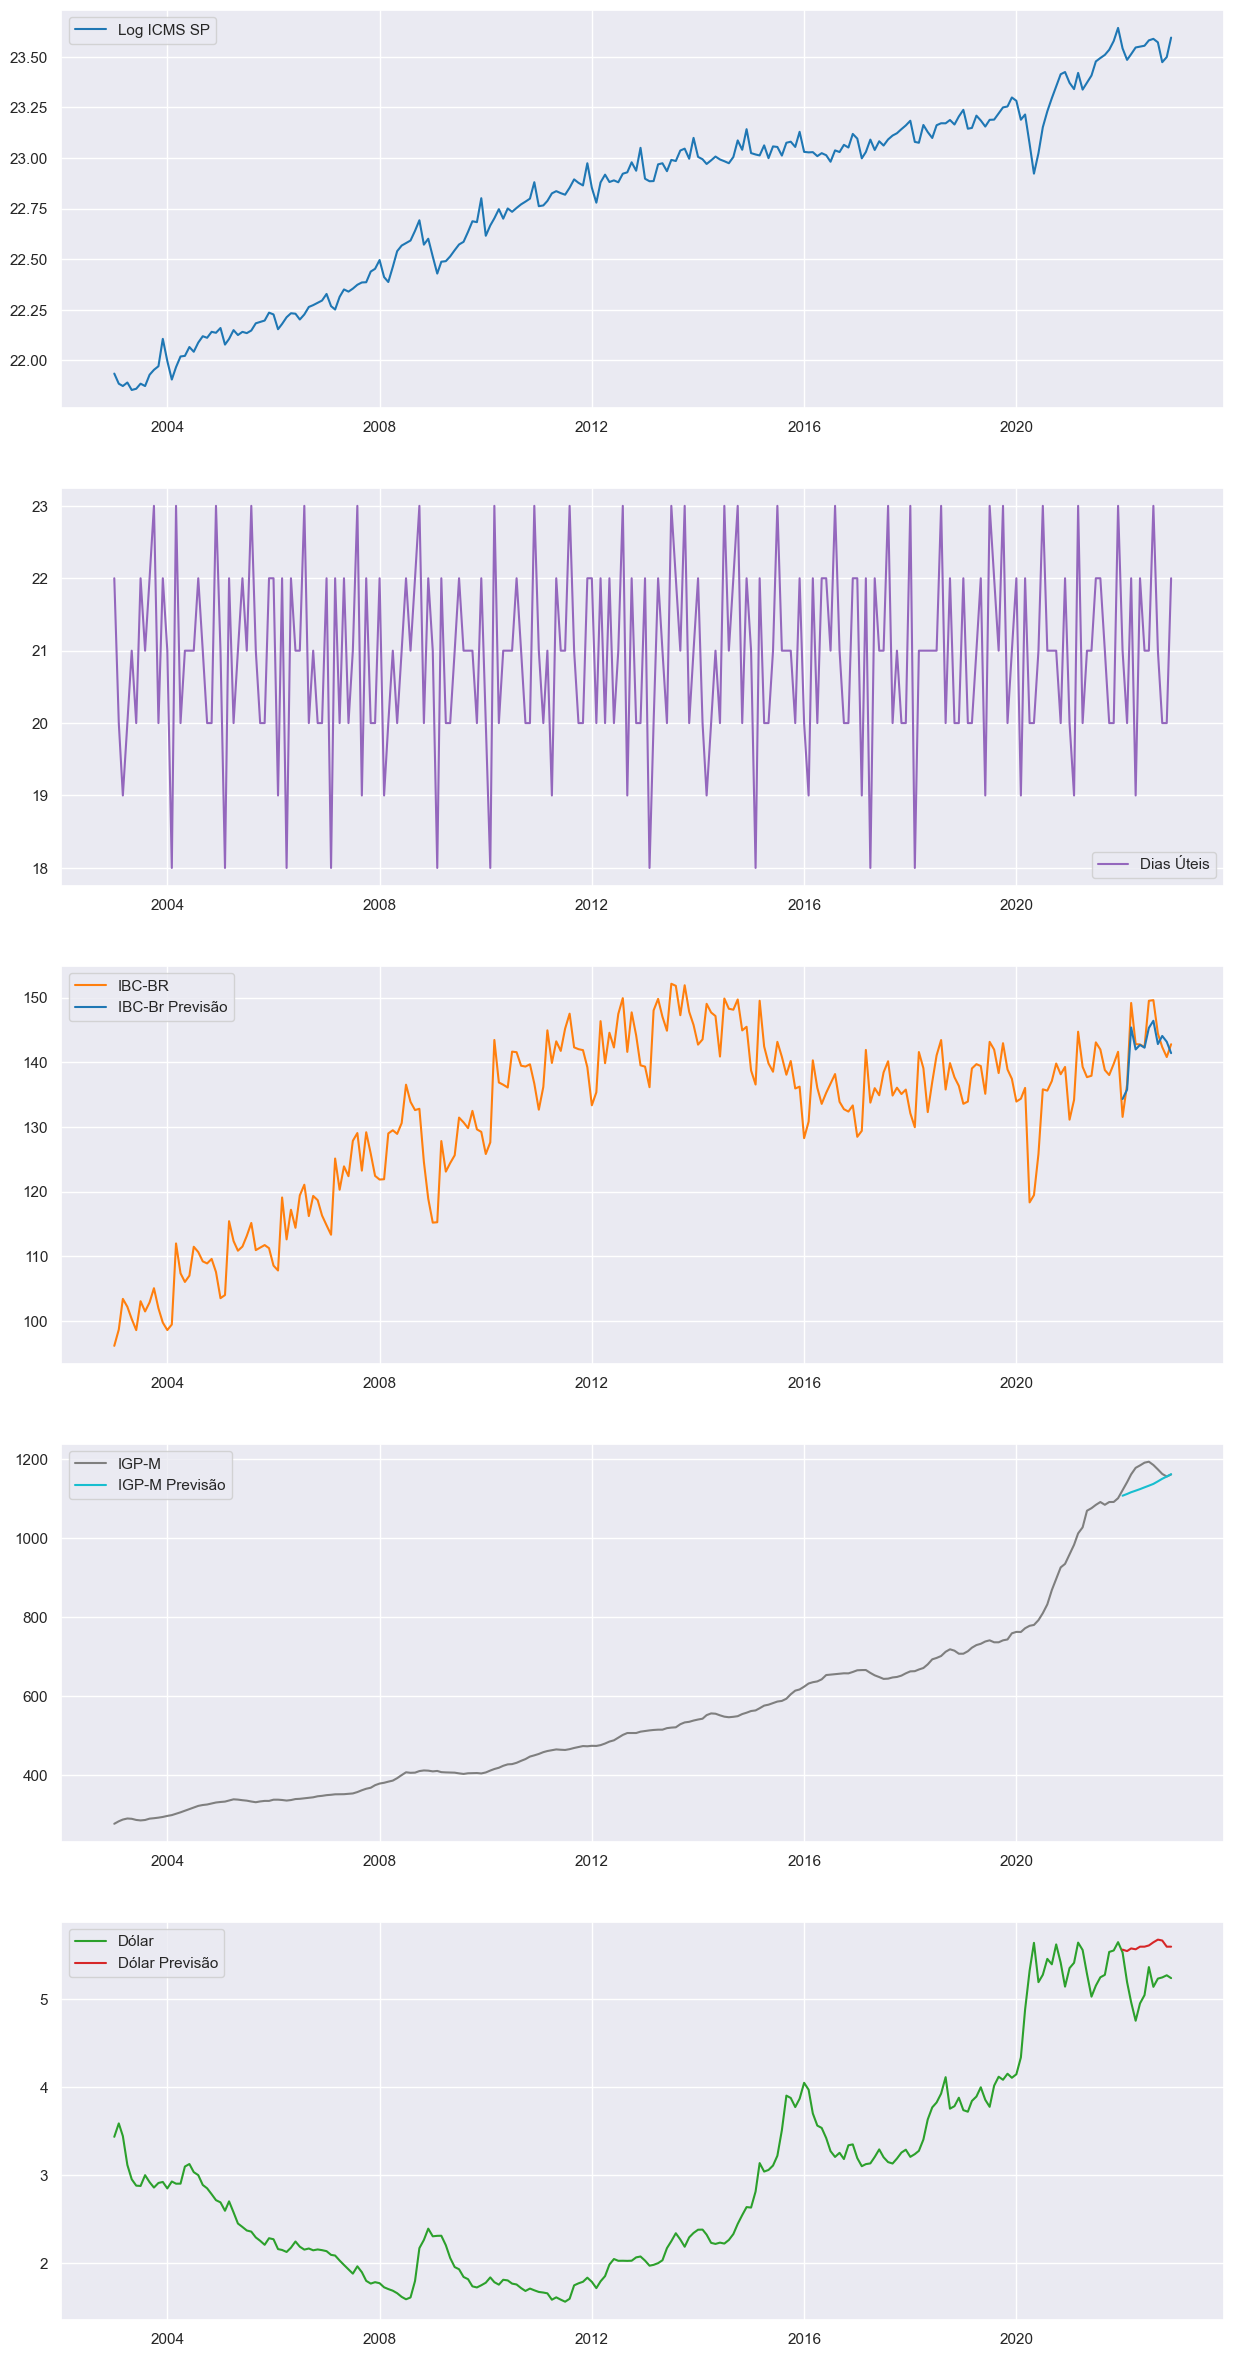

In [10]:
fig=plt.figure(figsize=(15, 30))
ax1=fig.add_subplot(511)
ax2=fig.add_subplot(512)
ax3=fig.add_subplot(513)
ax4=fig.add_subplot(514)
ax5=fig.add_subplot(515)
#plots
ax1.plot(icms_ts, 'tab:blue', label='Log ICMS SP')
ax1.legend(loc='best')
ax2.plot(dias_uteis_ts, 'tab:purple', label='Dias Úteis')
ax2.legend(loc='best')
ax3.plot(ibcbr_ts, 'tab:orange',  label='IBC-BR')
ax3.legend(loc='best')
ax3.plot(ibcbr_prev_ts[-12:], 'tab:blue', label='IBC-Br Previsão')
ax3.legend(loc='best')
ax4.plot(igpm_ts, 'tab:gray', label='IGP-M')
ax4.legend(loc='best')
ax4.plot(igpm_prev_ts[-12:], 'tab:cyan',  label='IGP-M Previsão')
ax4.legend(loc='best')
ax5.plot(dolar_ts, 'tab:green', label='Dólar')
ax5.legend(loc='best')
ax5.plot(dolar_prev_ts[-12:], 'tab:red', label='Dólar Previsão')
ax5.legend(loc='best')
plt.show()

#### Versão reduzida

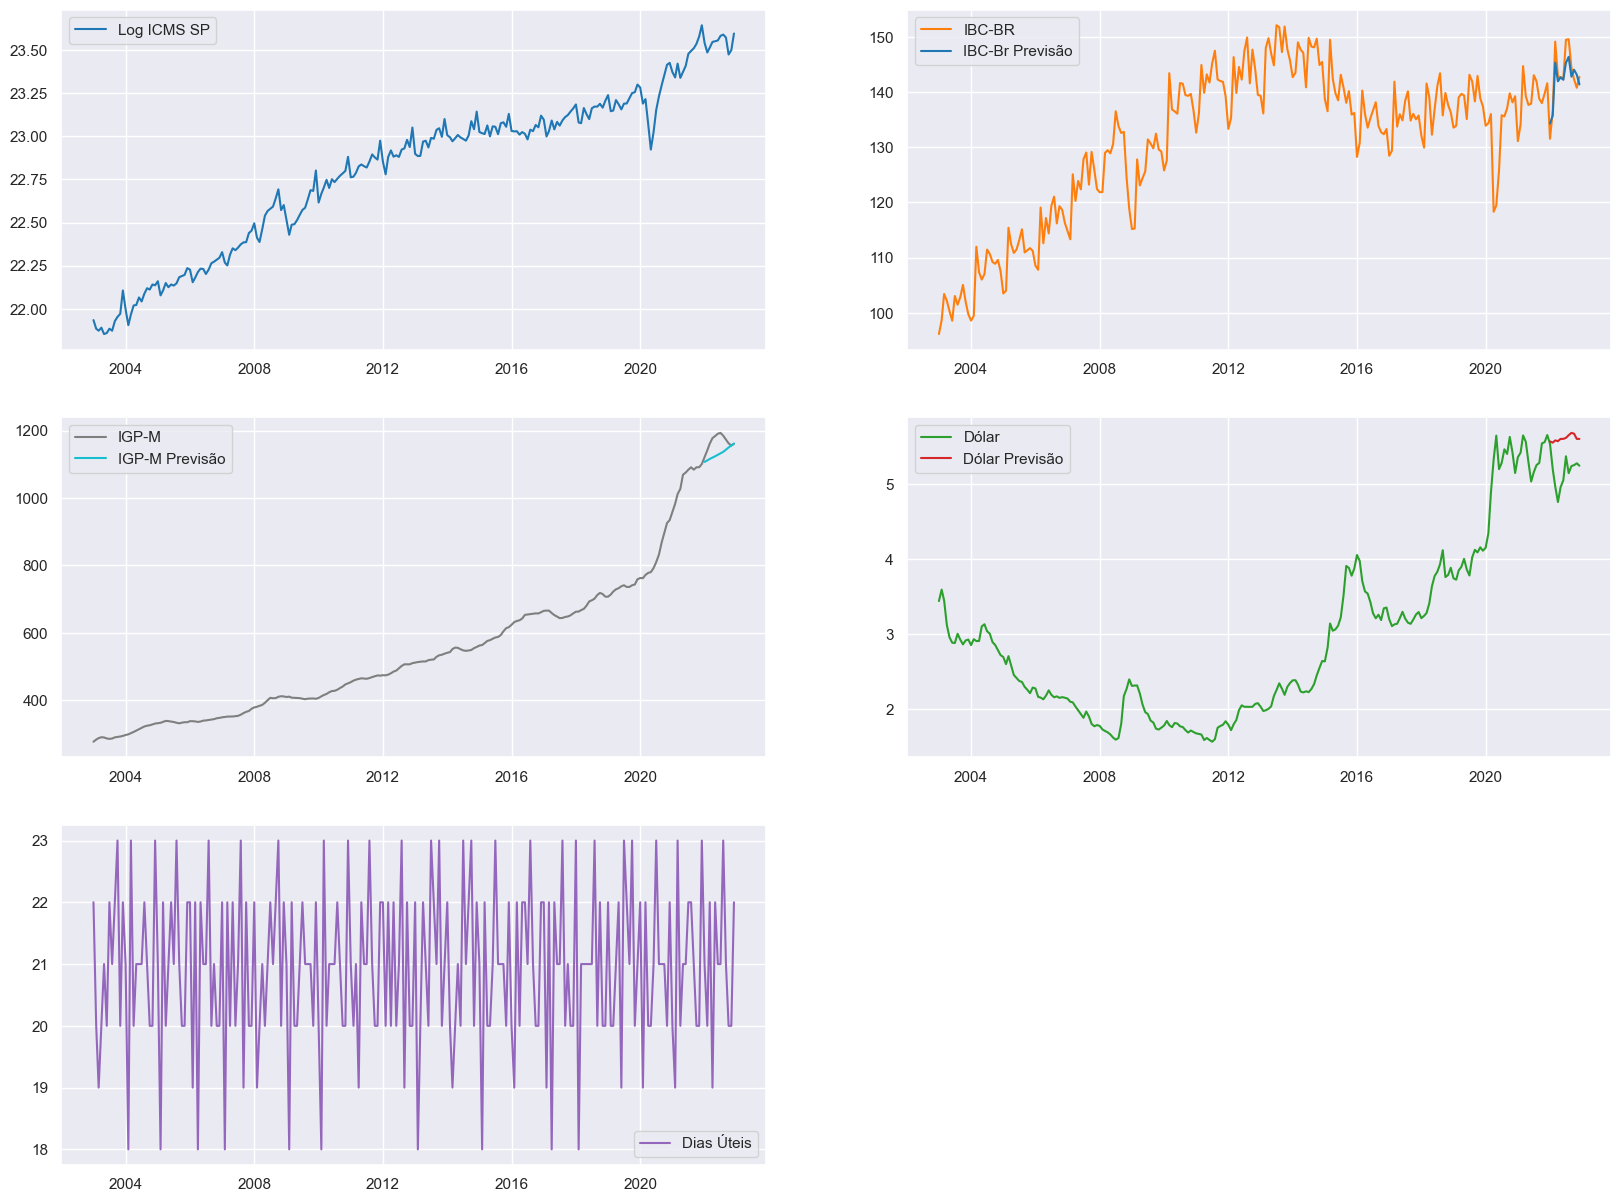

In [11]:
fig=plt.figure(figsize=(20, 15))
ax1=fig.add_subplot(321)
ax2=fig.add_subplot(322)
ax3=fig.add_subplot(323)
ax4=fig.add_subplot(324)
ax5=fig.add_subplot(325)
#plots
ax1.plot(icms_ts, 'tab:blue', label='Log ICMS SP')
ax1.legend(loc='best')

ax2.plot(ibcbr_ts, 'tab:orange',  label='IBC-BR')
ax2.legend(loc='best')
ax2.plot(ibcbr_prev_ts[-12:], 'tab:blue', label='IBC-Br Previsão')
ax2.legend(loc='best')
ax3.plot(igpm_ts, 'tab:gray', label='IGP-M')
ax3.legend(loc='best')
ax3.plot(igpm_prev_ts[-12:], 'tab:cyan',  label='IGP-M Previsão')
ax3.legend(loc='best')
ax4.plot(dolar_ts, 'tab:green', label='Dólar')
ax4.legend(loc='best')
ax4.plot(dolar_prev_ts[-12:], 'tab:red', label='Dólar Previsão')
ax4.legend(loc='best')
ax5.plot(dias_uteis_ts, 'tab:purple', label='Dias Úteis')
ax5.legend(loc='best')
plt.show()

### Séries em Primeira Diferença

In [12]:
icms_ts_d1 = icms_ts.diff().dropna()
ibcbr_ts_d1 = ibcbr_ts.diff().dropna()
igpm_ts_d1 = igpm_ts.diff().dropna()
dolar_ts_d1 = dolar_ts.diff().dropna()
dias_uteis_ts_d1 = dias_uteis_ts.diff().dropna()
igpm_prev_ts_d1 = igpm_prev_ts.diff().dropna()
ibcbr_prev_ts_d1 = ibcbr_prev_ts.diff().dropna()
dolar_prev_ts_d1 = dolar_prev_ts.diff().dropna()

### Séries em Segunda Diferença

In [13]:
icms_ts_d2 = icms_ts_d1.diff().dropna()
ibcbr_ts_d2 = ibcbr_ts_d1.diff().dropna()
igpm_ts_d2 = igpm_ts_d1.diff().dropna()
dolar_ts_d2 = dolar_ts_d1.diff().dropna()
dias_uteis_ts_d2 = dias_uteis_ts_d1.diff().dropna()
igpm_prev_ts_d2 = igpm_prev_ts_d1.diff().dropna()
ibcbr_prev_ts_d2 = ibcbr_prev_ts_d1.diff().dropna()
dolar_prev_ts_d2 = dolar_prev_ts_d1.diff().dropna()

### Plotando as Séries em Primeira Diferença

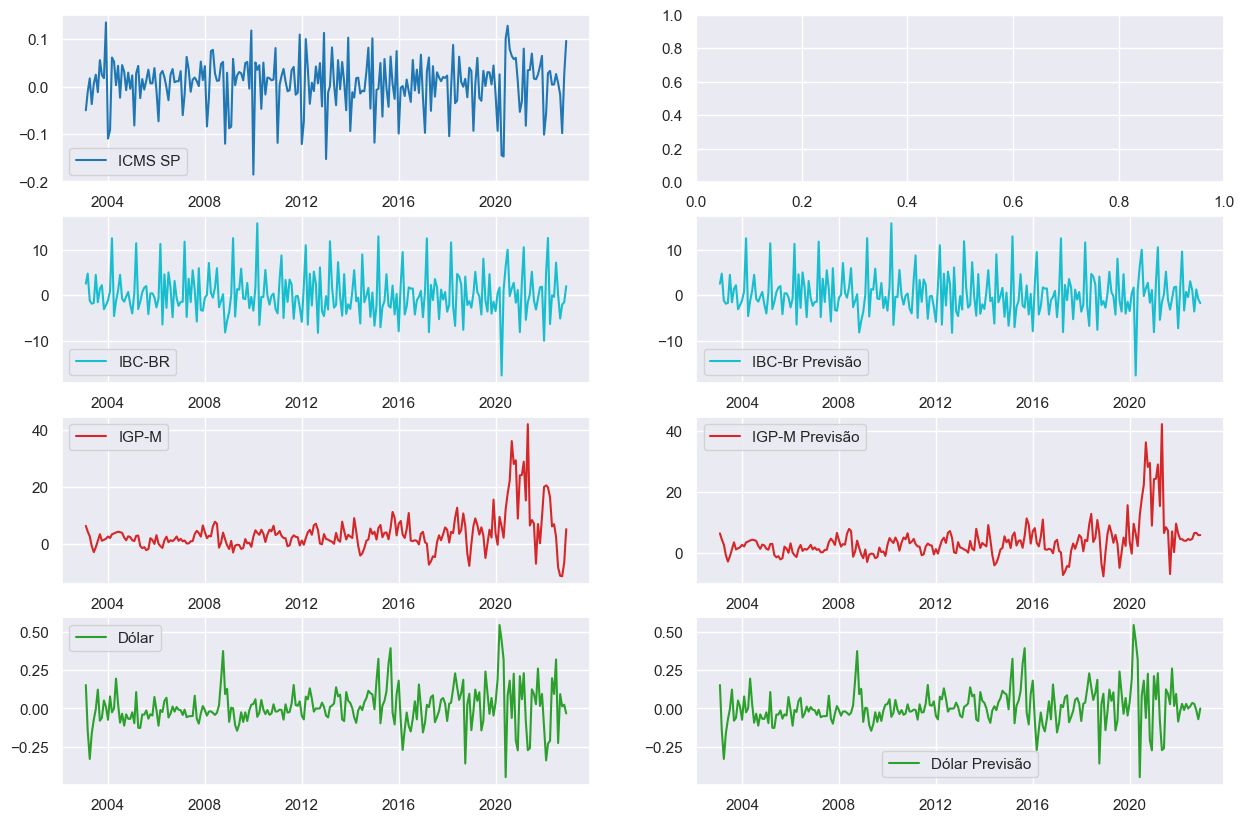

In [14]:
fig=plt.figure(figsize=(15, 10))
ax1=fig.add_subplot(421)
ax2=fig.add_subplot(422)
ax3=fig.add_subplot(423)
ax4=fig.add_subplot(424)
ax5=fig.add_subplot(425)
ax6=fig.add_subplot(426)
ax7=fig.add_subplot(427)
ax8=fig.add_subplot(428)
#plots
ax1.plot(icms_ts_d1, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
ax3.plot(ibcbr_ts_d1, 'tab:cyan',  label='IBC-BR')
ax3.legend(loc='best')
ax4.plot(ibcbr_prev_ts_d1, 'tab:cyan', label='IBC-Br Previsão')
ax4.legend(loc='best')
ax5.plot(igpm_ts_d1, 'tab:red', label='IGP-M')
ax5.legend(loc='best')
ax6.plot(igpm_prev_ts_d1, 'tab:red',  label='IGP-M Previsão')
ax6.legend(loc='best')
ax7.plot(dolar_ts_d1, 'tab:green', label='Dólar')
ax7.legend(loc='best')
ax8.plot(dolar_prev_ts_d1, 'tab:green', label='Dólar Previsão')
ax8.legend(loc='best')
plt.show()

#### Versão Reduzida

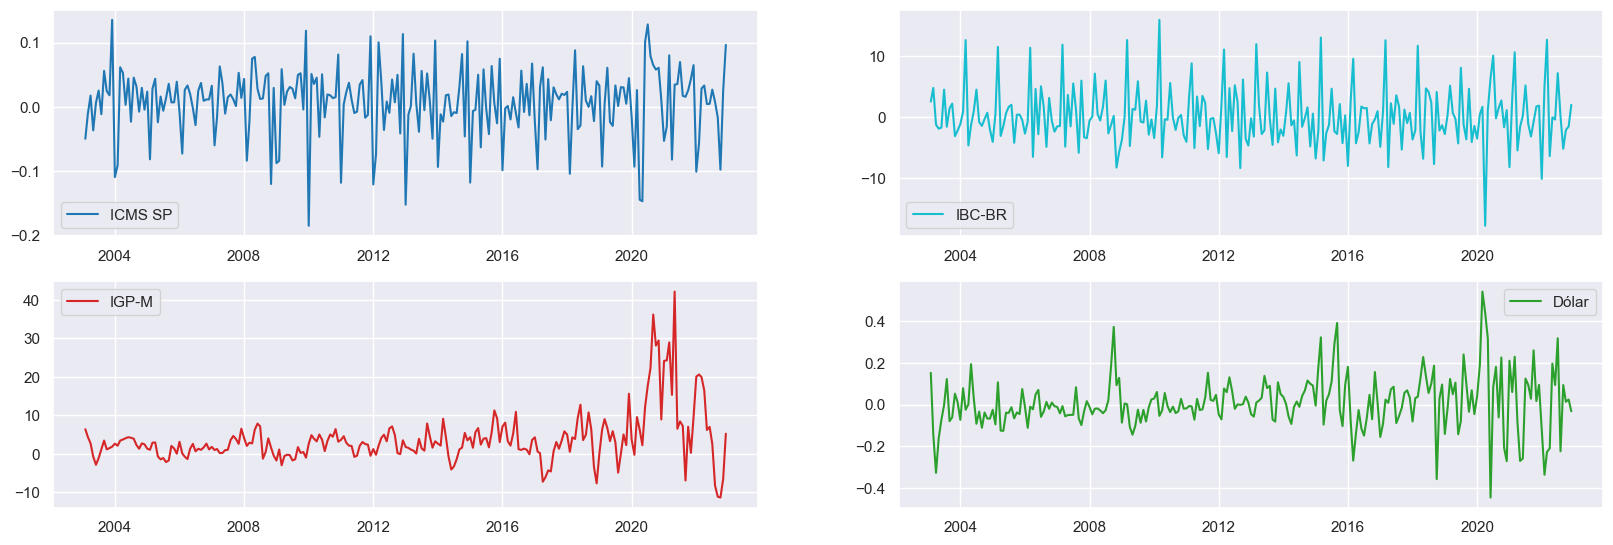

In [15]:
fig=plt.figure(figsize=(20, 10))
ax1=fig.add_subplot(321)
ax2=fig.add_subplot(322)
ax3=fig.add_subplot(323)
ax4=fig.add_subplot(324)
#plots
ax1.plot(icms_ts_d1, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
ax2.plot(ibcbr_ts_d1, 'tab:cyan',  label='IBC-BR')
ax2.legend(loc='best')
ax3.plot(igpm_ts_d1, 'tab:red', label='IGP-M')
ax3.legend(loc='best')
ax4.plot(dolar_ts_d1, 'tab:green', label='Dólar')
ax4.legend(loc='best')
plt.show()

### Plotando as Séries em Segunda Diferença

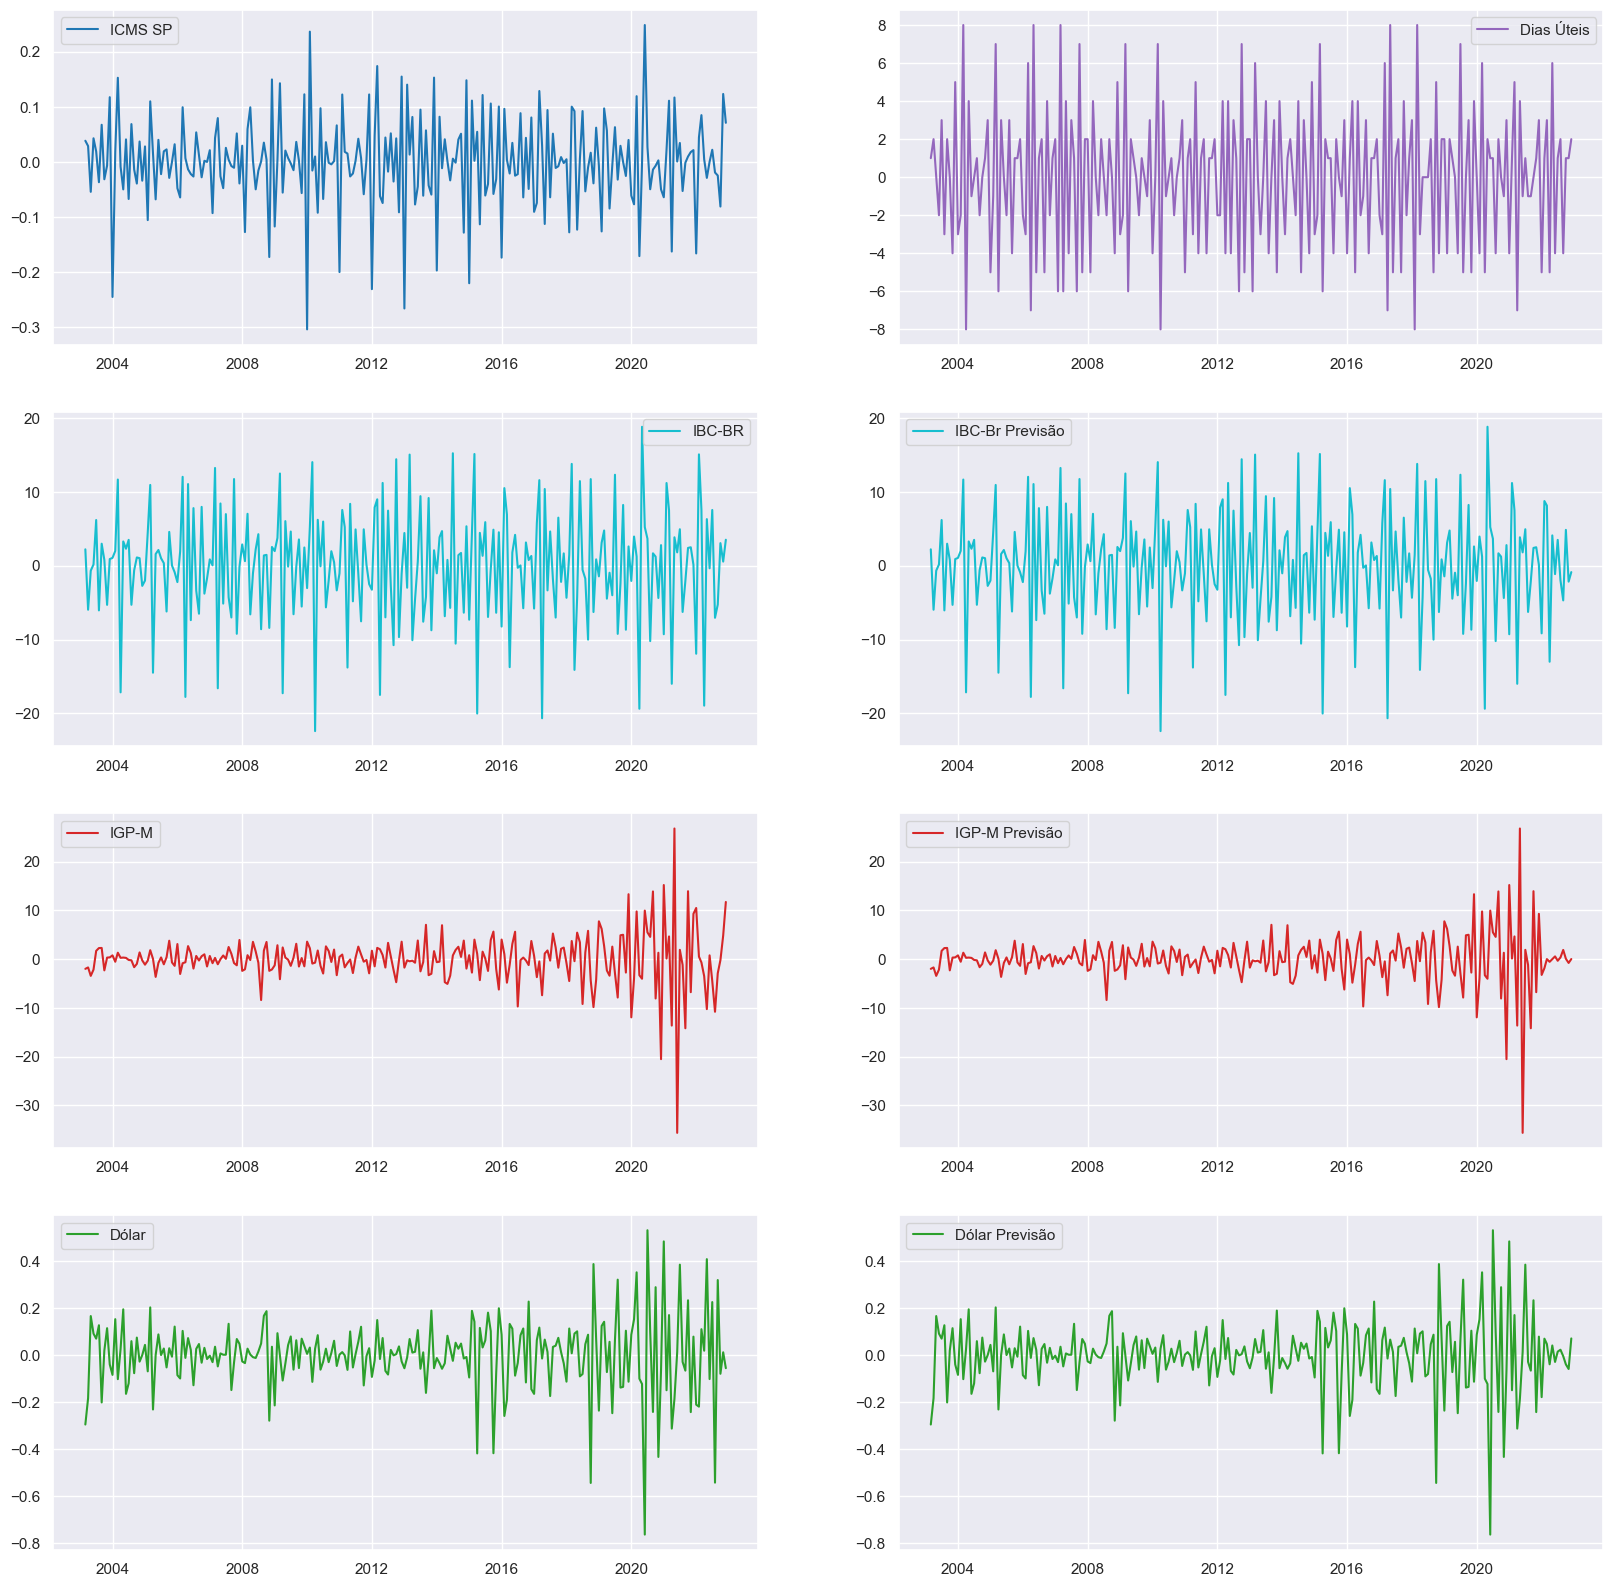

In [16]:
fig=plt.figure(figsize=(20, 20))
ax1=fig.add_subplot(421)
ax2=fig.add_subplot(422)
ax3=fig.add_subplot(423)
ax4=fig.add_subplot(424)
ax5=fig.add_subplot(425)
ax6=fig.add_subplot(426)
ax7=fig.add_subplot(427)
ax8=fig.add_subplot(428)
#plots
ax1.plot(icms_ts_d2, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
ax2.plot(dias_uteis_ts_d2, 'tab:purple', label='Dias Úteis')
ax2.legend(loc='best')
ax3.plot(ibcbr_ts_d2, 'tab:cyan',  label='IBC-BR')
ax3.legend(loc='best')
ax4.plot(ibcbr_prev_ts_d2, 'tab:cyan', label='IBC-Br Previsão')
ax4.legend(loc='best')
ax5.plot(igpm_ts_d2, 'tab:red', label='IGP-M')
ax5.legend(loc='best')
ax6.plot(igpm_prev_ts_d2, 'tab:red',  label='IGP-M Previsão')
ax6.legend(loc='best')
ax7.plot(dolar_ts_d2, 'tab:green', label='Dólar')
ax7.legend(loc='best')
ax8.plot(dolar_prev_ts_d2, 'tab:green', label='Dólar Previsão')
ax8.legend(loc='best')
plt.show()

#### Versão Reduzida

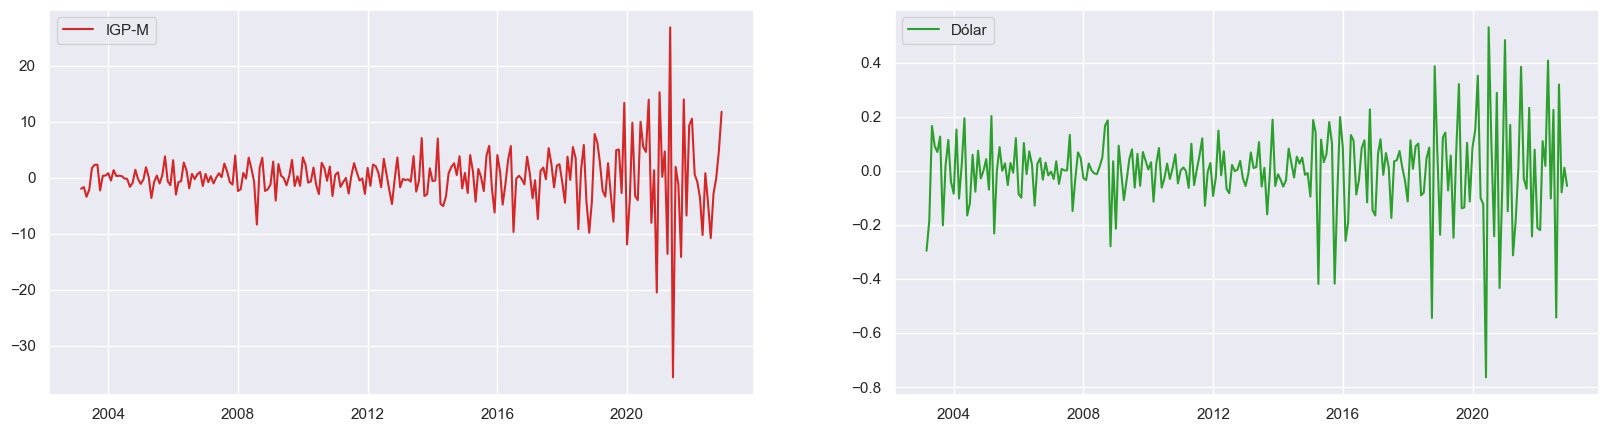

In [17]:
fig=plt.figure(figsize=(20, 5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
#plots
ax1.plot(igpm_ts_d2, 'tab:red', label='IGP-M')
ax1.legend(loc='best')
ax2.plot(dolar_ts_d2, 'tab:green', label='Dólar')
ax2.legend(loc='best')
plt.show()

### Teste de Raiz Unitária das Séries em Nível

Teste de raiz unitária Dickey-Fuller Aumentado (ADF): a hipótese nula é de que há raiz unitária e a série não é estacionária; a alternativa, de que não há e, portanto, a série é estacionária. 

Teste de raiz unitária Kwiatkowski-Phillips-Schmidt-Shin (KPSS): a hipótese nula é de que a série é de tendência estacionária; a alternativa é de há raiz unitária e a série não é estacionária.

A combinação dos dois testes pode ter os seguintes resultados com as seguintes consequências:

- Caso 1: Ambos os testes concluem que a série não é estacionária, então a série não é estacionária
- Caso 2: Ambos os testes concluem que a série é estacionária, então a série é estacionária
- Caso 3: o KPSS indica estacionariedade e o ADF indica não estacionariedade; a série é estacionária de tendência. A tendência precisa ser removida para tornar a série estritamente estacionária. A série sem tendência deve ser verificada quanto à estacionariedade.
- Caso 4: KPSS indica não estacionariedade e ADF indica estacionariedade; a série é estacionária diferencial. A diferenciação deve ser usada para tornar as séries estacionárias. A série diferenciada deve ser verificada quanto à estacionariedade.

**Fonte**: [Statsmodel](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

In [18]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

#### Série do ICMS

In [19]:
adf_test(icms_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.388565
p-value                          0.587746
#Lags Used                      12.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64


In [20]:
kpss_test(icms_ts)

Results of KPSS Test:
Test Statistic            2.167822
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do ICMS em nível: a 5%, não rejeita-se a nula do teste ADF e rejeita-se do teste KPSS. A série não é estacionária em ambos os testes e precisa ser posta em primeira diferença.

#### Série do IBC-Br

In [21]:
adf_test(ibcbr_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.320692
p-value                          0.165381
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


In [22]:
kpss_test(ibcbr_ts)

Results of KPSS Test:
Test Statistic           1.612638
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do IBC-Br em nível: a 5%, não rejeita-se a nula do teste ADF e rejeita-se do teste KPSS. A série não é estacionária em ambos os testes e precisa ser posta em primeira diferença.

#### Série do IGP-M

In [23]:
adf_test(igpm_ts)

Results of Dickey-Fuller Test:
Test Statistic                   1.202435
p-value                          0.996003
#Lags Used                      13.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.874415
Critical Value (10%)            -2.573632
dtype: float64


In [24]:
kpss_test(igpm_ts)

Results of KPSS Test:
Test Statistic            1.996898
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do IGP-M em nível: a 5%, não se rejeita a nula do teste ADF e rejeita-se a nula do teste KPSS. A série não é estacionária em ambos os testes e precisa ser posta em primeira diferença.

#### Série do Dólar

In [25]:
adf_test(dolar_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -0.034065
p-value                          0.955623
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


In [26]:
kpss_test(dolar_ts)

Results of KPSS Test:
Test Statistic            1.490171
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do Dólar em nível: a 5%, não se rejeita a nula do teste ADF e rejeita-se a nula do teste KPSS. A série não é estacionária em ambos os testes e precisa ser posta em primeira diferença.

#### Série Dias Úteis

In [27]:
adf_test(dias_uteis_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -4.136288
p-value                          0.000843
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


In [28]:
kpss_test(dias_uteis_ts)

Results of KPSS Test:
Test Statistic           0.096826
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série dos Dias Úteis em nível: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em nível.

### Teste de Raiz Unitária da Série em Primeira Diferença
As séries postas em primeira diferença serão testadas para estacionariedade com os testes ADF e KPSS.

#### Série do ICMS

In [29]:
adf_test(icms_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -4.676552
p-value                          0.000093
#Lags Used                      11.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64


In [30]:
kpss_test(icms_ts_d1)

Results of KPSS Test:
Test Statistic           0.075466
p-value                  0.100000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do ICMS em primeira diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em primeira diferença.

#### Série do IBC-Br

In [31]:
adf_test(ibcbr_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -3.977525
p-value                          0.001533
#Lags Used                      14.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


In [32]:
kpss_test(ibcbr_ts_d1)

Results of KPSS Test:
Test Statistic            0.278758
p-value                   0.100000
Lags Used                53.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do IBC-Br em primeira diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em primeira diferença.

#### Série do IGP-M

In [33]:
adf_test(igpm_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -2.892481
p-value                          0.046229
#Lags Used                      12.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.874415
Critical Value (10%)            -2.573632
dtype: float64


In [34]:
kpss_test(igpm_ts_d1)

Results of KPSS Test:
Test Statistic           0.639544
p-value                  0.019041
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do IGP-M em primeira diferença: a 5%, rejeita-se a nula do teste ADF e também se rejeita a nula do teste KPSS. A série é estacionária pelo teste ADF mas não é estacionária pelo teste KPSS. A série precisa ser diferenciada novamente para poder ser usada.

##### Diferenciando novamente a série e testando a estacionariedade

In [35]:
adf_test(igpm_ts_d2)

Results of Dickey-Fuller Test:
Test Statistic                -5.707057e+00
p-value                        7.446347e-07
#Lags Used                     1.200000e+01
Number of Observations Used    2.250000e+02
Critical Value (1%)           -3.459752e+00
Critical Value (5%)           -2.874473e+00
Critical Value (10%)          -2.573663e+00
dtype: float64


In [36]:
kpss_test(igpm_ts_d2)

Results of KPSS Test:
Test Statistic           0.025602
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do IGP-M em segunda diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em segunda diferença.

#### Série do Dólar

In [37]:
adf_test(dolar_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -3.843087
p-value                          0.002496
#Lags Used                      13.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


In [38]:
kpss_test(dolar_ts_d1)

Results of KPSS Test:
Test Statistic           0.538918
p-value                  0.032901
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do Dólar em primeira diferença: a 5%, rejeita-se a nula do teste ADF e também se rejeita a nula do teste KPSS. A série é estacionária pelo teste ADF mas não é estacionária pelo teste KPSS. A série precisa ser diferenciada novamente para poder ser usada.

##### Diferenciando novamente a série e testando a estacionariedade

In [39]:
dolar_ts_d2 = dolar_ts_d1.diff().dropna()

In [40]:
adf_test(dolar_ts_d2)

Results of Dickey-Fuller Test:
Test Statistic                -6.803126e+00
p-value                        2.211019e-09
#Lags Used                     1.200000e+01
Number of Observations Used    2.250000e+02
Critical Value (1%)           -3.459752e+00
Critical Value (5%)           -2.874473e+00
Critical Value (10%)          -2.573663e+00
dtype: float64


In [41]:
kpss_test(dolar_ts_d2)

Results of KPSS Test:
Test Statistic            0.143355
p-value                   0.100000
Lags Used                58.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do Dólar em segunda diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em segunda diferença.

#### Série Dias Úteis

Não será testada, pois já é estacionária em nível.

### Estacionariedade das Séries

Conclue-se que, para se trabalhar com todas as séries estacionárias, as séries serão usadas em nível, em primeira ou segunda diferença, conforme abaixo:
- ICMS: primeira diferença
- IBC-Br: primeira diferença
- IGP-M: segunda diferença
- Dólar: segunda diferença
- Dias Úteis: nível

##### Equalizando o tamanho das séries
IPCA e Dias Úteis ficaram maiores que as demais séries estão em nível, assim como as séries em primeira diferenças estão maiores do que as em segunda diferença. O primeiro e o segundo valores destas duas séries, e somente o primeiro das que estão em primeira diferança serão removidos.

In [42]:
print('antes', icms_ts_d1.shape, ibcbr_ts_d1.shape, igpm_ts_d2.shape, dolar_ts_d2.shape, dias_uteis_ts.shape,
     ibcbr_prev_ts_d1.shape, igpm_prev_ts_d2.shape, dolar_prev_ts_d2.shape,)
icms_ts_adj = icms_ts_d1[1:]
ibcbr_ts_adj = ibcbr_ts_d1[1:]
igpm_ts_adj = igpm_ts_d2
dolar_ts_adj = dolar_ts_d2
dias_uteis_ts_adj = dias_uteis_ts[2:]
ibcbr_prev_ts_adj = ibcbr_prev_ts_d1[1:]
igpm_prev_ts_adj = igpm_prev_ts_d2
dolar_prev_ts_adj = dolar_prev_ts_d2
print('depois', icms_ts_adj.shape, ibcbr_ts_adj.shape, igpm_ts_adj.shape, dolar_ts_adj.shape, 
      dias_uteis_ts_adj.shape, ibcbr_prev_ts_adj.shape, igpm_prev_ts_adj.shape, dolar_prev_ts_adj.shape)

antes (239,) (239,) (238,) (238,) (240,) (239,) (238,) (238,)
depois (238,) (238,) (238,) (238,) (238,) (238,) (238,) (238,)


### Dessazonalização das Séries

In [43]:
sns.set(rc={'figure.figsize':(15,8)})

#### Série do ICMS

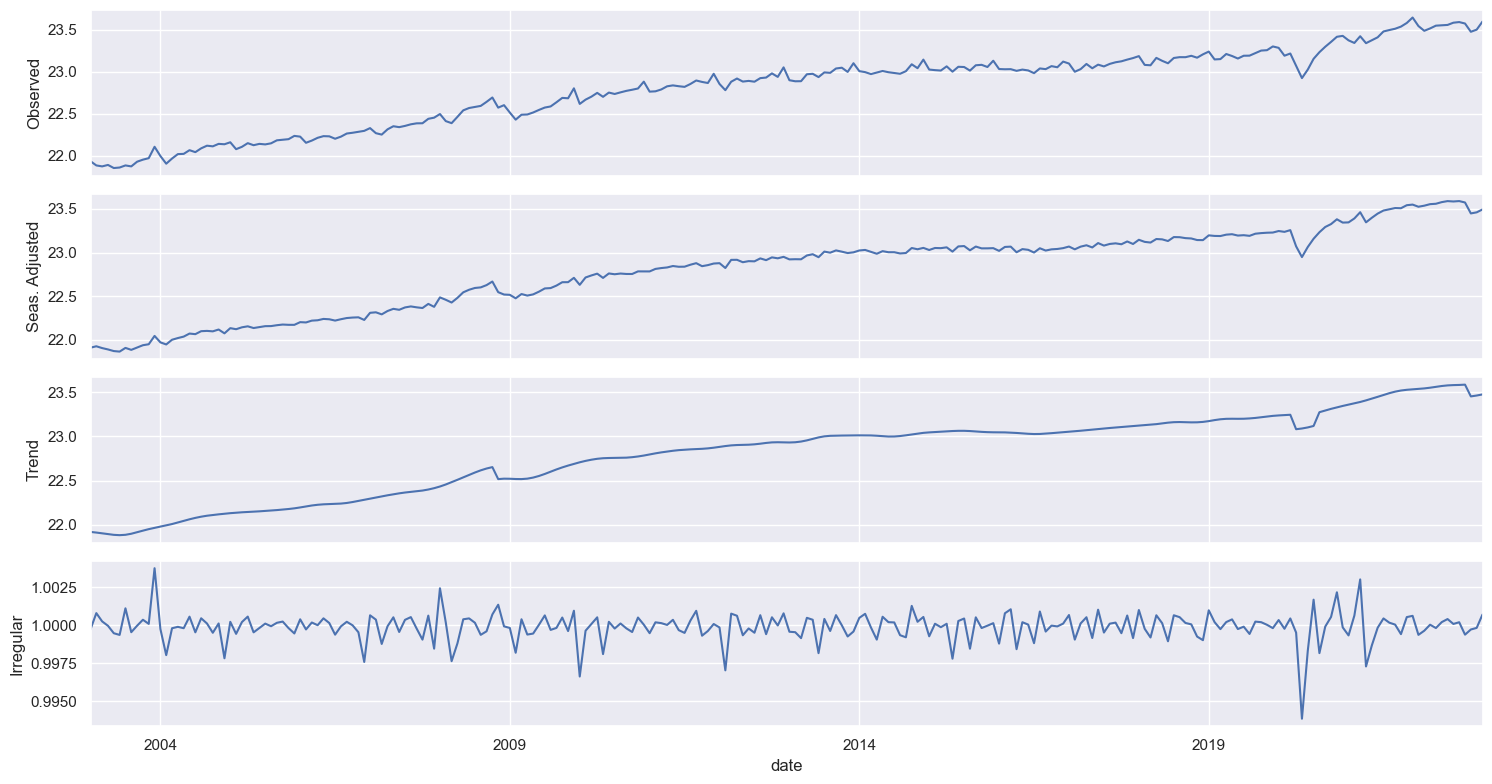

In [44]:
seas_icms = statsmodels.tsa.x13.x13_arima_analysis(icms_ts, x12path='./x13asmac/')
plot = seas_icms.plot()

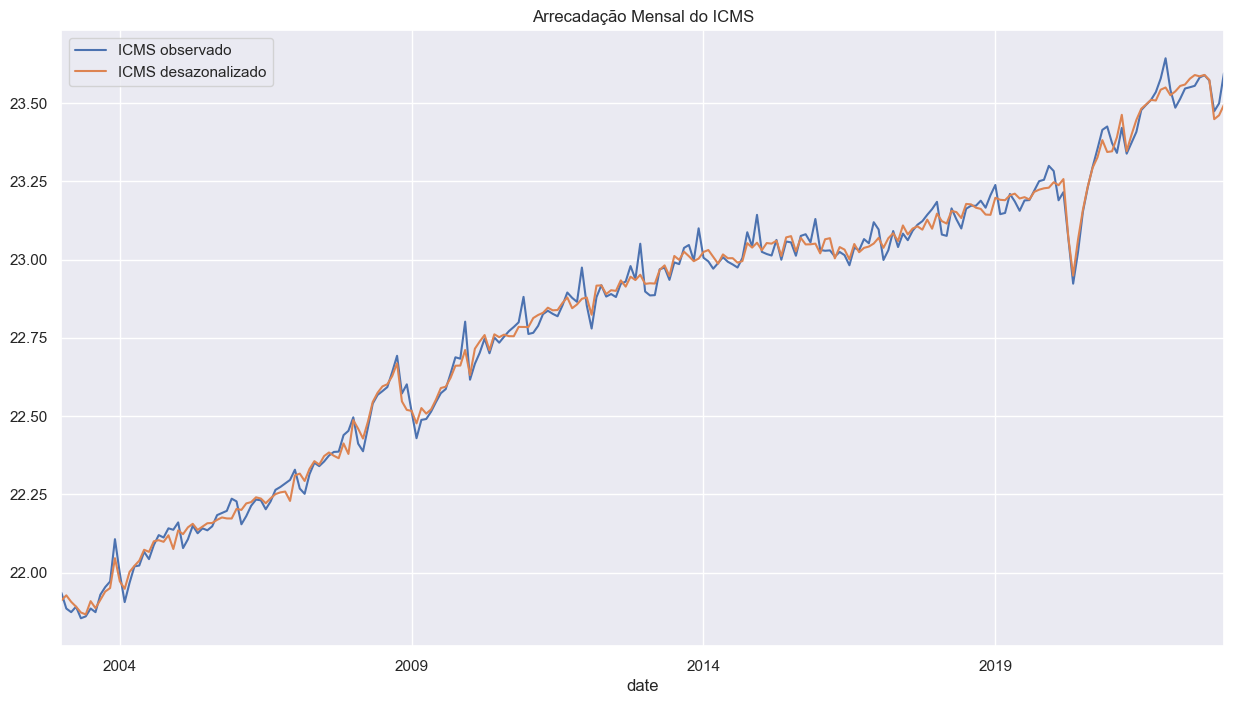

In [45]:
icms_decomp = pd.DataFrame(data={'ICMS observado': seas_icms.observed, 
                                 'ICMS desazonalizado': seas_icms.seasadj})
plot = icms_decomp.plot(title='Arrecadação Mensal do ICMS')

#### Série do IBC-Br

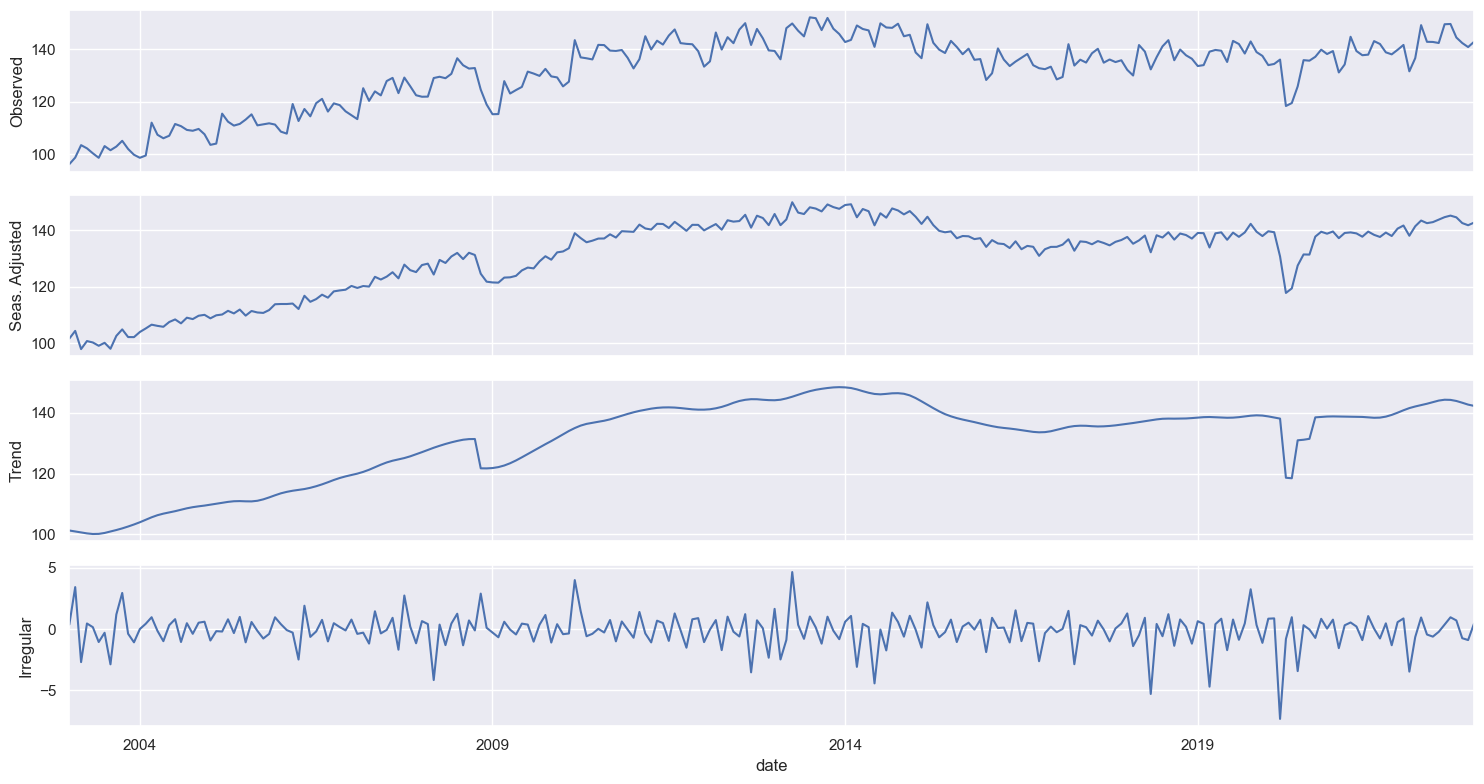

In [46]:
sns.set(rc={'figure.figsize':(15,8)})
seas_ibcbr = statsmodels.tsa.x13.x13_arima_analysis(ibcbr_ts, x12path='./x13asmac/')
plot = seas_ibcbr.plot()

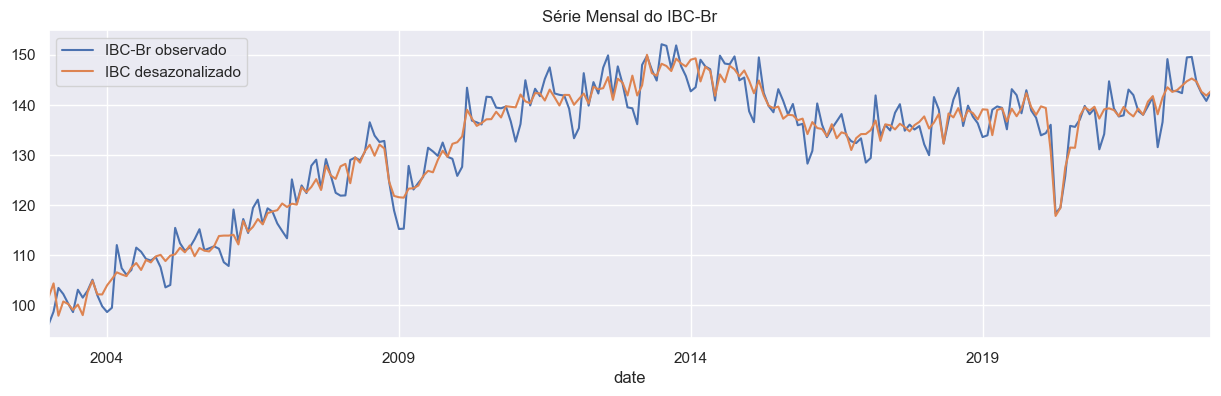

In [47]:
sns.set(rc={'figure.figsize':(15,4)})
ibcbr_decomp = pd.DataFrame(data={'IBC-Br observado': seas_ibcbr.observed, 
                                  'IBC desazonalizado': seas_ibcbr.seasadj})
plot = ibcbr_decomp.plot(title='Série Mensal do IBC-Br')

#### Série do IGP-DI

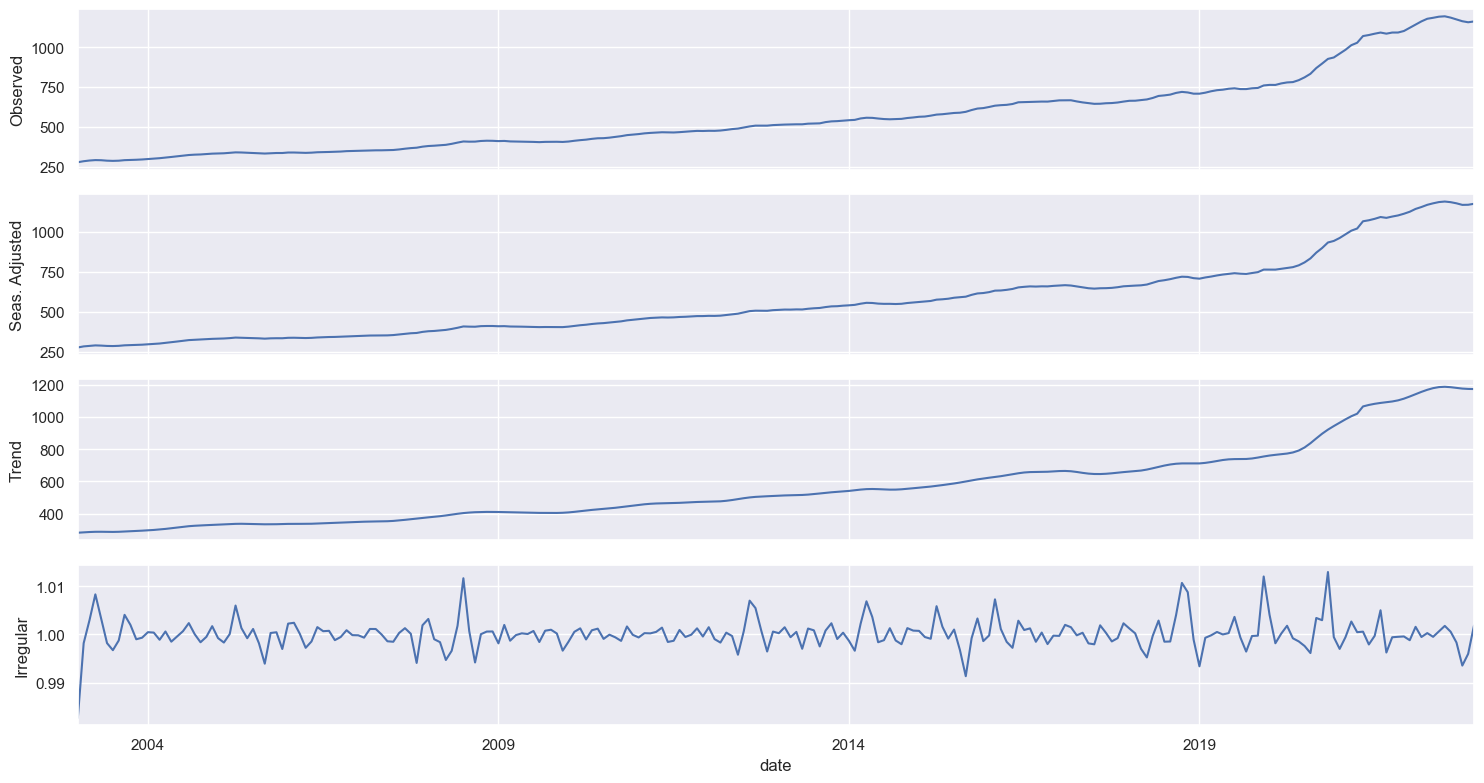

In [48]:
sns.set(rc={'figure.figsize':(15,8)})
seas_igpm = statsmodels.tsa.x13.x13_arima_analysis(igpm_ts, x12path='./x13asmac/')
plot = seas_igpm.plot()

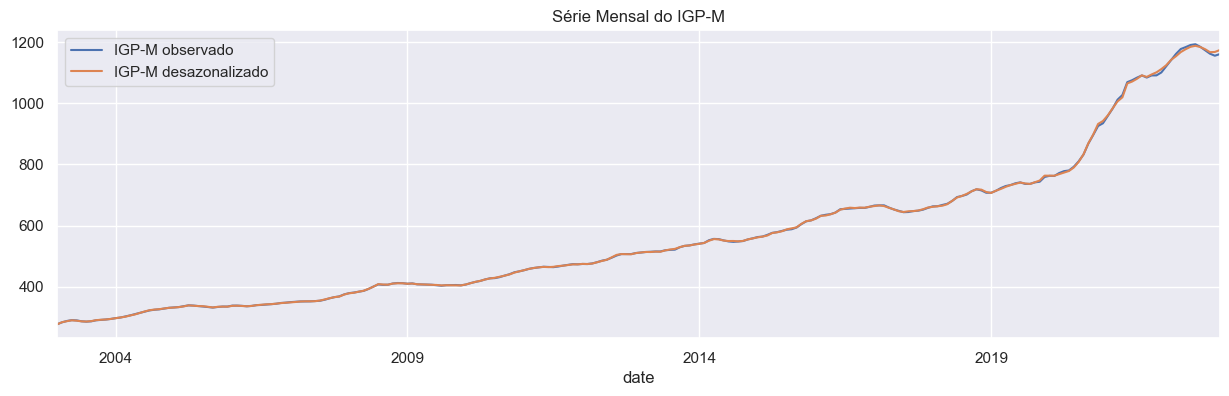

In [49]:
sns.set(rc={'figure.figsize':(15,4)})
igpm_decomp = pd.DataFrame(data={'IGP-M observado': seas_igpm.observed, 
                                  'IGP-M desazonalizado': seas_igpm.seasadj})
plot = igpm_decomp.plot(title='Série Mensal do IGP-M')

#### Série do Dólar

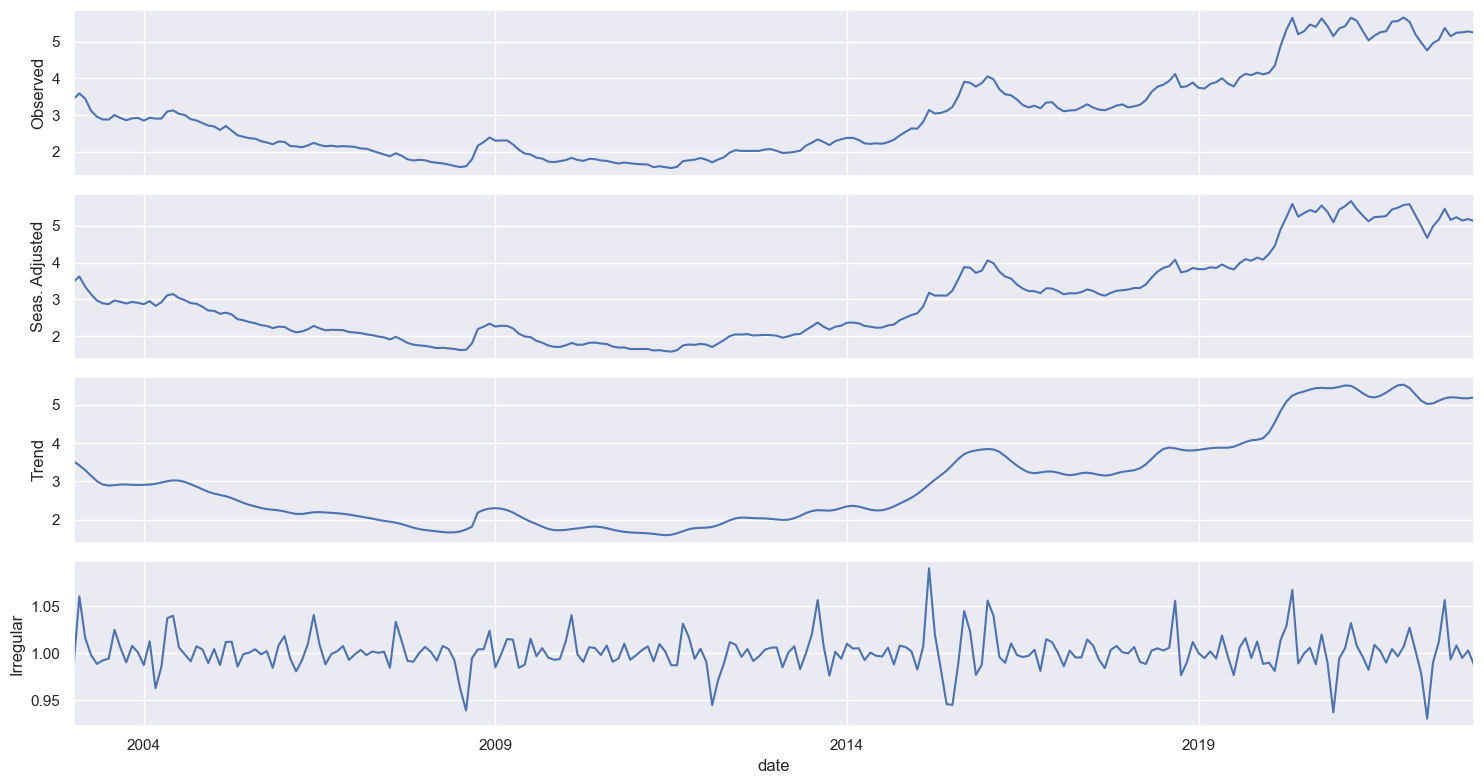

In [50]:
sns.set(rc={'figure.figsize':(15,8)})
seas_dolar = statsmodels.tsa.x13.x13_arima_analysis(dolar_ts, x12path='./x13asmac/')
plot = seas_dolar.plot()

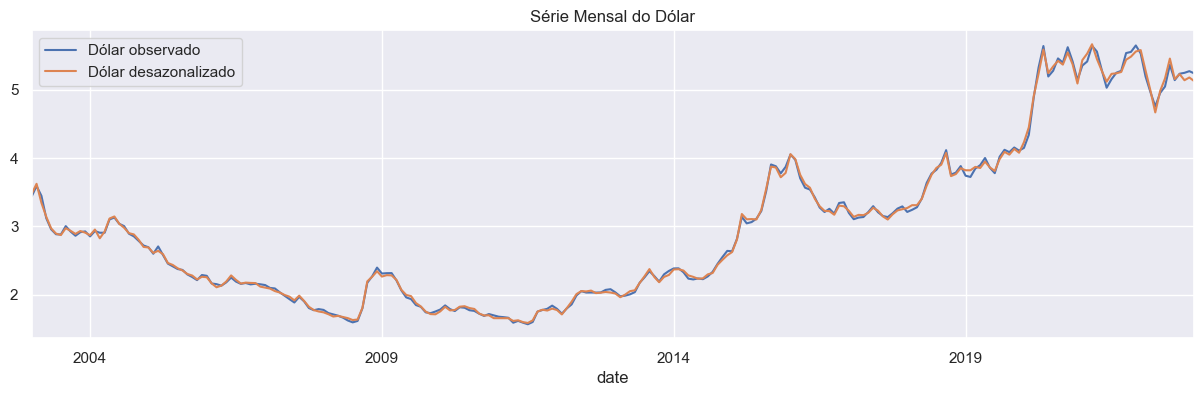

In [51]:
sns.set(rc={'figure.figsize':(15,4)})
dolar_decomp = pd.DataFrame(data={'Dólar observado': seas_dolar.observed, 
                                  'Dólar desazonalizado': seas_dolar.seasadj})
plot = dolar_decomp.plot(title='Série Mensal do Dólar')

#### Série dos Dias Úteis

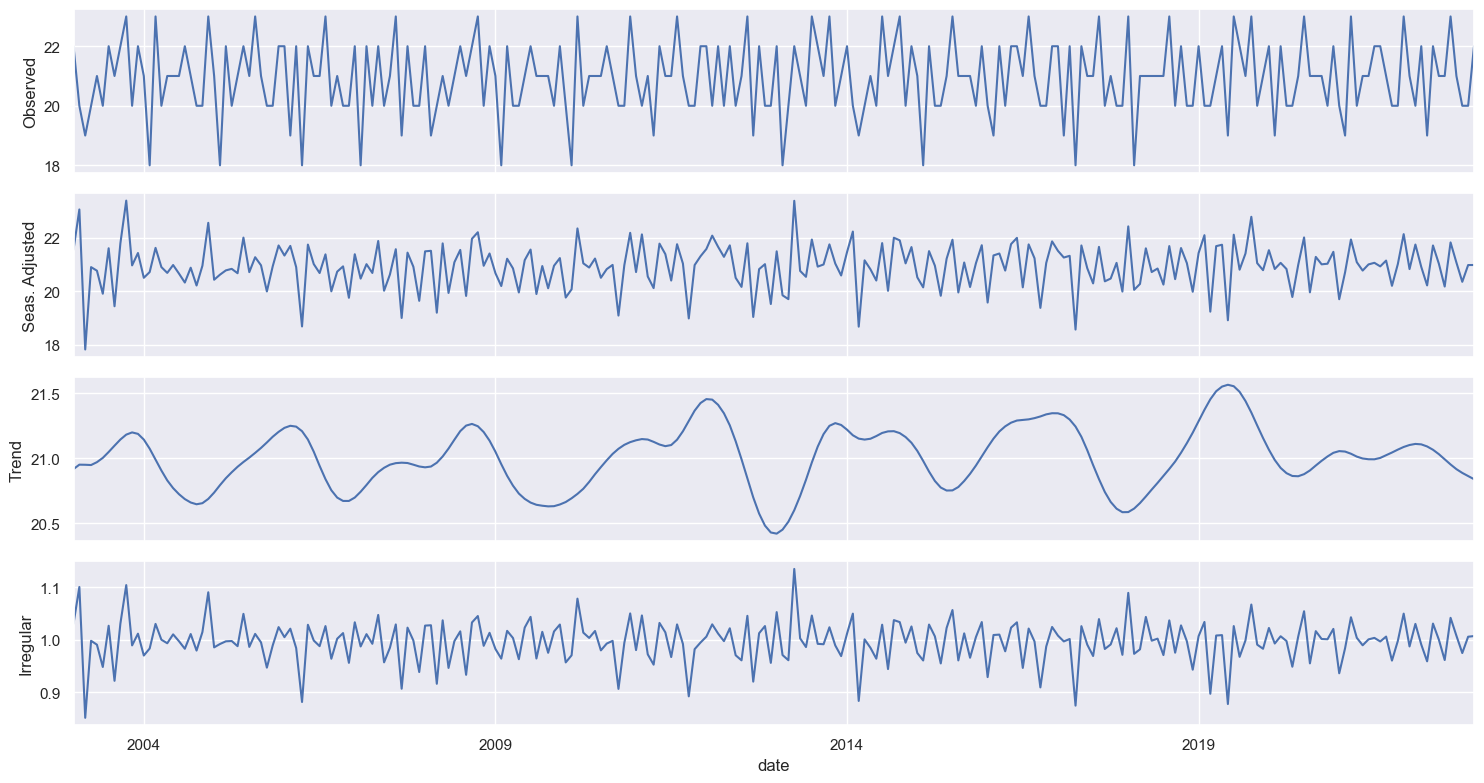

In [52]:
sns.set(rc={'figure.figsize':(15,8)})
seas_dias_uteis = statsmodels.tsa.x13.x13_arima_analysis(dias_uteis_ts, x12path='./x13asmac/')
plot = seas_dias_uteis.plot()

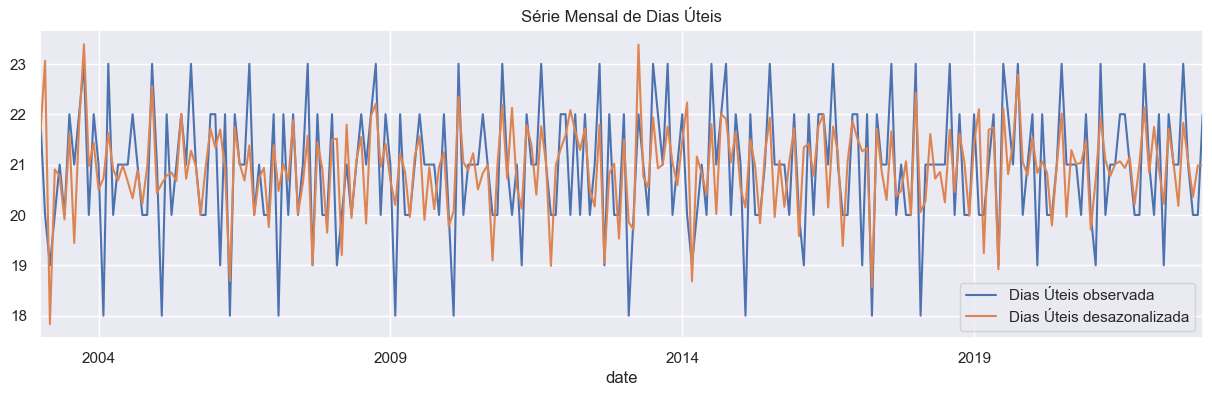

In [53]:
sns.set(rc={'figure.figsize':(15,4)})
dias_uteis_decomp = pd.DataFrame(data={'Dias Úteis observada': seas_dias_uteis.observed, 
                                  'Dias Úteis desazonalizada': seas_dias_uteis.seasadj})
plot = dias_uteis_decomp.plot(title='Série Mensal de Dias Úteis')

In [54]:
sns.set(rc={'figure.figsize':(15,8)})

### Criando dummies de intervenção

In [55]:
pos = seas_icms.results.find('Outliers')
print(seas_icms.results[pos-309:pos+2105])

 ------------------------------------------------------------------------------
                             Parameter        Standard
 Variable                     Estimate           Error      t-value
 ------------------------------------------------------------------------------
 Automatically Identified Outliers
   LS2008.Nov                  -0.0065         0.00113        -5.75
   LS2020.Apr                  -0.0073         0.00120        -6.12
   AO2020.May                  -0.0063         0.00124        -5.03
   LS2020.Aug                   0.0059         0.00114         5.17
   LS2022.Oct                  -0.0059         0.00122        -4.88
 ------------------------------------------------------------------------------


 ARIMA Model:  (1 1 1)(1 1 1)
   Nonseasonal differences: 1
   Seasonal differences:    1
                                              Standard
 Parameter                    Estimate          Errors
 -----------------------------------------------------
 Nons

O algoritmo do ARIMA Seats X13 encontrou 4 outliers automaticamente, mas que tem explicação econômica:

**Automatically Identified Outliers**

| Variable | Parameter Estimate| Error | t-value | Explicação |
|:-|:-|:-|:-|:-|
|AO2008.Nov | -0.1401|0.02971|-4.72| Crise do Subprime |
|AO2020.Apr | -0.2147|0.02971|-7.23| Descida do V da Covid |
|AO2020.Jul |  0.1583|0.02971|5.33| Subida do V da Covid |
|AO2022.Oct | -0.1361|0.03145|-4.33| Mudanças legais na alíquota do ICMS Combustíveis, Energia Elétrica e Telecom |

Serão criadas dummies aditivas para os AO, *additive outliers*. 

In [56]:
ls2008nov = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2008nov['2008-11-01':'2022-12-01'] = 1
ls2020abr = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2020abr['2020-04-01':'2022-12-01'] = 1
ao2020mai = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ao2020mai['2020-05-01'] = 1
ls2020ago = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2020ago['2020-08-01':'2022-12-01'] = 1
ls2022out = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2022out['2022-10-01':'2022-12-01'] = 1

In [57]:
ls2008nov.shape, ls2020abr.shape, ao2020mai.shape, ls2020ago.shape, ls2022out.shape

((240,), (240,), (240,), (240,), (240,))

### Testes de Causalidade de Granger
Verificando quais das séries causam ICMS para que possam ser usadas como exógenas nos modelos. Serão usadas as séries dessazonalizadas e em diferença.

In [58]:
icms_seas_diff_ts = seas_icms.seasadj.diff().dropna()[1:]
ibcbr_seas_diff_ts = seas_ibcbr.seasadj.diff().dropna()[1:]
igpm_seas_diff_ts = seas_igpm.seasadj.diff().diff().dropna()
dolar_seas_diff_ts = seas_dolar.seasadj.diff().diff().dropna()
dias_uteis_seas_ts = seas_dias_uteis.seasadj[2:]

In [59]:
(icms_seas_diff_ts.shape, ibcbr_seas_diff_ts.shape, igpm_seas_diff_ts.shape,
dolar_seas_diff_ts.shape, dias_uteis_seas_ts.shape)

((238,), (238,), (238,), (238,), (238,))

#### Verificando se ICMS granger causa IBC-Br

In [60]:
gt_data = pd.DataFrame({'ibcbr':list(ibcbr_seas_diff_ts),
                        'icms': list(icms_seas_diff_ts)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0462  , p=0.8299  , df_denom=234, df_num=1
ssr based chi2 test:   chi2=0.0468  , p=0.8287  , df=1
likelihood ratio test: chi2=0.0468  , p=0.8287  , df=1
parameter F test:         F=0.0462  , p=0.8299  , df_denom=234, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6609  , p=0.1922  , df_denom=231, df_num=2
ssr based chi2 test:   chi2=3.3937  , p=0.1833  , df=2
likelihood ratio test: chi2=3.3696  , p=0.1855  , df=2
parameter F test:         F=1.6609  , p=0.1922  , df_denom=231, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6090  , p=0.0523  , df_denom=228, df_num=3
ssr based chi2 test:   chi2=8.0672  , p=0.0446  , df=3
likelihood ratio test: chi2=7.9318  , p=0.0474  , df=3
parameter F test:         F=2.6090  , p=0.0523  , df_denom=228, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2504  , p=0.0646  

{1: ({'ssr_ftest': (0.04623561446630207, 0.8299353581898377, 234.0, 1),
   'ssr_chi2test': (0.04682837875433158, 0.8286770130240502, 1),
   'lrtest': (0.0468237529983071, 0.8286853437107562, 1),
   'params_ftest': (0.04623561446623133, 0.8299353581899317, 234.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.6609137680463746, 0.19222573519763742, 231.0, 2),
   'ssr_chi2test': (3.3937285650125055, 0.18325726705278597, 2),
   'lrtest': (3.369558743221887, 0.1854853507760135, 2),
   'params_ftest': (1.6609137680463237, 0.19222573519764405, 231.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.6089672232317076, 0.052346018367974874, 228.0, 3),
   'ssr_chi2test': (8.067201282361202, 0.0446430835572512, 3),
   'lrtest': (7.931823270982022, 0.04744192834111075, 3),
   'params_ftest': (2.608967223231696, 0.05234601836797581, 228.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.

A 5%, ICMS **não granger causa** IBC-Br.

#### Verificando se IBC-Br granger causa ICMS

In [61]:
gt_data = pd.DataFrame({'icms': list(icms_seas_diff_ts),
                       'ibcbr':list(ibcbr_seas_diff_ts)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=33.3253 , p=0.0000  , df_denom=234, df_num=1
ssr based chi2 test:   chi2=33.7526 , p=0.0000  , df=1
likelihood ratio test: chi2=31.5554 , p=0.0000  , df=1
parameter F test:         F=33.3253 , p=0.0000  , df_denom=234, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.4014 , p=0.0000  , df_denom=231, df_num=2
ssr based chi2 test:   chi2=43.7292 , p=0.0000  , df=2
likelihood ratio test: chi2=40.1177 , p=0.0000  , df=2
parameter F test:         F=21.4014 , p=0.0000  , df_denom=231, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=23.8195 , p=0.0000  , df_denom=228, df_num=3
ssr based chi2 test:   chi2=73.6523 , p=0.0000  , df=3
likelihood ratio test: chi2=64.0680 , p=0.0000  , df=3
parameter F test:         F=23.8195 , p=0.0000  , df_denom=228, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=18.6297 , p=0.0000  

{1: ({'ssr_ftest': (33.32534814194584, 2.4630609793684564e-08, 234.0, 1),
   'ssr_chi2test': (33.75259619504771, 6.258546406096727e-09, 1),
   'lrtest': (31.5554440635251, 1.9382621425145365e-08, 1),
   'params_ftest': (33.32534814194589, 2.4630609793683806e-08, 234.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (21.40137721013145, 2.972461943509734e-09, 231.0, 2),
   'ssr_chi2test': (43.729220966156035, 3.1938926740436046e-10, 2),
   'lrtest': (40.117701891872, 1.94335311523834e-09, 2),
   'params_ftest': (21.40137721013153, 2.972461943509553e-09, 231.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (23.819470968534194, 1.9024117656120564e-13, 228.0, 3),
   'ssr_chi2test': (73.65231154744126, 7.045598846988594e-16, 3),
   'lrtest': (64.06803211337274, 7.937632350412257e-14, 3),
   'params_ftest': (23.819470968534176, 1.90241176561212e-13, 228.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0

A 5%, IBC-Br **granger causa** ICMS a partir do lag 1.

#### Verificando se ICMS granger causa IGP-M

In [62]:
gt_data = pd.DataFrame({'igpm':list(igpm_seas_diff_ts),
                        'icms': list(icms_seas_diff_ts)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9318  , p=0.1659  , df_denom=234, df_num=1
ssr based chi2 test:   chi2=1.9566  , p=0.1619  , df=1
likelihood ratio test: chi2=1.9485  , p=0.1627  , df=1
parameter F test:         F=1.9318  , p=0.1659  , df_denom=234, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1723  , p=0.3115  , df_denom=231, df_num=2
ssr based chi2 test:   chi2=2.3952  , p=0.3019  , df=2
likelihood ratio test: chi2=2.3832  , p=0.3037  , df=2
parameter F test:         F=1.1723  , p=0.3115  , df_denom=231, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7024  , p=0.1673  , df_denom=228, df_num=3
ssr based chi2 test:   chi2=5.2640  , p=0.1535  , df=3
likelihood ratio test: chi2=5.2059  , p=0.1573  , df=3
parameter F test:         F=1.7024  , p=0.1673  , df_denom=228, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8538  , p=0.0246  

{1: ({'ssr_ftest': (1.9318105452014547, 0.1658813122310934, 234.0, 1),
   'ssr_chi2test': (1.956577347063012, 0.1618798385191857, 1),
   'lrtest': (1.948545163204244, 0.16274370953763612, 1),
   'params_ftest': (1.9318105452014738, 0.16588131223109076, 234.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.1722504049712743, 0.31150447972423134, 231.0, 2),
   'ssr_chi2test': (2.395247580720526, 0.3019107635032201, 2),
   'lrtest': (2.3831740960531533, 0.30373883323163575, 2),
   'params_ftest': (1.1722504049713431, 0.3115044797242229, 231.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.7023996069382978, 0.1673220852278942, 228.0, 3),
   'ssr_chi2test': (5.263998784611842, 0.15345558785018168, 3),
   'lrtest': (5.205907901906357, 0.1573257365403216, 3),
   'params_ftest': (1.7023996069383223, 0.16732208522788472, 228.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.,

A 5%, IGP-M **não granger causa** ICMS.

#### Verificando se IGP-M granger causa ICMS

In [63]:
gt_data = pd.DataFrame({'icms': list(icms_seas_diff_ts),
                        'igpm':list(igpm_seas_diff_ts)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1394  , p=0.2869  , df_denom=234, df_num=1
ssr based chi2 test:   chi2=1.1540  , p=0.2827  , df=1
likelihood ratio test: chi2=1.1512  , p=0.2833  , df=1
parameter F test:         F=1.1394  , p=0.2869  , df_denom=234, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4129  , p=0.6622  , df_denom=231, df_num=2
ssr based chi2 test:   chi2=0.8437  , p=0.6558  , df=2
likelihood ratio test: chi2=0.8422  , p=0.6563  , df=2
parameter F test:         F=0.4129  , p=0.6622  , df_denom=231, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2920  , p=0.2779  , df_denom=228, df_num=3
ssr based chi2 test:   chi2=3.9949  , p=0.2620  , df=3
likelihood ratio test: chi2=3.9613  , p=0.2657  , df=3
parameter F test:         F=1.2920  , p=0.2779  , df_denom=228, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.6290  , p=0.0069  

{1: ({'ssr_ftest': (1.1393814023517905, 0.2868830727173462, 234.0, 1),
   'ssr_chi2test': (1.1539888562280955, 0.2827156964392796, 1),
   'lrtest': (1.1511884697210917, 0.2833004994496476, 1),
   'params_ftest': (1.13938140235184, 0.2868830727173388, 234.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.4129198595434944, 0.6622027463119764, 231.0, 2),
   'ssr_chi2test': (0.8437150376819452, 0.6558274757956934, 2),
   'lrtest': (0.8422104550909353, 0.6563210347238533, 2),
   'params_ftest': (0.41291985954360216, 0.6622027463118998, 231.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.2919740207159716, 0.27792416326777214, 228.0, 3),
   'ssr_chi2test': (3.9949196693191227, 0.2620132366947582, 3),
   'lrtest': (3.9613435227095124, 0.26566869979729646, 3),
   'params_ftest': (1.2919740207158792, 0.27792416326780245, 228.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.

A 5%, IGP-M **granger causa** ICMS a partir do lag 2.

#### Verificando se ICMS granger causa Dólar

In [64]:
gt_data = pd.DataFrame({'dolar':list(dolar_seas_diff_ts),
                        'icms': list(icms_seas_diff_ts)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6097  , p=0.4357  , df_denom=234, df_num=1
ssr based chi2 test:   chi2=0.6175  , p=0.4320  , df=1
likelihood ratio test: chi2=0.6167  , p=0.4323  , df=1
parameter F test:         F=0.6097  , p=0.4357  , df_denom=234, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5795  , p=0.0294  , df_denom=231, df_num=2
ssr based chi2 test:   chi2=7.3140  , p=0.0258  , df=2
likelihood ratio test: chi2=7.2029  , p=0.0273  , df=2
parameter F test:         F=3.5795  , p=0.0294  , df_denom=231, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5637  , p=0.0150  , df_denom=228, df_num=3
ssr based chi2 test:   chi2=11.0192 , p=0.0116  , df=3
likelihood ratio test: chi2=10.7687 , p=0.0130  , df=3
parameter F test:         F=3.5637  , p=0.0150  , df_denom=228, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2243  , p=0.0134  

{1: ({'ssr_ftest': (0.609682433789135, 0.4356965946331288, 234.0, 1),
   'ssr_chi2test': (0.6174988752479701, 0.4319782408124856, 1),
   'lrtest': (0.6166958291911442, 0.4322777931591657, 1),
   'params_ftest': (0.6096824337890997, 0.43569659463314847, 234.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.5795162276961134, 0.029446830868882407, 231.0, 2),
   'ssr_chi2test': (7.313989867846605, 0.025809956931619686, 2),
   'lrtest': (7.202942688454073, 0.027283549407441127, 2),
   'params_ftest': (3.579516227696073, 0.029446830868883524, 231.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (3.563662700353615, 0.014961055089668322, 228.0, 3),
   'ssr_chi2test': (11.019220191882889, 0.011622397429350263, 3),
   'lrtest': (10.768675155402889, 0.013044815472706096, 3),
   'params_ftest': (3.563662700353595, 0.01496105508966871, 228.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.

A 5%, ICMS **granger causa** Dólar a partir do lag 1.

#### Verificando se Dólar granger causa ICMS

In [65]:
gt_data = pd.DataFrame({'icms': list(icms_seas_diff_ts),
                        'dolar':list(dolar_seas_diff_ts)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1024  , p=0.7493  , df_denom=234, df_num=1
ssr based chi2 test:   chi2=0.1037  , p=0.7474  , df=1
likelihood ratio test: chi2=0.1037  , p=0.7475  , df=1
parameter F test:         F=0.1024  , p=0.7493  , df_denom=234, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0807  , p=0.9225  , df_denom=231, df_num=2
ssr based chi2 test:   chi2=0.1649  , p=0.9209  , df=2
likelihood ratio test: chi2=0.1648  , p=0.9209  , df=2
parameter F test:         F=0.0807  , p=0.9225  , df_denom=231, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7139  , p=0.0457  , df_denom=228, df_num=3
ssr based chi2 test:   chi2=8.3918  , p=0.0386  , df=3
likelihood ratio test: chi2=8.2454  , p=0.0412  , df=3
parameter F test:         F=2.7139  , p=0.0457  , df_denom=228, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6641  , p=0.0334  

{1: ({'ssr_ftest': (0.10237678375593318, 0.749281334887587, 234.0, 1),
   'ssr_chi2test': (0.10368930662459899, 0.7474464521126084, 1),
   'lrtest': (0.10366663080731087, 0.7474731278473812, 1),
   'params_ftest': (0.1023767837559488, 0.749281334887587, 234.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.08069554297820763, 0.9225004948748255, 231.0, 2),
   'ssr_chi2test': (0.16488439950525544, 0.9208646625238806, 2),
   'lrtest': (0.16482682702871898, 0.9208911711350085, 2),
   'params_ftest': (0.08069554297820286, 0.9225004948748255, 231.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.7139419634144275, 0.04565581579835381, 228.0, 3),
   'ssr_chi2test': (8.39179422897882, 0.038571852488562125, 3),
   'lrtest': (8.245433891732318, 0.041202526707744366, 3),
   'params_ftest': (2.713941963414435, 0.04565581579835381, 228.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0

A 5%, Dólar **granger causa** ICMS a partir do lag 3.

#### Verificando se ICMS granger causa Dias Úteis

In [66]:
gt_data = pd.DataFrame({'dias_uteis':list(dias_uteis_seas_ts),
                        'icms': list(icms_seas_diff_ts)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9390  , p=0.0878  , df_denom=234, df_num=1
ssr based chi2 test:   chi2=2.9766  , p=0.0845  , df=1
likelihood ratio test: chi2=2.9581  , p=0.0854  , df=1
parameter F test:         F=2.9390  , p=0.0878  , df_denom=234, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1072  , p=0.3322  , df_denom=231, df_num=2
ssr based chi2 test:   chi2=2.2624  , p=0.3226  , df=2
likelihood ratio test: chi2=2.2517  , p=0.3244  , df=2
parameter F test:         F=1.1072  , p=0.3322  , df_denom=231, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9865  , p=0.3999  , df_denom=228, df_num=3
ssr based chi2 test:   chi2=3.0504  , p=0.3839  , df=3
likelihood ratio test: chi2=3.0308  , p=0.3869  , df=3
parameter F test:         F=0.9865  , p=0.3999  , df_denom=228, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7610  , p=0.1377  

{1: ({'ssr_ftest': (2.9389699778345593, 0.08778992574657134, 234.0, 1),
   'ssr_chi2test': (2.9766490801144894, 0.08447399667789399, 1),
   'lrtest': (2.958111227795939, 0.08544770214582792, 1),
   'params_ftest': (2.9389699778344984, 0.08778992574657486, 234.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.1072480641015747, 0.33221451481828995, 231.0, 2),
   'ssr_chi2test': (2.262428944830923, 0.3226411795745004, 2),
   'lrtest': (2.2516532985293907, 0.32438420452983785, 2),
   'params_ftest': (1.1072480641015743, 0.33221451481828995, 231.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.986527683608379, 0.3998740033360878, 228.0, 3),
   'ssr_chi2test': (3.0504474427364348, 0.3839123840896114, 3),
   'lrtest': (3.0308187611371977, 0.3868978940529428, 3),
   'params_ftest': (0.9865276836084012, 0.3998740033360755, 228.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 

A 5%, ICMS **não granger causa** Dias Úteis.

#### Verificando se Dias Úteis granger causa  ICMS

In [67]:
gt_data = pd.DataFrame({'icms': list(icms_seas_diff_ts),
                        'dias_uteis':list(dias_uteis_seas_ts)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2379  , p=0.0045  , df_denom=234, df_num=1
ssr based chi2 test:   chi2=8.3435  , p=0.0039  , df=1
likelihood ratio test: chi2=8.2000  , p=0.0042  , df=1
parameter F test:         F=8.2379  , p=0.0045  , df_denom=234, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.6566  , p=0.0006  , df_denom=231, df_num=2
ssr based chi2 test:   chi2=15.6446 , p=0.0004  , df=2
likelihood ratio test: chi2=15.1479 , p=0.0005  , df=2
parameter F test:         F=7.6566  , p=0.0006  , df_denom=231, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.3464  , p=0.0001  , df_denom=228, df_num=3
ssr based chi2 test:   chi2=22.7159 , p=0.0000  , df=3
likelihood ratio test: chi2=21.6840 , p=0.0001  , df=3
parameter F test:         F=7.3464  , p=0.0001  , df_denom=228, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.4362  , p=0.0001  

{1: ({'ssr_ftest': (8.23786399192617, 0.004478254480633489, 234.0, 1),
   'ssr_chi2test': (8.343477632848302, 0.003870743601484618, 1),
   'lrtest': (8.199971796900627, 0.004189104090607275, 1),
   'params_ftest': (8.23786399192629, 0.004478254480633206, 234.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (7.656592310259676, 0.0006030579207818498, 231.0, 2),
   'ssr_chi2test': (15.644638833084702, 0.0004006912342944561, 2),
   'lrtest': (15.147925242515612, 0.0005136529982065016, 2),
   'params_ftest': (7.656592310259699, 0.0006030579207818333, 231.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (7.346422929846884, 0.00010114093146507595, 228.0, 3),
   'ssr_chi2test': (22.71591300676339, 4.6280551413525914e-05, 3),
   'lrtest': (21.684002656775192, 7.58901776217536e-05, 3),
   'params_ftest': (7.346422929846958, 0.00010114093146506514, 228.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],


A 5%,  Dias Úteis **granger causa** ICMS a partir do lag 1.

#### Resumos dos testes de causalidade a 5%

- IBC-Br granger causa ICMS a partir do lag 1 e ICMS não granger causa IBC-Br
- IGP-M granger causa ICMS a partir do lag 2 e ICMS não granger causa IGP-M.
- Dólar granger causa ICMS a partir do lag 3 e ICMS granger causa Dólar a partir do lag 1.
- Dias Úteis granger causa ICMS a partir do lag 1 e ICMS não granger causa Dias Úteis.

## Preparação para Previsões

O artigo usa, além de MAPE e MSE, o erro relativo, que é 

$Erro Relativo = \frac{|previsão - real|}{real}$

In [68]:
def erro_relativo(prev, real):
    return 100*np.absolute(prev-real)/real

#### Dicionário de Previsões

In [69]:
previsoes = {
    'nome':[],
    'modelo': [],
    'previsoes': [],
    'rmse': [],
    'mape': [],
    'erro relativo':[]
}

## Modelos SARIMAX com variáveis exógenas
As previsões do IBC-Br, IGP-M e Dólar foram obtidas no Sistema de Expectativas de Mercado do Bacen em 27/12/2021. Cada uma das previsões com as variáveis previstas será comparada com as variáveis reais.

### Separando a amostra em treinamento (in-sample) e teste (out-of-sample)
Serão usadas as séries com sazonalidade e em nível e as questões de sazonalidade e estacionariedade serão tratadas pelo modelo.

In [70]:
exog_df = pd.DataFrame((ibcbr_prev_ts, igpm_prev_ts,
                        dolar_prev_ts, dias_uteis_ts, ls2008nov, 
                        ls2020abr, ao2020mai, ls2020ago, ls2022out
                       ), 
                        index=['ibcbr', 'igpdi', 'dolar', 'dias_uteis',
                               'ls2008nov','ls2020abr', 'ao2020mai','ls2020ago', 
                               'ls2022out'
                            ]).transpose()
exog_df.head() 

ibcbr    igpdi   dolar  dias_uteis  ls2008nov  ls2020abr  \
2003-01-01   96.15  277.173  3.4384        22.0        0.0        0.0   
2003-02-01   98.67  283.506  3.5908        20.0        0.0        0.0   
2003-03-01  103.41  287.855  3.4469        19.0        0.0        0.0   
2003-04-01  102.19  290.512  3.1187        20.0        0.0        0.0   
2003-05-01  100.30  289.747  2.9557        21.0        0.0        0.0   

            ao2020mai  ls2020ago  ls2022out  
2003-01-01        0.0        0.0        0.0  
2003-02-01        0.0        0.0        0.0  
2003-03-01        0.0        0.0        0.0  
2003-04-01        0.0        0.0        0.0  
2003-05-01        0.0        0.0        0.0

In [71]:
exog_df.tail() 

ibcbr        igpdi   dolar  dias_uteis  ls2008nov  ls2020abr  \
2022-08-01  146.408337  1137.167829  5.6496        23.0        1.0        1.0   
2022-09-01  142.808302  1143.597376  5.6800        21.0        1.0        1.0   
2022-10-01  144.063428  1150.115881  5.6700        20.0        1.0        1.0   
2022-11-01  143.165409  1155.866460  5.6000        20.0        1.0        1.0   
2022-12-01  141.405133  1161.645792  5.6000        22.0        1.0        1.0   

            ao2020mai  ls2020ago  ls2022out  
2022-08-01        0.0        1.0        0.0  
2022-09-01        0.0        1.0        0.0  
2022-10-01        0.0        1.0        1.0  
2022-11-01        0.0        1.0        1.0  
2022-12-01        0.0        1.0        1.0

In [72]:
exog = exog_df[:].to_numpy()
exog_train = exog[:-12]
exog_test = exog[-12:]
print(exog.shape, exog_train.shape, exog_test.shape)

(240, 9) (228, 9) (12, 9)


In [73]:
icms_train = icms_ts[:-12]
icms_test = np.exp(icms_ts[-12:]) # série sem log
print(icms_ts.shape, icms_train.shape, icms_test.shape)

(240,) (228,) (12,)


In [74]:
exog_reais_df = pd.DataFrame((ibcbr_ts, igpm_ts,
                        dolar_ts, dias_uteis_ts, ls2008nov, 
                        ls2020abr, ao2020mai, ls2020ago, ls2022out
                       ), 
                        index=['ibcbr', 'igpdi', 'dolar', 'dias_uteis',
                               'ls2008nov','ls2020abr', 'ao2020mai','ls2020ago', 
                               'ls2022out'
                            ]).transpose()
exog_reais_df.head() 

ibcbr    igpdi   dolar  dias_uteis  ls2008nov  ls2020abr  \
2003-01-01   96.15  277.173  3.4384        22.0        0.0        0.0   
2003-02-01   98.67  283.506  3.5908        20.0        0.0        0.0   
2003-03-01  103.41  287.855  3.4469        19.0        0.0        0.0   
2003-04-01  102.19  290.512  3.1187        20.0        0.0        0.0   
2003-05-01  100.30  289.747  2.9557        21.0        0.0        0.0   

            ao2020mai  ls2020ago  ls2022out  
2003-01-01        0.0        0.0        0.0  
2003-02-01        0.0        0.0        0.0  
2003-03-01        0.0        0.0        0.0  
2003-04-01        0.0        0.0        0.0  
2003-05-01        0.0        0.0        0.0

In [75]:
exog_reais_df.tail() 

ibcbr     igpdi     dolar  dias_uteis  ls2008nov  ls2020abr  \
2022-08-01  149.60  1185.004  5.143287        23.0        1.0        1.0   
2022-09-01  144.44  1173.793  5.236957        21.0        1.0        1.0   
2022-10-01  142.34  1162.391  5.250300        20.0        1.0        1.0   
2022-11-01  140.80  1155.829  5.274650        20.0        1.0        1.0   
2022-12-01  142.78  1161.006  5.242432        22.0        1.0        1.0   

            ao2020mai  ls2020ago  ls2022out  
2022-08-01        0.0        1.0        0.0  
2022-09-01        0.0        1.0        0.0  
2022-10-01        0.0        1.0        1.0  
2022-11-01        0.0        1.0        1.0  
2022-12-01        0.0        1.0        1.0

In [76]:
exog_reais = exog_reais_df[:].to_numpy()
exog_reais_test = exog_reais[-12:]
print(exog_reais.shape, exog_reais_test.shape)

(240, 9) (12, 9)


### Auto Arima da Série

#### Critério de Akaike

In [77]:
mod_aa_aic = auto_arima(y=icms_train, x=exog_train, stationary=False, 
                        seasonal=True, m=12, 
                        information_criterion='aic')
mod_aa_aic

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 0, 1, 12),
      suppress_warnings=True)

#### Critério de Schwarz

In [78]:
mod_aa_bic = auto_arima(y=icms_train, x=exog_train, stationary=False, 
                        seasonal=True, m=12, 
                        information_criterion='bic')
mod_aa_bic

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

### Modelo SARIMAX(0,1,1)(2,0,1) sugerido pelo critério de Akaike

In [79]:
mod_arima1 = ARIMA(endog=icms_train, exog=exog_train, order=(0, 1, 1), 
                   seasonal_order=(2, 0, 1, 12))
res_arima1 = mod_arima1.fit()
print(res_arima1.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  228
Model:             ARIMA(0, 1, 1)x(2, 0, 1, 12)   Log Likelihood                 452.855
Date:                          Mon, 21 Aug 2023   AIC                           -877.710
Time:                                  11:12:44   BIC                           -829.761
Sample:                              01-01-2003   HQIC                          -858.362
                                   - 12-01-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0007      0.001      0.471      0.638      -0.002       0.003
x2             0.0006      0.000      2.960      0.

#### Análise dos Resíduos

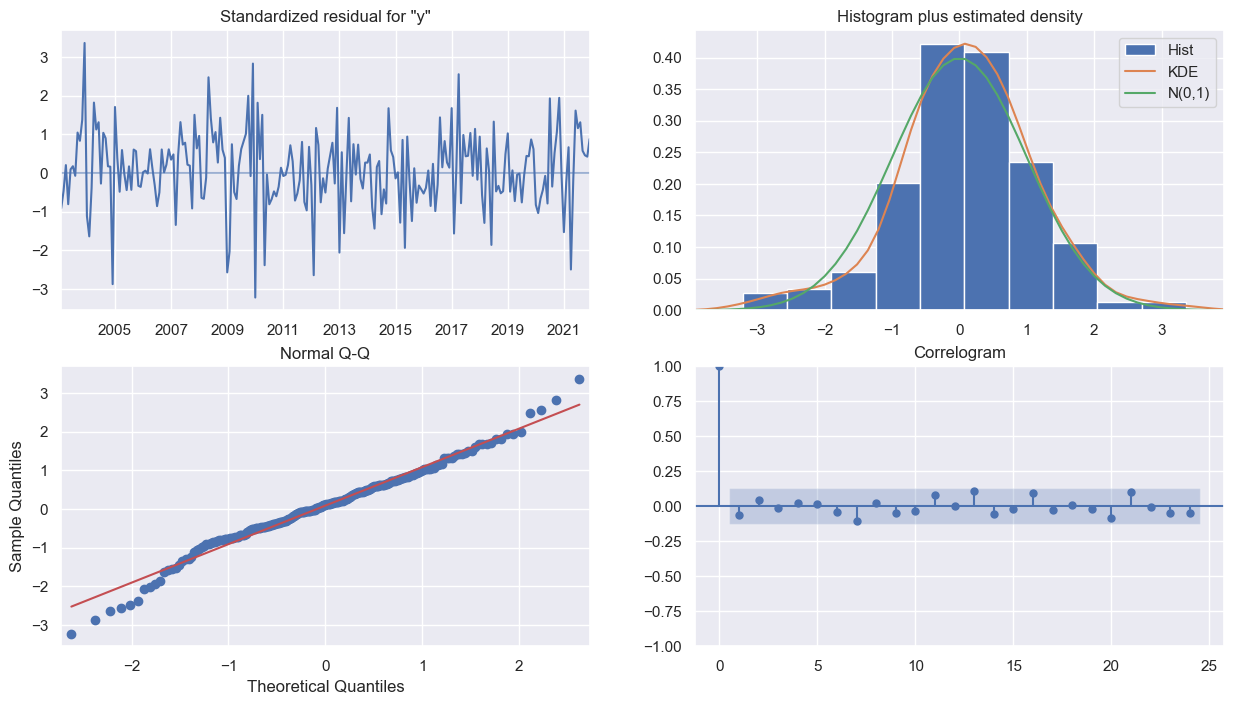

In [80]:
ax = res_arima1.plot_diagnostics(lags=24)

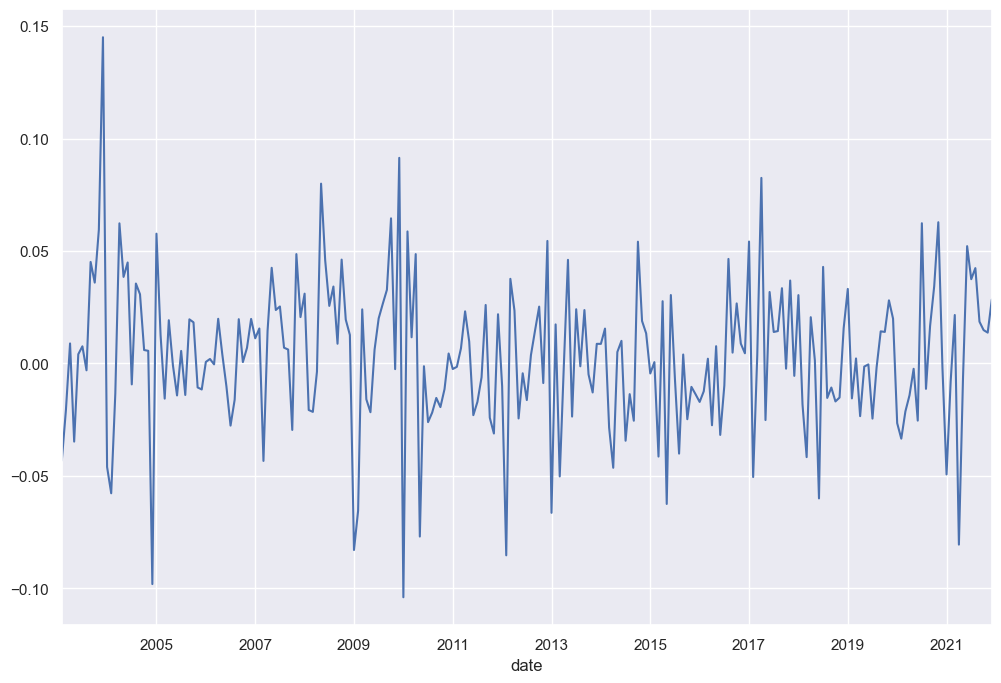

In [81]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima1.resid[1:].plot(ax=ax)

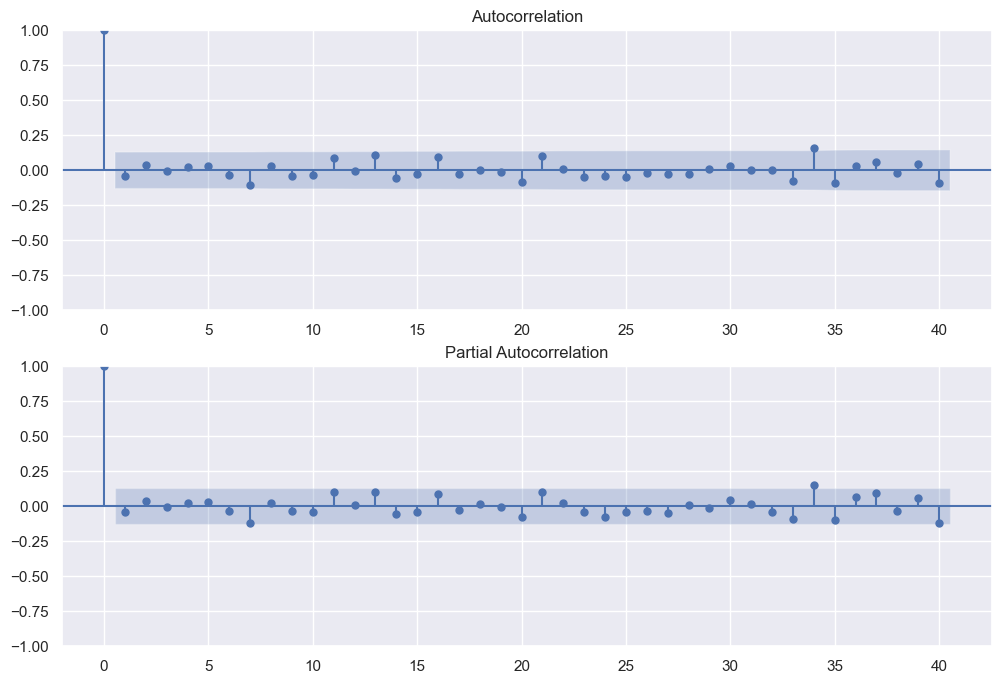

In [82]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima1.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima1.resid[1:], lags=40, ax=ax2)

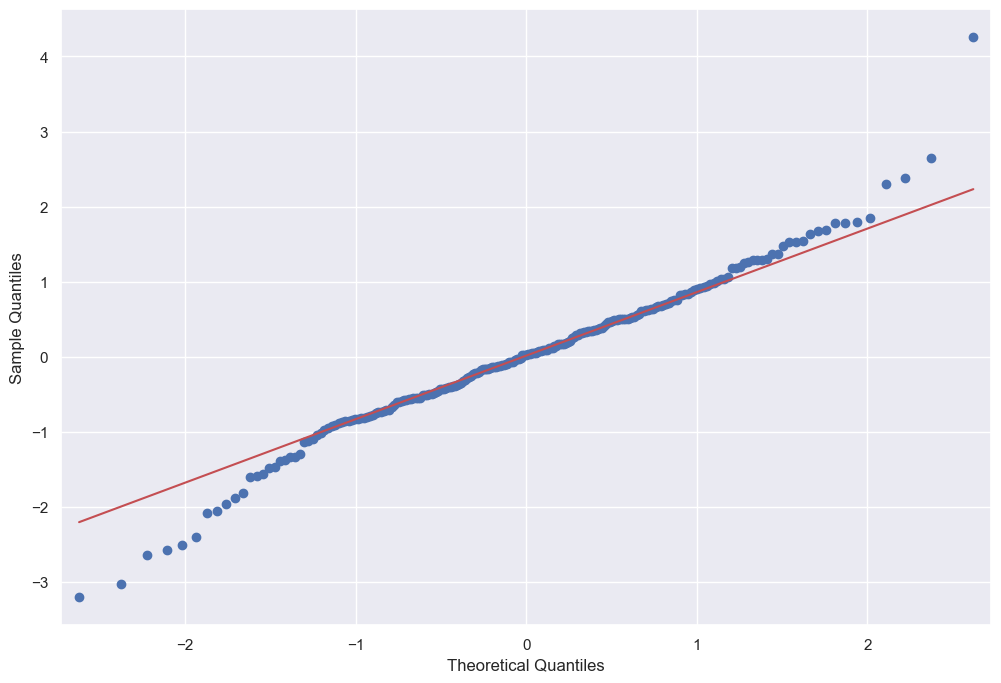

In [83]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima1.resid[1:], line="q", ax=ax, fit=True)

#### Previsões com Exógenas Previstas

In [84]:
previsoes['nome'].append('SARIMAX(0,1,1)(2,0,1)')
previsoes['modelo'].append(res_arima1)

In [85]:
y_arima1_pred = np.exp(res_arima1.forecast(12, exog=exog_test))
previsoes['previsoes'].append(y_arima1_pred)
y_arima1_pred

2022-01-01    1.737095e+10
2022-02-01    1.659894e+10
2022-03-01    1.702141e+10
2022-04-01    1.637094e+10
2022-05-01    1.680492e+10
2022-06-01    1.674804e+10
2022-07-01    1.771244e+10
2022-08-01    1.792371e+10
2022-09-01    1.812639e+10
2022-10-01    1.841089e+10
2022-11-01    1.910451e+10
2022-12-01    1.968017e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [86]:
RMSE_arima1 = mean_squared_error(icms_test, y_arima1_pred, squared=False)
previsoes['rmse'].append(RMSE_arima1)
RMSE_arima1

1406282836.353856

In [87]:
MAPE_arima1 = mean_absolute_percentage_error(icms_test, y_arima1_pred)
previsoes['mape'].append(MAPE_arima1)
MAPE_arima1

0.06200219535937443

In [88]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima1_pred, icms_test)])

#### Previsões com Exógenas Reais

In [89]:
previsoes['nome'].append('SARIMAX(0,1,1),(2,0,1) Real')
previsoes['modelo'].append(None)

In [90]:
y_arima3_pred = np.exp(res_arima1.forecast(12, exog=exog_reais_test))
previsoes['previsoes'].append(y_arima3_pred)
y_arima3_pred

2022-01-01    1.747349e+10
2022-02-01    1.674207e+10
2022-03-01    1.723390e+10
2022-04-01    1.657191e+10
2022-05-01    1.711422e+10
2022-06-01    1.713244e+10
2022-07-01    1.831906e+10
2022-08-01    1.822858e+10
2022-09-01    1.824647e+10
2022-10-01    1.829613e+10
2022-11-01    1.888455e+10
2022-12-01    1.947513e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [91]:
RMSE_arima3 = mean_squared_error(icms_test, y_arima3_pred, squared=False)
previsoes['rmse'].append(RMSE_arima3)
RMSE_arima3

1380866169.5724654

In [92]:
MAPE_arima3 = mean_absolute_percentage_error(icms_test, y_arima3_pred)
previsoes['mape'].append(MAPE_arima3)
MAPE_arima3

0.06583037062066767

In [93]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima3_pred, icms_test)])

### Modelo SARIMAX(0,1,1),(1,0,1) sugerido pelo critério de Schwartz

In [94]:
mod_arima2 = ARIMA(endog=icms_train, exog=exog_train, order=(0, 1, 1), seasonal_order=(1, 0, 1, 12))
res_arima2 = mod_arima2.fit()
print(res_arima2.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  228
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 450.326
Date:                          Mon, 21 Aug 2023   AIC                           -874.653
Time:                                  11:12:49   BIC                           -830.128
Sample:                              01-01-2003   HQIC                          -856.686
                                   - 12-01-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6.355e-05      0.001      0.051      0.959      -0.002       0.003
x2             0.0006      0.000      2.846      0.

#### Análise dos Resíduos

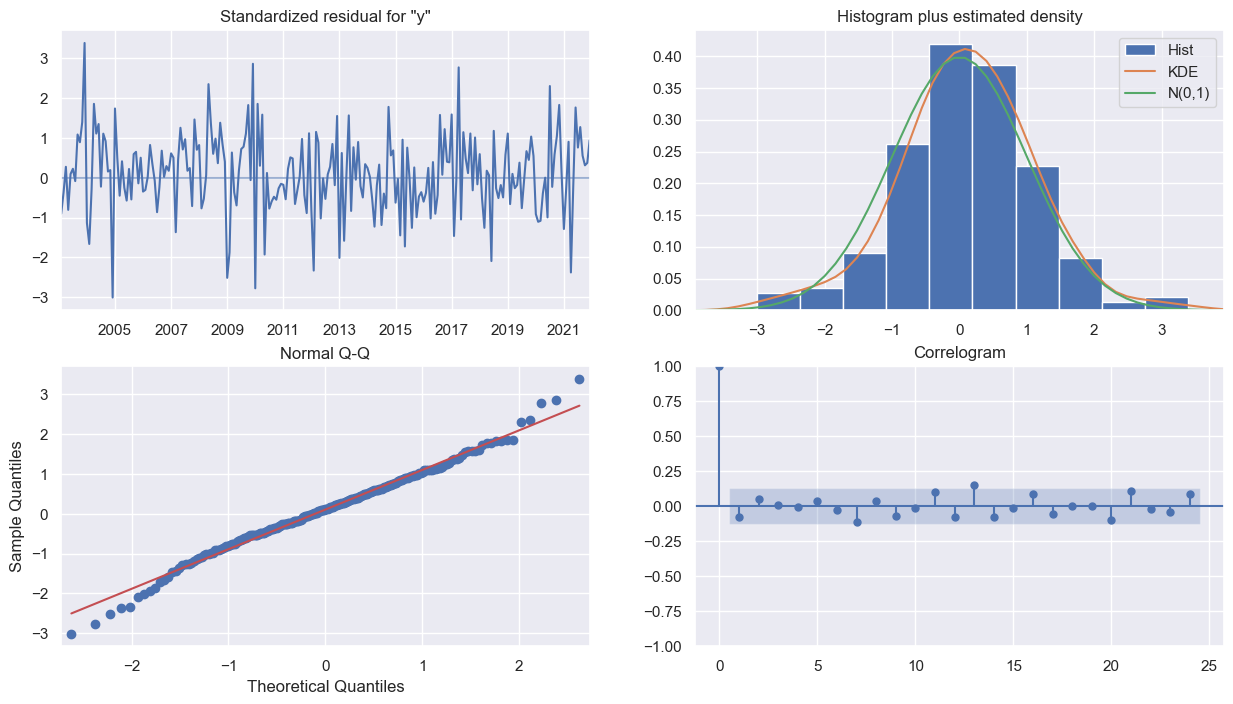

In [95]:
ax = res_arima2.plot_diagnostics(lags=24)

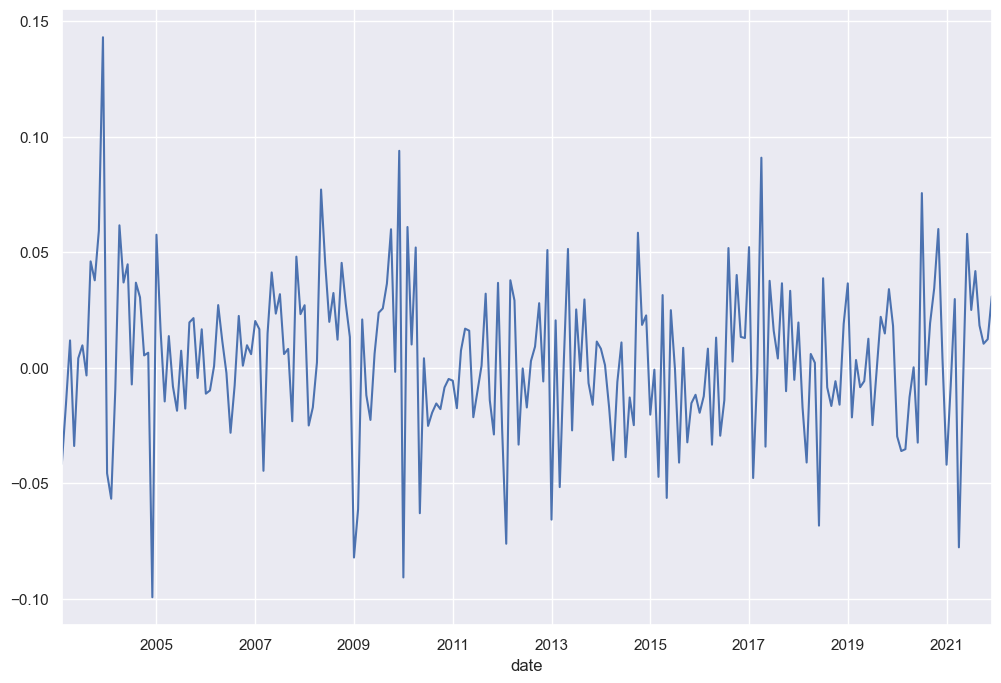

In [96]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima2.resid[1:].plot(ax=ax)

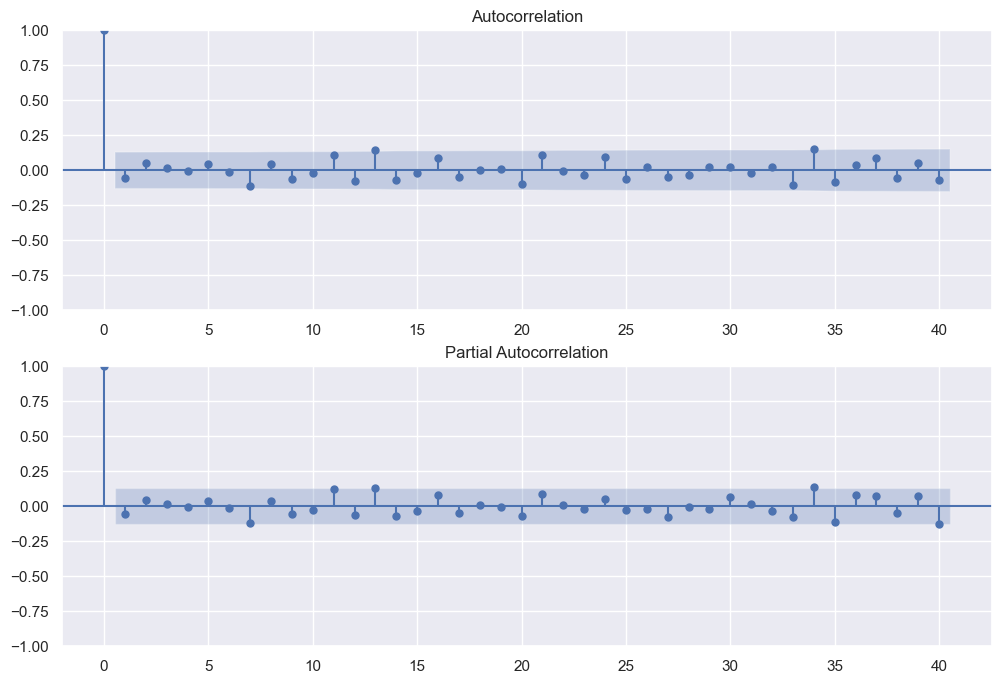

In [97]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima2.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima2.resid[1:], lags=40, ax=ax2)

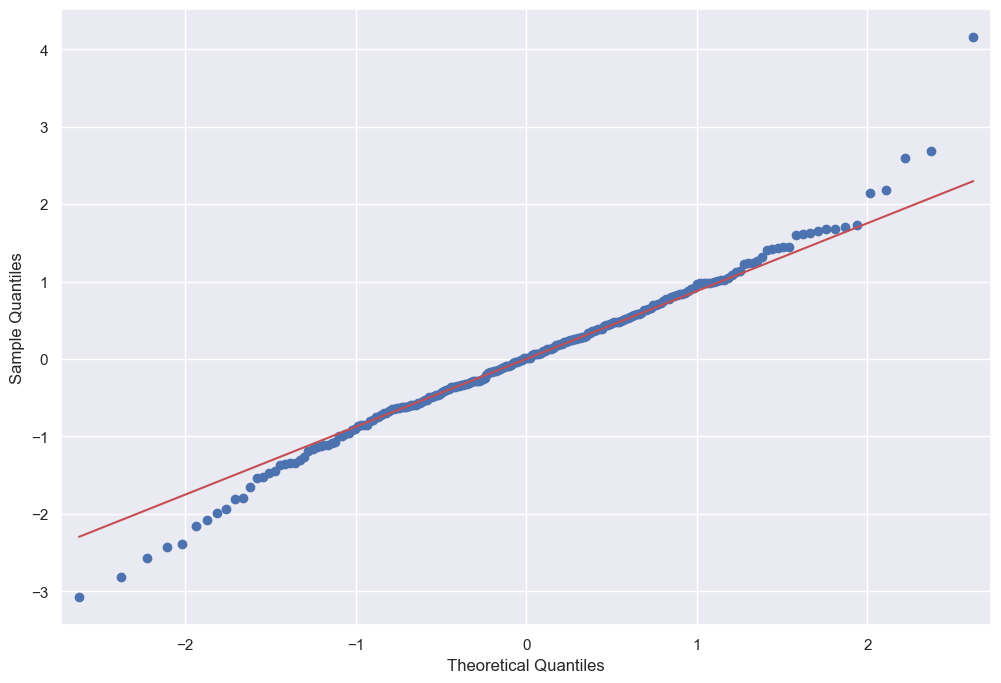

In [98]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima2.resid[1:], line="q", ax=ax, fit=True)

#### Previsões com Exógenas Previstas

In [99]:
previsoes['nome'].append('SARIMAX(0,1,1),(1,0,1)')
previsoes['modelo'].append(res_arima2)

In [100]:
y_arima2_pred = np.exp(res_arima2.forecast(12, exog=exog_test))
previsoes['previsoes'].append(y_arima2_pred)
y_arima2_pred

2022-01-01    1.736848e+10
2022-02-01    1.670314e+10
2022-03-01    1.717694e+10
2022-04-01    1.632253e+10
2022-05-01    1.684022e+10
2022-06-01    1.702180e+10
2022-07-01    1.775046e+10
2022-08-01    1.814532e+10
2022-09-01    1.829595e+10
2022-10-01    1.847752e+10
2022-11-01    1.906535e+10
2022-12-01    1.978741e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [101]:
RMSE_arima2 = mean_squared_error(icms_test, y_arima2_pred, squared=False)
previsoes['rmse'].append(RMSE_arima2)
RMSE_arima2

1451333103.3982964

In [102]:
MAPE_arima2 = mean_absolute_percentage_error(icms_test, y_arima2_pred)
previsoes['mape'].append(MAPE_arima2)
MAPE_arima2

0.06522898993726974

In [103]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima2_pred, icms_test)])

#### Previsões com as Exógenas Reais

In [104]:
previsoes['nome'].append('SARIMAX(0,1,1),(1,0,1) Real')
previsoes['modelo'].append(None)

In [105]:
y_arima4_pred = np.exp(res_arima2.forecast(12, exog=exog_reais_test))
previsoes['previsoes'].append(y_arima4_pred)
y_arima4_pred

2022-01-01    1.749246e+10
2022-02-01    1.679599e+10
2022-03-01    1.727709e+10
2022-04-01    1.642083e+10
2022-05-01    1.706775e+10
2022-06-01    1.733715e+10
2022-07-01    1.826703e+10
2022-08-01    1.834956e+10
2022-09-01    1.834243e+10
2022-10-01    1.833283e+10
2022-11-01    1.883711e+10
2022-12-01    1.952496e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [106]:
RMSE_arima4 = mean_squared_error(icms_test, y_arima4_pred, squared=False)
previsoes['rmse'].append(RMSE_arima4)
RMSE_arima4

1404728881.412266

In [107]:
MAPE_arima4 = mean_absolute_percentage_error(icms_test, y_arima4_pred)
previsoes['mape'].append(MAPE_arima4)
MAPE_arima4

0.06892626628607693

In [108]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima4_pred, icms_test)])

### Comparação dos Modelos SARIMAX com Endógenas Previstas e Reais

In [109]:
prev_arma_df = pd.DataFrame(data={previsoes['nome'][0]: previsoes['previsoes'][0],
                                 previsoes['nome'][1]: previsoes['previsoes'][1],
                                 previsoes['nome'][2]: previsoes['previsoes'][2],
                                 previsoes['nome'][3]: previsoes['previsoes'][3]})
prev_arma_df['real'] = icms_test
prev_arma_df

SARIMAX(0,1,1)(2,0,1)  SARIMAX(0,1,1),(2,0,1) Real  \
2022-01-01           1.737095e+10                 1.747349e+10   
2022-02-01           1.659894e+10                 1.674207e+10   
2022-03-01           1.702141e+10                 1.723390e+10   
2022-04-01           1.637094e+10                 1.657191e+10   
2022-05-01           1.680492e+10                 1.711422e+10   
2022-06-01           1.674804e+10                 1.713244e+10   
2022-07-01           1.771244e+10                 1.831906e+10   
2022-08-01           1.792371e+10                 1.822858e+10   
2022-09-01           1.812639e+10                 1.824647e+10   
2022-10-01           1.841089e+10                 1.829613e+10   
2022-11-01           1.910451e+10                 1.888455e+10   
2022-12-01           1.968017e+10                 1.947513e+10   

            SARIMAX(0,1,1),(1,0,1)  SARIMAX(0,1,1),(1,0,1) Real          real  
2022-01-01            1.736848e+10                 1.749246e+10  1.675250e+10  
2022-02-01            1.670314e+10                 1.679599e+10  1.582980e+10  
2022-03-01            1.717694e+10                 1.727709e+10  1.628352e+10  
2022-04-01            1.632253e+10                 1.642083e+10  1.682937e+10  
2022-05-01            1.684022e+10                 1.706775e+10  1.689841e+10  
2022-06-01            1.702180e+10                 1.733715e+10  1.697456e+10  
2022-07-01            1.775046e+10                 1.826703e+10  1.743210e+10  
2022-08-01            1.814532e+10                 1.834956e+10  1.756224e+10  
2022-09-01            1.829595e+10                 1.834243e+10  1.726287e+10  
2022-10-01            1.847752e+10                 1.833283e+10  1.565000e+10  
2022-11-01            1.906535e+10                 1.883711e+10  1.605000e+10  
2022-12-01            1.978741e+10                 1.952496e+10  1.767135e+10

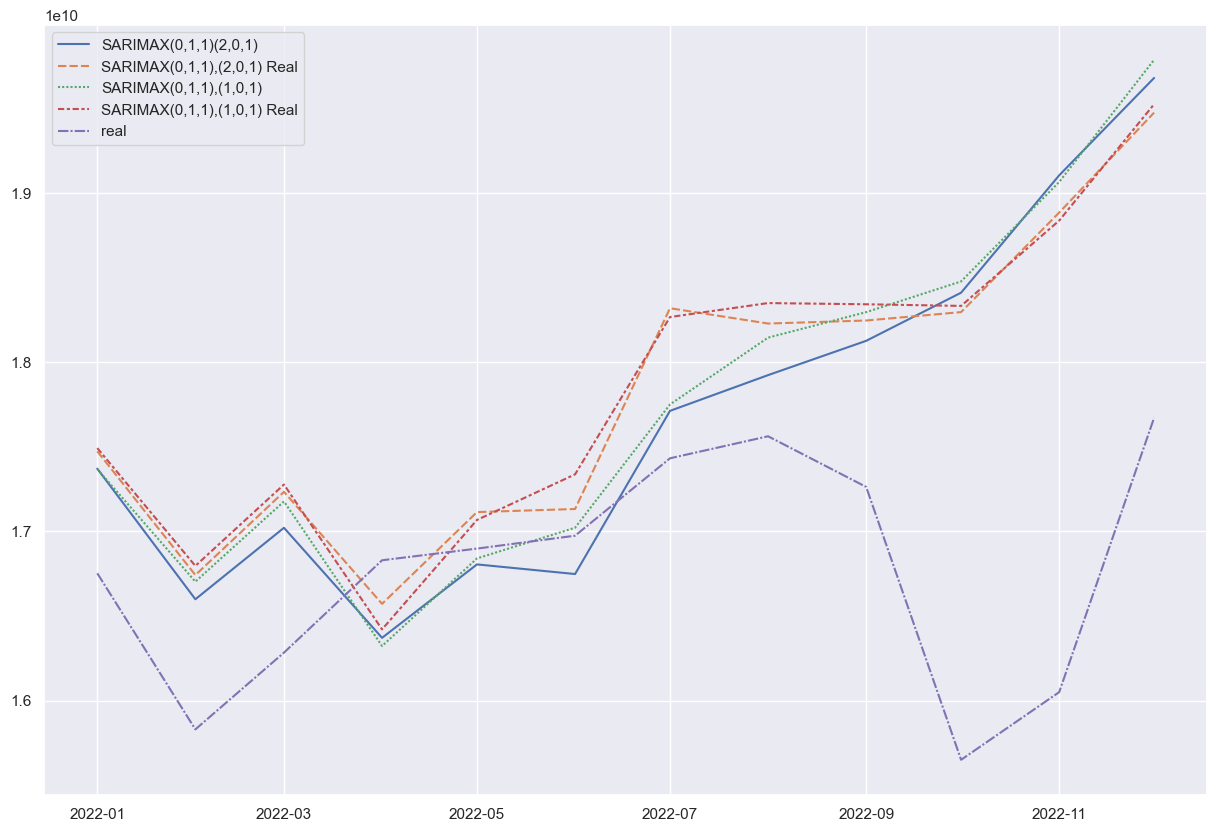

In [110]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_arma_df)

In [111]:
df_arima_rmse = pd.DataFrame(data=previsoes['rmse'][0:4], index= previsoes['nome'][0:4]).transpose()

In [112]:
df_arima_mape = pd.DataFrame(data=previsoes['mape'][0:4], index= previsoes['nome'][0:4]).transpose()

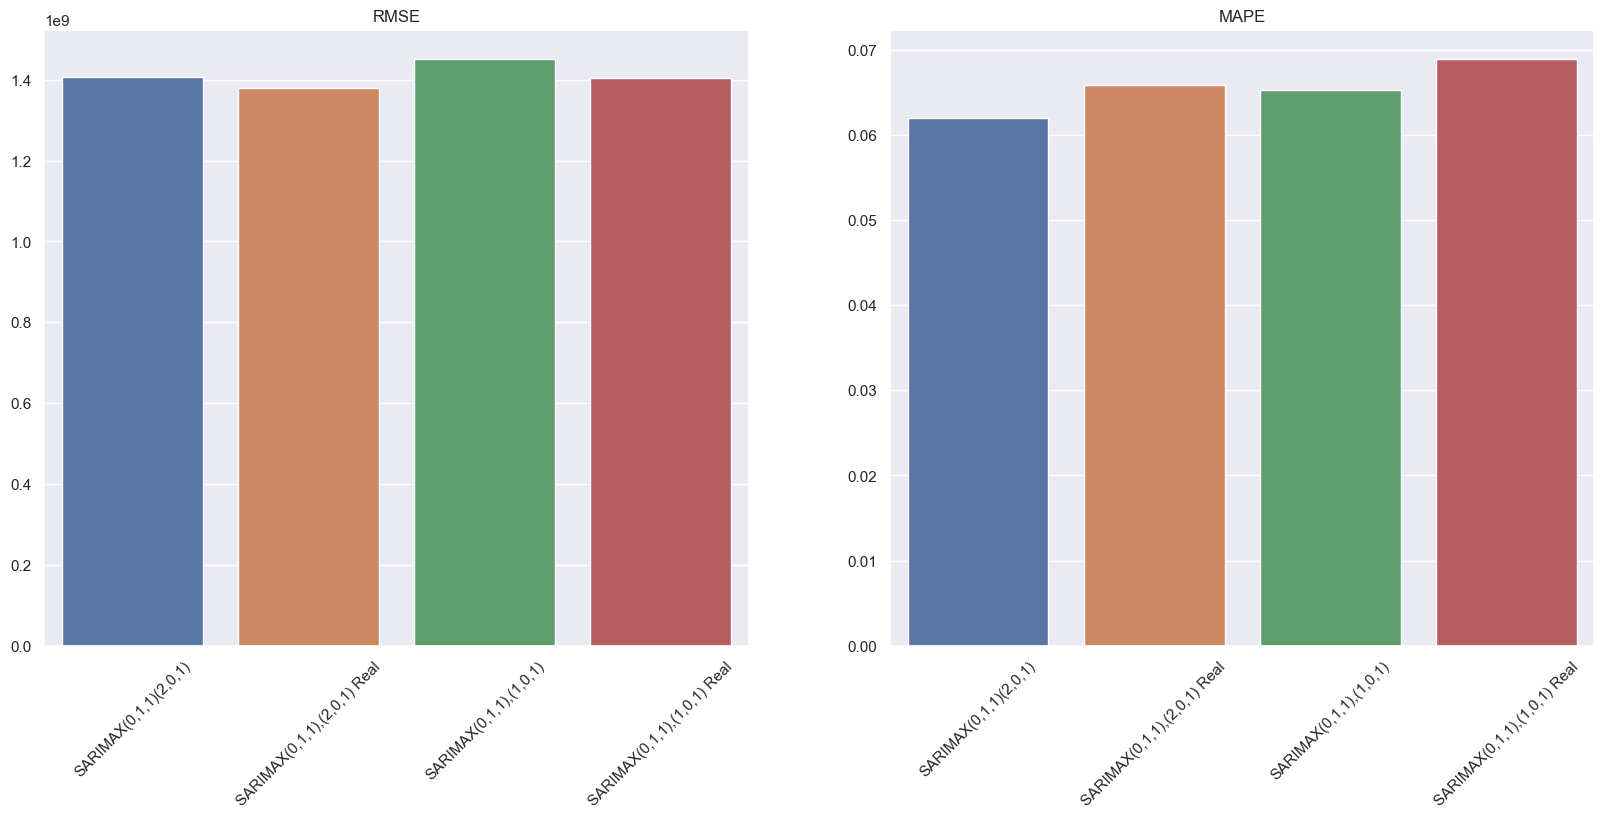

In [113]:
fig=plt.figure(figsize=(20, 8))
ax1=fig.add_subplot(121)
ax1 = sns.barplot(data=df_arima_rmse)
ax1.set_title('RMSE')
_ = plt.xticks(rotation=45)
ax2=fig.add_subplot(122)
ax2 = sns.barplot(data=df_arima_mape)
ax2.set_title('MAPE')
_ = plt.xticks(rotation=45)
plt.show()

## Modelo de Markov-Switching

A biblioteca statsmodel não tem implementado o método de forecast do modelo de Markov Switching. Por isso o forecast foi realizado no Ox e os dados estão sendo importados aqui.
Foram feitos 3 modelos usando as mesmas variáveis e 2 mudanças de regime:
- log icms em primeira diferença - Y
- constante - mudança de regime (*regime switching*)
- ibc-br real em primeira diferença - (*regime switching*) 
- igp-m real em segunda diferença - (*regime switching*) 
- dias úteis em nível - X (variável)
- 11 dummies sazonais centradas - X (variável)

E foram usados 3 tipos de variância
- variância fixa (*fixed variance*)
- mudança de variância (*switching variance*)
- componente média-variância (*mean-variance component*).

In [114]:
markov_forecast_df = pd.read_csv('forecast_markov.csv', delimiter=';', decimal=',')
markov_forecast_df = markov_forecast_df[-12:]

### Modelo com Variância Fixa

In [115]:
arq1 = open('./ox/22_results_multi_fixed_prev.txt', 'r')
print(arq1.read())
arq1.close()


Switching( 4) Modelling DLicms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/revisao/ox/variaveis_previsao_markov.xlsx
              The estimation sample is: 2003-03-01 - 2021-12-01

                Coefficient   Std.Error  t-value  t-prob
dias_uteis       0.00828187    0.003024     2.74   0.007
CSeasonal         -0.111468     0.01180    -9.45   0.000
CSeasonal_1       -0.107391     0.01487    -7.22   0.000
CSeasonal_2      -0.0998874     0.01721    -5.80   0.000
CSeasonal_3     -0.00977535     0.01253   -0.780   0.436
CSeasonal_4      -0.0863195     0.01161    -7.44   0.000
CSeasonal_5      -0.0526886     0.01201    -4.39   0.000
CSeasonal_6      -0.0859970     0.01360    -6.33   0.000
CSeasonal_7      -0.0632033     0.01180    -5.36   0.000
CSeasonal_8      -0.0341061     0.01206    -2.83   0.005
CSeasonal_9      -0.0580994     0.01183    -4.91   0.000
CSeasonal_10     -0.0602471     0.01348    -4.47   0.000
Constant(0)       -0.156055  

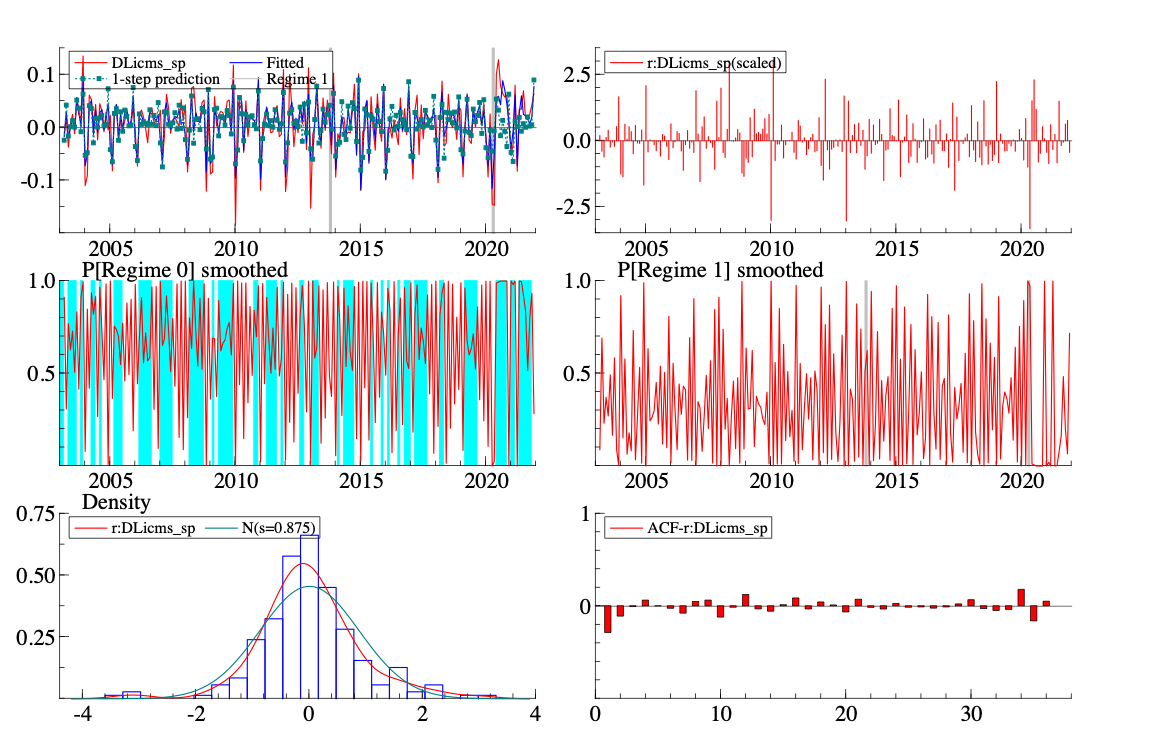

#### Previsões com Exógenas Previstas

In [116]:
y_markov_fixed_pred = np.exp(np.cumsum(markov_forecast_df['22_forecast_multi_fixed_prev'])+icms_train[-1])
y_markov_fixed_pred.index = icms_test.index
y_markov_fixed_pred

date
2022-01-01    1.750675e+10
2022-02-01    1.676622e+10
2022-03-01    1.710241e+10
2022-04-01    1.759338e+10
2022-05-01    1.751414e+10
2022-06-01    1.778654e+10
2022-07-01    1.773770e+10
2022-08-01    1.824344e+10
2022-09-01    1.861929e+10
2022-10-01    1.878027e+10
2022-11-01    1.873056e+10
2022-12-01    2.009981e+10
Name: 22_forecast_multi_fixed_prev, dtype: float64

In [117]:
previsoes['nome'].append('Markov-Fixed')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_fixed_pred)

In [118]:
RMSE_markov_fixed = mean_squared_error(icms_test, y_markov_fixed_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_fixed)
RMSE_markov_fixed

1555024345.5130928

In [119]:
MAPE_markov_fixed = mean_absolute_percentage_error(icms_test, y_markov_fixed_pred)
previsoes['mape'].append(MAPE_markov_fixed)
MAPE_markov_fixed

0.07695709211333653

In [120]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_fixed_pred, icms_test)])

#### Previsões com Exógenas Reais

In [121]:
y_markov_fixed_pred_r = np.exp(np.cumsum(markov_forecast_df['22_forecast_multi_fixed'])+icms_train[-1])
y_markov_fixed_pred_r.index = icms_test.index
y_markov_fixed_pred_r

date
2022-01-01    1.739458e+10
2022-02-01    1.679641e+10
2022-03-01    1.732578e+10
2022-04-01    1.752630e+10
2022-05-01    1.736732e+10
2022-06-01    1.763042e+10
2022-07-01    1.788963e+10
2022-08-01    1.835116e+10
2022-09-01    1.866676e+10
2022-10-01    1.863279e+10
2022-11-01    1.859393e+10
2022-12-01    2.030317e+10
Name: 22_forecast_multi_fixed, dtype: float64

In [122]:
previsoes['nome'].append('Markov-Fixed Real')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_fixed_pred_r)

In [123]:
RMSE_markov_fixed_r = mean_squared_error(icms_test, y_markov_fixed_pred_r, squared=False)
previsoes['rmse'].append(RMSE_markov_fixed_r)
RMSE_markov_fixed_r

1545594493.2034342

In [124]:
MAPE_markov_fixed_r = mean_absolute_percentage_error(icms_test, y_markov_fixed_pred_r)
previsoes['mape'].append(MAPE_markov_fixed_r)
MAPE_markov_fixed_r

0.07680935860597227

In [125]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_fixed_pred_r, icms_test)])

### Modelo com mudança da Variância

In [126]:
arq2 = open('./ox/22_results_multi_var_prev.txt', 'r')
print(arq2.read())
arq2.close()


Switching( 5) Modelling DLicms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/revisao/ox/variaveis_previsao_markov.xlsx
              The estimation sample is: 2003-03-01 - 2021-12-01

                Coefficient   Std.Error  t-value  t-prob
dias_uteis        0.0122092    0.002601     4.69   0.000
CSeasonal        -0.0571874     0.01234    -4.63   0.000
CSeasonal_1      -0.0990276     0.01198    -8.26   0.000
CSeasonal_2      -0.0461487     0.01344    -3.43   0.001
CSeasonal_3       0.0174788    0.009686     1.80   0.073
CSeasonal_4      -0.0616174     0.01004    -6.14   0.000
CSeasonal_5      -0.0365472    0.009919    -3.68   0.000
CSeasonal_6      -0.0593045     0.01023    -5.79   0.000
CSeasonal_7      -0.0471353    0.009562    -4.93   0.000
CSeasonal_8      -0.0117433    0.009425    -1.25   0.214
CSeasonal_9      -0.0326074    0.009338    -3.49   0.001
CSeasonal_10     -0.0265912     0.01068    -2.49   0.014
Constant(0)       -0.243869  

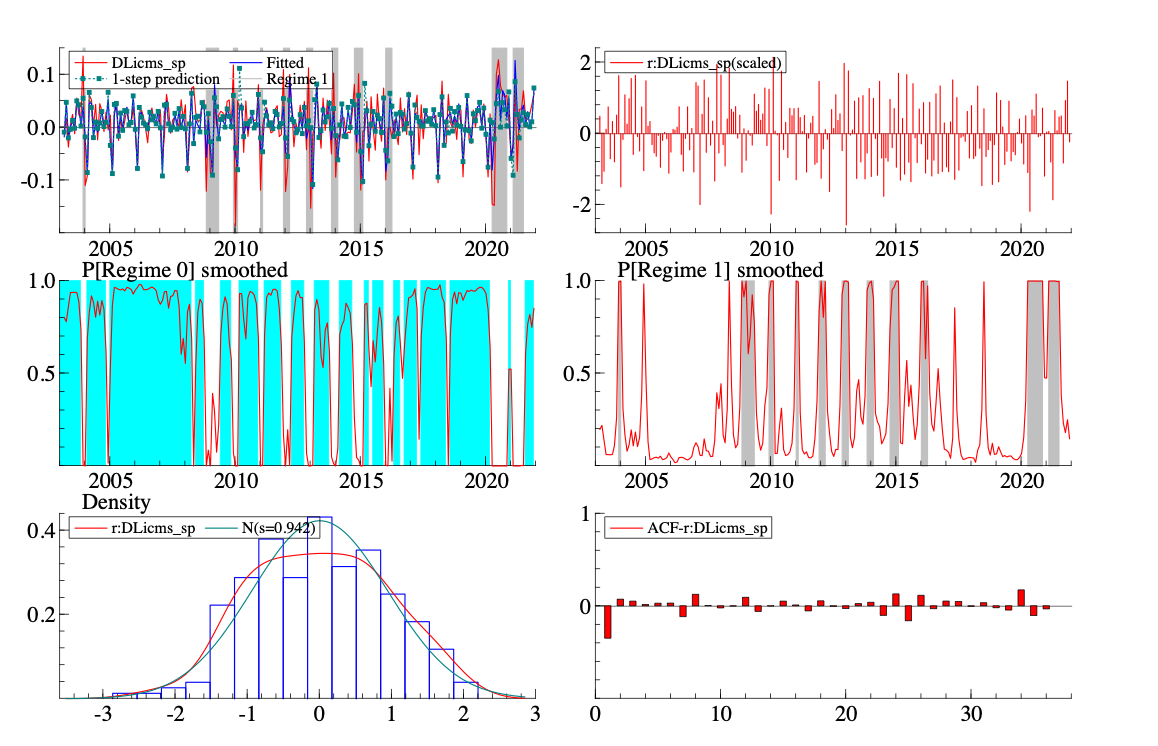

#### Previsões com Exógenas Previstas

In [127]:
y_markov_switching_pred = np.exp(np.cumsum(markov_forecast_df['22_forecast_multi_var_prev'])+icms_train[-1])
y_markov_switching_pred.index = icms_test.index
y_markov_switching_pred

date
2022-01-01    1.795053e+10
2022-02-01    1.684733e+10
2022-03-01    1.749154e+10
2022-04-01    1.799632e+10
2022-05-01    1.796044e+10
2022-06-01    1.809238e+10
2022-07-01    1.799953e+10
2022-08-01    1.846622e+10
2022-09-01    1.887274e+10
2022-10-01    1.891964e+10
2022-11-01    1.896344e+10
2022-12-01    1.995582e+10
Name: 22_forecast_multi_var_prev, dtype: float64

In [128]:
previsoes['nome'].append('Markov-Switching-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_switching_pred)

In [129]:
RMSE_markov_switching = mean_squared_error(icms_test, y_markov_switching_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_switching)
RMSE_markov_switching

1727172195.2151222

In [130]:
MAPE_markov_switching = mean_absolute_percentage_error(icms_test, y_markov_switching_pred)
previsoes['mape'].append(MAPE_markov_switching)
MAPE_markov_switching

0.09208512547046187

In [131]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_switching_pred, icms_test)])

#### Previsões com Exógenas Reais

In [132]:
y_markov_switching_pred_r = np.exp(np.cumsum(markov_forecast_df['22_forecast_multi_var'])+icms_train[-1])
y_markov_switching_pred_r.index = icms_test.index
y_markov_switching_pred_r

date
2022-01-01    1.772140e+10
2022-02-01    1.657397e+10
2022-03-01    1.713703e+10
2022-04-01    1.730075e+10
2022-05-01    1.713595e+10
2022-06-01    1.723464e+10
2022-07-01    1.735095e+10
2022-08-01    1.784030e+10
2022-09-01    1.834567e+10
2022-10-01    1.843863e+10
2022-11-01    1.864422e+10
2022-12-01    1.993111e+10
Name: 22_forecast_multi_var, dtype: float64

In [133]:
previsoes['nome'].append('Markov-Switching-Var Real')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_switching_pred_r)

In [134]:
RMSE_markov_switching_r = mean_squared_error(icms_test, y_markov_switching_pred_r, squared=False)
previsoes['rmse'].append(RMSE_markov_switching_r)
RMSE_markov_switching_r

1397516823.258954

In [135]:
MAPE_markov_switching_r = mean_absolute_percentage_error(icms_test, y_markov_switching_pred_r)
previsoes['mape'].append(MAPE_markov_switching_r)
MAPE_markov_switching_r

0.06379681644497637

In [136]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_switching_pred_r, icms_test)])

### Componente Média-Variância

In [137]:
arq3 = open('./ox/22_results_multi_mean_var_prev.txt', 'r')
print(arq3.read())
arq3.close()


Switching( 6) Modelling DLicms_sp by MS_Component(2, 2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/revisao/ox/variaveis_previsao_markov.xlsx
              The estimation sample is: 2003-03-01 - 2021-12-01

                Coefficient   Std.Error  t-value  t-prob
dias_uteis        0.0118064    0.001607     7.34   0.000
CSeasonal        -0.0991486     0.01627    -6.09   0.000
CSeasonal_1       -0.104224    0.009184    -11.3   0.000
CSeasonal_2      -0.0495728    0.008044    -6.16   0.000
CSeasonal_3      0.00771271    0.007884    0.978   0.329
CSeasonal_4      -0.0543568    0.007319    -7.43   0.000
CSeasonal_5      -0.0476456    0.007836    -6.08   0.000
CSeasonal_6      -0.0724977    0.008135    -8.91   0.000
CSeasonal_7      -0.0534669    0.007390    -7.24   0.000
CSeasonal_8      -0.0168900    0.008171    -2.07   0.040
CSeasonal_9      -0.0459084    0.008472    -5.42   0.000
CSeasonal_10     -0.0308459    0.007294    -4.23   0.000
Constant(0)     

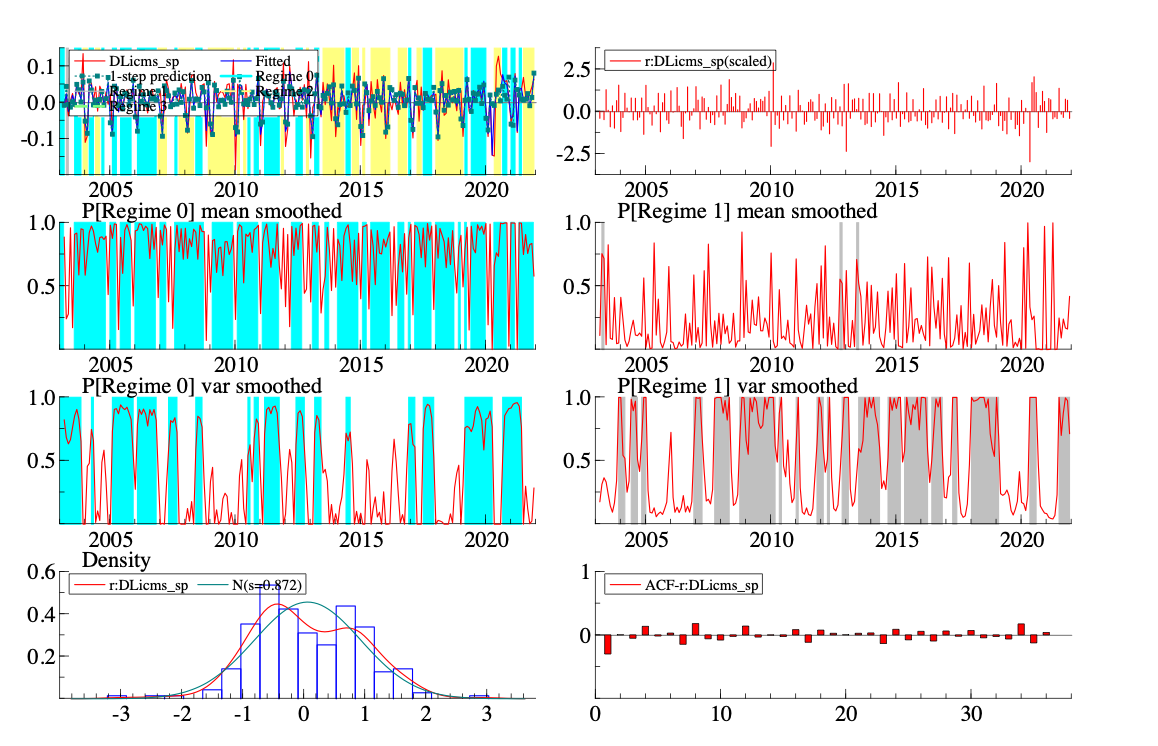

#### Previsões com Exógenas Previstas

In [138]:
y_markov_mean_var_pred = np.exp(np.cumsum(markov_forecast_df['22_forecast_multi_mean_var_prev'])+icms_train[-1])
y_markov_mean_var_pred.index = icms_test.index
y_markov_mean_var_pred

date
2022-01-01    1.743191e+10
2022-02-01    1.643070e+10
2022-03-01    1.711264e+10
2022-04-01    1.759183e+10
2022-05-01    1.780196e+10
2022-06-01    1.787043e+10
2022-07-01    1.766448e+10
2022-08-01    1.812584e+10
2022-09-01    1.861435e+10
2022-10-01    1.859864e+10
2022-11-01    1.875402e+10
2022-12-01    1.992024e+10
Name: 22_forecast_multi_mean_var_prev, dtype: float64

In [139]:
previsoes['nome'].append('Markov-Mean-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_mean_var_pred)

In [140]:
RMSE_markov_mean_var = mean_squared_error(icms_test, y_markov_mean_var_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_mean_var)
RMSE_markov_mean_var

1499231207.6940703

In [141]:
MAPE_markov_mean_var = mean_absolute_percentage_error(icms_test, y_markov_mean_var_pred)
previsoes['mape'].append(MAPE_markov_mean_var)
MAPE_markov_mean_var

0.074070389782447

In [142]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_mean_var_pred, icms_test)])

#### Previsões com Exógenas Reais

In [143]:
y_markov_mean_var_pred_r = np.exp(np.cumsum(markov_forecast_df['22_forecast_multi_mean_var'])+icms_train[-1])
y_markov_mean_var_pred_r.index = icms_test.index
y_markov_mean_var_pred_r

date
2022-01-01    1.737547e+10
2022-02-01    1.662590e+10
2022-03-01    1.756064e+10
2022-04-01    1.800500e+10
2022-05-01    1.823417e+10
2022-06-01    1.832216e+10
2022-07-01    1.831277e+10
2022-08-01    1.868906e+10
2022-09-01    1.900211e+10
2022-10-01    1.868929e+10
2022-11-01    1.870516e+10
2022-12-01    2.001918e+10
Name: 22_forecast_multi_mean_var, dtype: float64

In [144]:
previsoes['nome'].append('Markov-Mean-Var Real')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_mean_var_pred_r)

In [145]:
RMSE_markov_mean_var_r = mean_squared_error(icms_test, y_markov_mean_var_pred_r, squared=False)
previsoes['rmse'].append(RMSE_markov_mean_var_r)
RMSE_markov_mean_var_r

1695706013.193533

In [146]:
MAPE_markov_mean_var_r = mean_absolute_percentage_error(icms_test, y_markov_mean_var_pred_r)
previsoes['mape'].append(MAPE_markov_mean_var_r)
MAPE_markov_mean_var_r

0.09184392024844318

In [147]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_mean_var_pred_r, icms_test)])

### Comparação dos Modelos de Markov com Endógenas Previstas e Reais

In [148]:
previsoes['nome']

['SARIMAX(0,1,1)(2,0,1)',
 'SARIMAX(0,1,1),(2,0,1) Real',
 'SARIMAX(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(1,0,1) Real',
 'Markov-Fixed',
 'Markov-Fixed Real',
 'Markov-Switching-Var',
 'Markov-Switching-Var Real',
 'Markov-Mean-Var',
 'Markov-Mean-Var Real']

In [149]:
prev_markov_df = pd.DataFrame(data={previsoes['nome'][4]: previsoes['previsoes'][4],
                                    previsoes['nome'][5]: previsoes['previsoes'][5],
                                    previsoes['nome'][6]: previsoes['previsoes'][6],
                                    previsoes['nome'][7]: previsoes['previsoes'][7],
                                    previsoes['nome'][8]: previsoes['previsoes'][8],
                                    previsoes['nome'][9]: previsoes['previsoes'][9]
                                   })
prev_markov_df['real'] = icms_test
prev_markov_df

Markov-Fixed  Markov-Fixed Real  Markov-Switching-Var  \
date                                                                
2022-01-01  1.750675e+10       1.739458e+10          1.795053e+10   
2022-02-01  1.676622e+10       1.679641e+10          1.684733e+10   
2022-03-01  1.710241e+10       1.732578e+10          1.749154e+10   
2022-04-01  1.759338e+10       1.752630e+10          1.799632e+10   
2022-05-01  1.751414e+10       1.736732e+10          1.796044e+10   
2022-06-01  1.778654e+10       1.763042e+10          1.809238e+10   
2022-07-01  1.773770e+10       1.788963e+10          1.799953e+10   
2022-08-01  1.824344e+10       1.835116e+10          1.846622e+10   
2022-09-01  1.861929e+10       1.866676e+10          1.887274e+10   
2022-10-01  1.878027e+10       1.863279e+10          1.891964e+10   
2022-11-01  1.873056e+10       1.859393e+10          1.896344e+10   
2022-12-01  2.009981e+10       2.030317e+10          1.995582e+10   

            Markov-Switching-Var Real  Markov-Mean-Var  Markov-Mean-Var Real  \
date                                                                           
2022-01-01               1.772140e+10     1.743191e+10          1.737547e+10   
2022-02-01               1.657397e+10     1.643070e+10          1.662590e+10   
2022-03-01               1.713703e+10     1.711264e+10          1.756064e+10   
2022-04-01               1.730075e+10     1.759183e+10          1.800500e+10   
2022-05-01               1.713595e+10     1.780196e+10          1.823417e+10   
2022-06-01               1.723464e+10     1.787043e+10          1.832216e+10   
2022-07-01               1.735095e+10     1.766448e+10          1.831277e+10   
2022-08-01               1.784030e+10     1.812584e+10          1.868906e+10   
2022-09-01               1.834567e+10     1.861435e+10          1.900211e+10   
2022-10-01               1.843863e+10     1.859864e+10          1.868929e+10   
2022-11-01               1.864422e+10     1.875402e+10          1.870516e+10   
2022-12-01               1.993111e+10     1.992024e+10          2.001918e+10   

                    real  
date                      
2022-01-01  1.675250e+10  
2022-02-01  1.582980e+10  
2022-03-01  1.628352e+10  
2022-04-01  1.682937e+10  
2022-05-01  1.689841e+10  
2022-06-01  1.697456e+10  
2022-07-01  1.743210e+10  
2022-08-01  1.756224e+10  
2022-09-01  1.726287e+10  
2022-10-01  1.565000e+10  
2022-11-01  1.605000e+10  
2022-12-01  1.767135e+10

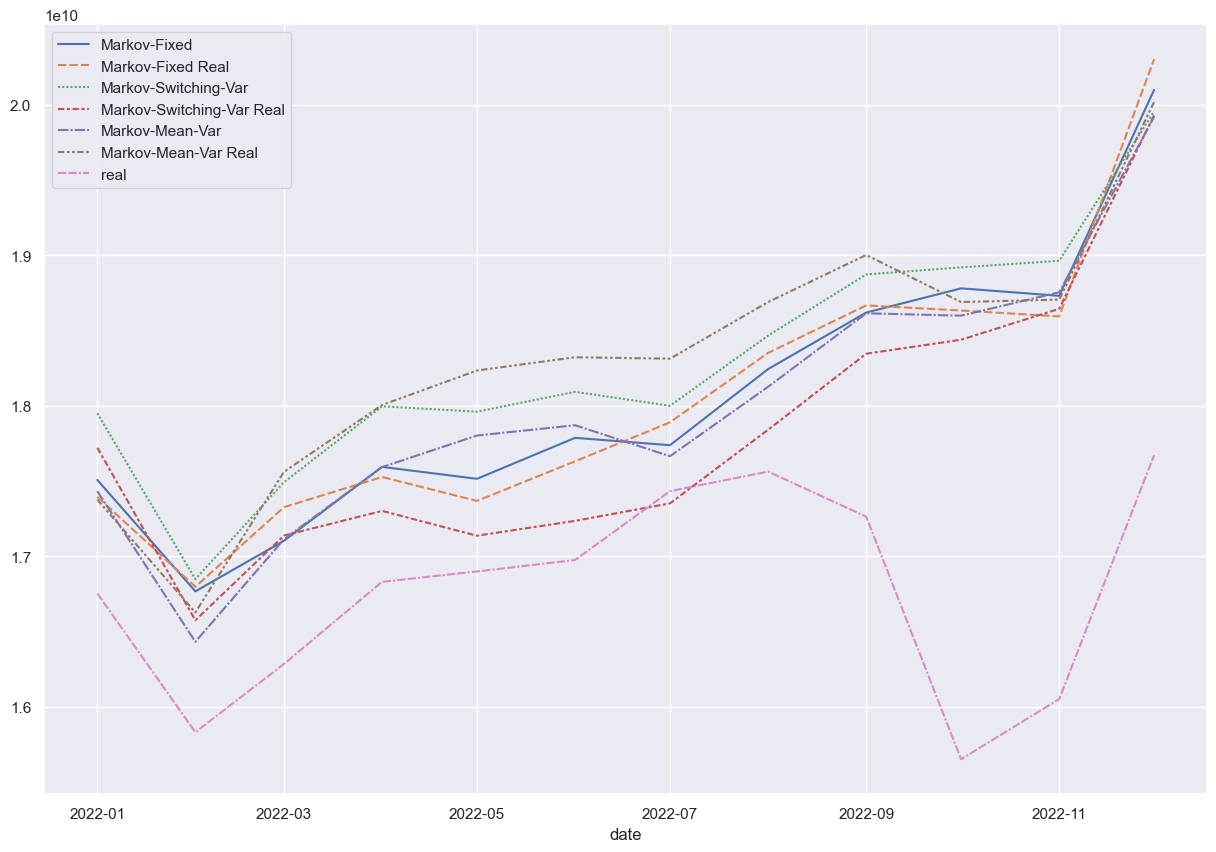

In [150]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_markov_df)

In [151]:
df_markov_rmse = pd.DataFrame(data=previsoes['rmse'][4:10], index= previsoes['nome'][4:10]).transpose()

In [152]:
df_markov_mape = pd.DataFrame(data=previsoes['mape'][4:10], index= previsoes['nome'][4:10]).transpose()

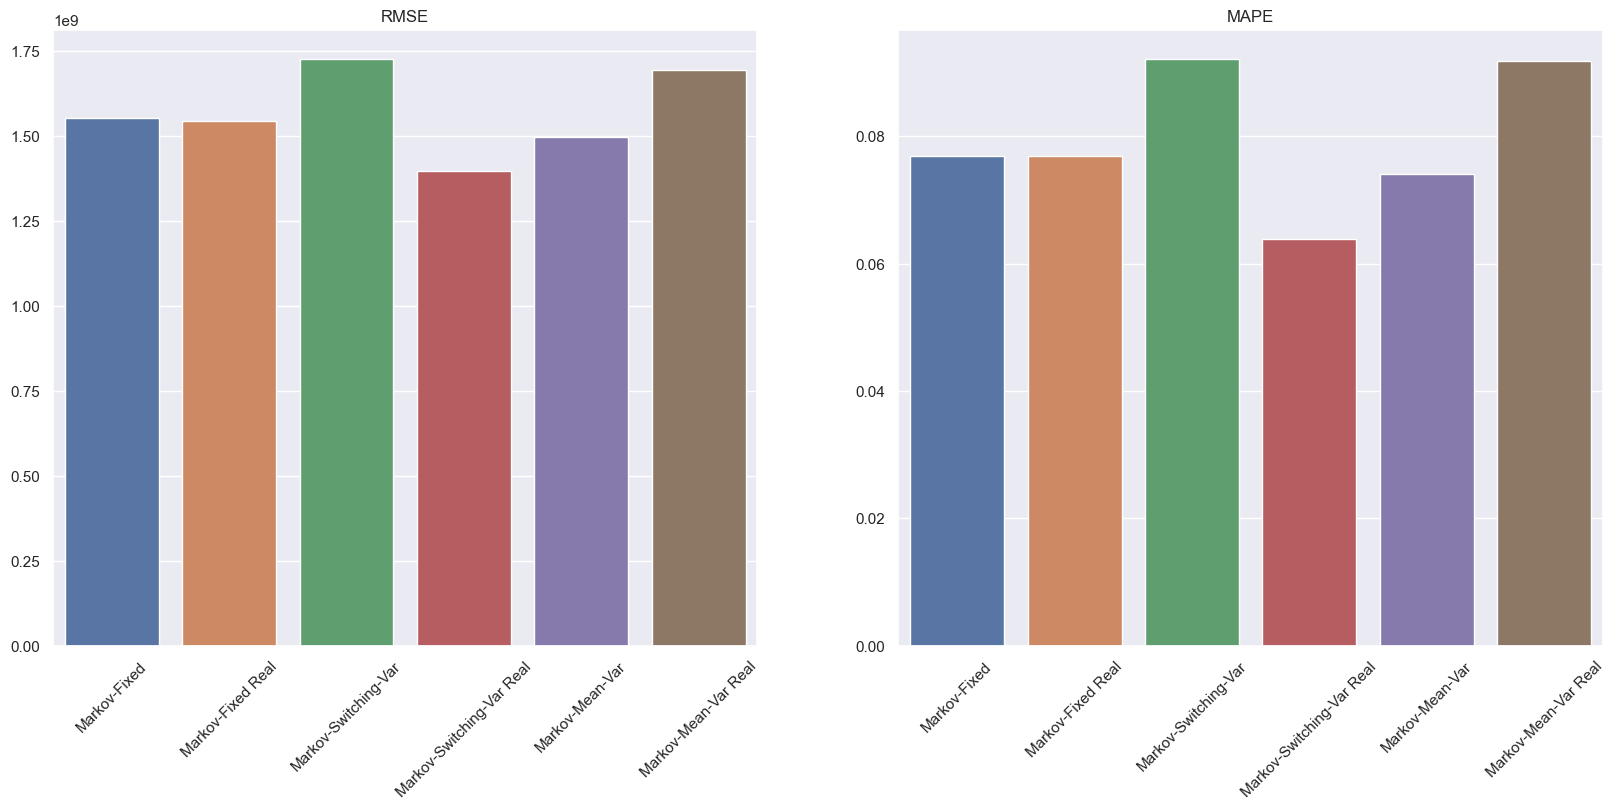

In [153]:
fig=plt.figure(figsize=(20, 8))
ax1=fig.add_subplot(121)
ax1 = sns.barplot(data=df_markov_rmse)
ax1.set_title('RMSE')
_ = plt.xticks(rotation=45)
ax2=fig.add_subplot(122)
ax2 = sns.barplot(data=df_markov_mape)
ax2.set_title('MAPE')
_ = plt.xticks(rotation=45)
plt.show()

## Modelos RNN LSTM
Redes Neurais Recorrentes com neurônios Long Short-Term Memory

### Montagem da Série com as Variáveis Exógenas Previstas.
As redes neurais precisam de conjuntos de características e de etiquetas separados. As variáveis exógenas serão o conjunto de características e a variável endógena será o conjunto de etiquetas.

In [154]:
X_data = np.append(exog[:,:4], np.roll(exog[:,:4], 1, axis = 0), axis = 1)
X_data = np.append(X_data, np.roll(exog[:,:4], 2, axis = 0), axis = 1)[2:]
Y_data = icms_ts[2:].to_numpy()

In [155]:
X_data.shape, Y_data.shape

((238, 12), (238,))

### Montagem da Série com as Variáveis Exógenas Reais

In [156]:
X_reais_data = np.append(exog_reais[:,:4], np.roll(exog_reais[:,:4], 1, axis = 0), axis = 1)
X_reais_data = np.append(X_reais_data, np.roll(exog_reais[:,:4], 2, axis = 0), axis = 1)[2:]

In [157]:
X_reais_data.shape

(238, 12)

#### Normalização dos Dados
Serão normalizados usando-se min-max. Apenas as features, a variável target não será normalizada. Os dados serão dividos em treno, validação e teste para a normalização, de modo que o fit seja feito somente nos dados de treino, aumentando-se assim a probabilidade de generalização do modelo.

In [158]:
X_train = X_data[:-24]
X_val = X_data[-24:-12]
X_test = X_data[-12:]
print(X_train.shape, X_val.shape, X_test.shape)
Y_train = Y_data[:-24]
Y_val = Y_data[-24:-12]
Y_test = np.exp(Y_data[-12:]) # tirando o log
print(Y_train.shape, Y_val.shape, Y_test.shape)

(214, 12) (12, 12) (12, 12)
(214,) (12,) (12,)


In [159]:
X_reais_test = X_reais_data[-12:]
print(X_reais_test.shape)

(12, 12)


In [160]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
# índice dos atributos numéricos
num_atrib = list(range(X_train.shape[1]))
print('numéricas', num_atrib)

enc_x = ColumnTransformer([('min-max',MinMaxScaler(), num_atrib)], verbose=True)

print(enc_x)
X_train_std = enc_x.fit_transform(X_train)
X_val_std = enc_x.transform(X_val)
X_test_std = enc_x.transform(X_test)
X_reais_test_std = enc_x.transform(X_reais_test)

print(X_train_std.shape)
print(X_val_std.shape)
print(X_test_std.shape)
print(X_reais_test_std.shape)

numéricas [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ColumnTransformer(transformers=[('min-max', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])],
                  verbose=True)
[ColumnTransformer] ....... (1 of 1) Processing min-max, total=   0.0s
(214, 12)
(12, 12)
(12, 12)
(12, 12)


In [161]:
x_train = X_train_std.reshape(X_train_std.shape[0], X_train_std.shape[1], 1)
x_val = X_val_std.reshape(X_val_std.shape[0], X_val_std.shape[1], 1)
x_test = X_test_std.reshape(X_test_std.shape[0], X_test_std.shape[1], 1)
x_reais_test = X_reais_test_std.reshape(X_reais_test_std.shape[0], X_reais_test_std.shape[1], 1)
print(x_train.shape, x_val.shape, x_test.shape, x_reais_test.shape)

y_train = Y_train.reshape(Y_train.shape[0], 1)
y_val = Y_val.reshape(Y_val.shape[0], 1)
y_test = Y_test.reshape(Y_test.shape[0], 1)
print(y_train.shape, y_val.shape, y_test.shape)

(214, 12, 1) (12, 12, 1) (12, 12, 1) (12, 12, 1)
(214, 1) (12, 1) (12, 1)


### Criando o modelo LSTM

In [162]:
# importando as bibliotecas do Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [163]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25)
early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

#### Arquitetura da Rede

In [164]:
# Épocas
EPOCHS = 1000
neuronios = 600

# Imstanciação do modelo
model = Sequential()

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=0.15,
        input_shape = (12, 1), return_sequences = True,
        units = neuronios))

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=0.15,
        input_shape = (12, 1), return_sequences = True,
        units = neuronios))

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=0.15,
        input_shape = (12, 1), return_sequences = False,
        units = neuronios))

# Adicionar a camada de saída com 1 neurônio linear
model.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model.compile(loss = 'mape', optimizer = Adam(learning_rate=1e-5))

In [165]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 600)           1444800   
                                                                 
 lstm_1 (LSTM)               (None, 12, 600)           2882400   
                                                                 
 lstm_2 (LSTM)               (None, 600)               2882400   
                                                                 
 dense (Dense)               (None, 1)                 601       
                                                                 
Total params: 7210201 (27.50 MB)
Trainable params: 7210201 (27.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [166]:
# History object for plotting our model loss by epoch
history = model.fit(x_train, y_train, batch_size = 16, 
                    epochs = EPOCHS, validation_data = (x_val, y_val),
                    callbacks = [rlrop, early_stop])

Epoch 1/1000
14/14 [==============================] - 12s 332ms/step - loss: 99.9317 - val_loss: 99.6821 - lr: 1.0000e-05
Epoch 2/1000
14/14 [==============================] - 3s 233ms/step - loss: 99.7223 - val_loss: 99.2695 - lr: 1.0000e-05
Epoch 3/1000
14/14 [==============================] - 4s 261ms/step - loss: 99.4396 - val_loss: 98.6897 - lr: 1.0000e-05
Epoch 4/1000
14/14 [==============================] - 3s 236ms/step - loss: 99.0435 - val_loss: 97.7646 - lr: 1.0000e-05
Epoch 5/1000
14/14 [==============================] - 4s 252ms/step - loss: 98.4108 - val_loss: 96.1466 - lr: 1.0000e-05
Epoch 6/1000
14/14 [==============================] - 3s 240ms/step - loss: 97.1929 - val_loss: 93.0079 - lr: 1.0000e-05
Epoch 7/1000
14/14 [==============================] - 3s 226ms/step - loss: 94.9710 - val_loss: 86.2734 - lr: 1.0000e-05
Epoch 8/1000
14/14 [==============================] - 3s 226ms/step - loss: 89.6008 - val_loss: 70.6304 - lr: 1.0000e-05
Epoch 9/1000
14/14 [===========

14/14 [==============================] - 3s 235ms/step - loss: 0.9082 - val_loss: 1.1144 - lr: 1.0000e-07
Epoch 70/1000
14/14 [==============================] - 3s 225ms/step - loss: 0.8714 - val_loss: 1.1198 - lr: 1.0000e-07
Epoch 71/1000
14/14 [==============================] - 3s 242ms/step - loss: 0.9036 - val_loss: 1.1243 - lr: 1.0000e-07
Epoch 72/1000
14/14 [==============================] - 4s 280ms/step - loss: 0.8265 - val_loss: 1.1268 - lr: 1.0000e-07
Epoch 73/1000
14/14 [==============================] - 3s 232ms/step - loss: 0.9536 - val_loss: 1.1285 - lr: 1.0000e-07
Epoch 74/1000
14/14 [==============================] - 4s 246ms/step - loss: 0.8998 - val_loss: 1.1222 - lr: 1.0000e-07
Epoch 75/1000
14/14 [==============================] - 3s 199ms/step - loss: 0.9024 - val_loss: 1.1179 - lr: 1.0000e-07
Epoch 76/1000
14/14 [==============================] - 3s 189ms/step - loss: 0.8996 - val_loss: 1.1193 - lr: 1.0000e-07
Epoch 77/1000
14/14 [==============================] -

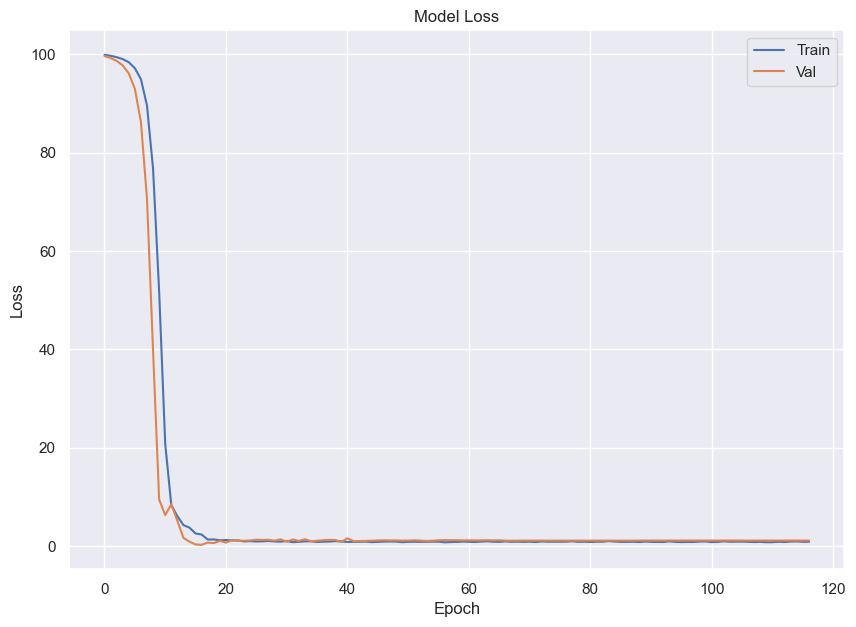

In [167]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão 12 meses em Teste com Exógenas Previstas

In [168]:
Y_pred1 = np.exp(model.predict(x_test))

1/1 [==============================] - 1s 1s/step


In [169]:
y_pred1 = pd.Series(Y_pred1.ravel())
y_pred1.index = icms_ts.index[-12:]
y_pred1

date
2022-01-01    16006695936
2022-02-01    15616589824
2022-03-01    16429159424
2022-04-01    15911664640
2022-05-01    16448786432
2022-06-01    16395975680
2022-07-01    16512505856
2022-08-01    17010724864
2022-09-01    16671528960
2022-10-01    16380158976
2022-11-01    16249837568
2022-12-01    16598267904
Name: RNN-LSTM, dtype: int64

In [170]:
RMSE_lstm1 = mean_squared_error(y_test, y_pred1, squared=False)
RMSE_lstm1

659928156.0988688

In [171]:
MAPE_lstm1 = mean_absolute_percentage_error(y_test, y_pred1)
MAPE_lstm1

0.03503300645477563

In [172]:
previsoes['nome'].append('RNN-LSTM')
previsoes['modelo'].append(model)
previsoes['previsoes'].append(y_pred1)

previsoes['rmse'].append(RMSE_lstm1)

previsoes['mape'].append(MAPE_lstm1)

In [173]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_pred1, y_test)])

### Previsão 12 meses em Teste com Exógenas Reais

In [174]:
Y_pred2 = np.exp(model.predict(x_reais_test))


1/1 [==============================] - 0s 43ms/step


In [175]:
y_pred2 = pd.Series(Y_pred2.ravel())
y_pred2.index = icms_ts.index[-12:]
y_pred2

date
2022-01-01    15907478000
2022-02-01    15572122000
2022-03-01    16489184000
2022-04-01    15856344000
2022-05-01    16383442000
2022-06-01    16364359000
2022-07-01    16749521000
2022-08-01    17168946000
2022-09-01    16733078000
2022-10-01    16211388000
2022-11-01    15966204000
2022-12-01    16446088000
Name: RNN-LSTM-Real, dtype: int64

In [176]:
RMSE_lstm2 = mean_squared_error(y_test, y_pred2, squared=False)
RMSE_lstm2

653948254.9846789

In [177]:
MAPE_lstm2 = mean_absolute_percentage_error(y_test, y_pred2)
MAPE_lstm2

0.03385476378400474

In [178]:
previsoes['nome'].append('RNN-LSTM-Real')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_pred2)

previsoes['rmse'].append(RMSE_lstm2)

previsoes['mape'].append(MAPE_lstm2)

In [179]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_pred2, y_test)])

## Resultados

In [180]:
df_prev = pd.DataFrame(data=previsoes['previsoes'], 
                       index=previsoes['nome']).transpose()
df_prev["real"] = icms_test
df_rmse = pd.DataFrame(data=previsoes['rmse'], 
                       index=previsoes['nome']).transpose()
df_mape = pd.DataFrame(data=previsoes['mape'], 
                       index=previsoes['nome']).transpose()
df_erro = pd.DataFrame(data=previsoes['erro relativo'], 
                       index=previsoes['nome']).transpose()

In [181]:
df_prev

SARIMAX(0,1,1)(2,0,1)  SARIMAX(0,1,1),(2,0,1) Real  \
2022-01-01           1.737095e+10                 1.747349e+10   
2022-02-01           1.659894e+10                 1.674207e+10   
2022-03-01           1.702141e+10                 1.723390e+10   
2022-04-01           1.637094e+10                 1.657191e+10   
2022-05-01           1.680492e+10                 1.711422e+10   
2022-06-01           1.674804e+10                 1.713244e+10   
2022-07-01           1.771244e+10                 1.831906e+10   
2022-08-01           1.792371e+10                 1.822858e+10   
2022-09-01           1.812639e+10                 1.824647e+10   
2022-10-01           1.841089e+10                 1.829613e+10   
2022-11-01           1.910451e+10                 1.888455e+10   
2022-12-01           1.968017e+10                 1.947513e+10   

            SARIMAX(0,1,1),(1,0,1)  SARIMAX(0,1,1),(1,0,1) Real  Markov-Fixed  \
2022-01-01            1.736848e+10                 1.749246e+10  1.750675e+10   
2022-02-01            1.670314e+10                 1.679599e+10  1.676622e+10   
2022-03-01            1.717694e+10                 1.727709e+10  1.710241e+10   
2022-04-01            1.632253e+10                 1.642083e+10  1.759338e+10   
2022-05-01            1.684022e+10                 1.706775e+10  1.751414e+10   
2022-06-01            1.702180e+10                 1.733715e+10  1.778654e+10   
2022-07-01            1.775046e+10                 1.826703e+10  1.773770e+10   
2022-08-01            1.814532e+10                 1.834956e+10  1.824344e+10   
2022-09-01            1.829595e+10                 1.834243e+10  1.861929e+10   
2022-10-01            1.847752e+10                 1.833283e+10  1.878027e+10   
2022-11-01            1.906535e+10                 1.883711e+10  1.873056e+10   
2022-12-01            1.978741e+10                 1.952496e+10  2.009981e+10   

            Markov-Fixed Real  Markov-Switching-Var  \
2022-01-01       1.739458e+10          1.795053e+10   
2022-02-01       1.679641e+10          1.684733e+10   
2022-03-01       1.732578e+10          1.749154e+10   
2022-04-01       1.752630e+10          1.799632e+10   
2022-05-01       1.736732e+10          1.796044e+10   
2022-06-01       1.763042e+10          1.809238e+10   
2022-07-01       1.788963e+10          1.799953e+10   
2022-08-01       1.835116e+10          1.846622e+10   
2022-09-01       1.866676e+10          1.887274e+10   
2022-10-01       1.863279e+10          1.891964e+10   
2022-11-01       1.859393e+10          1.896344e+10   
2022-12-01       2.030317e+10          1.995582e+10   

            Markov-Switching-Var Real  Markov-Mean-Var  Markov-Mean-Var Real  \
2022-01-01               1.772140e+10     1.743191e+10          1.737547e+10   
2022-02-01               1.657397e+10     1.643070e+10          1.662590e+10   
2022-03-01               1.713703e+10     1.711264e+10          1.756064e+10   
2022-04-01               1.730075e+10     1.759183e+10          1.800500e+10   
2022-05-01               1.713595e+10     1.780196e+10          1.823417e+10   
2022-06-01               1.723464e+10     1.787043e+10          1.832216e+10   
2022-07-01               1.735095e+10     1.766448e+10          1.831277e+10   
2022-08-01               1.784030e+10     1.812584e+10          1.868906e+10   
2022-09-01               1.834567e+10     1.861435e+10          1.900211e+10   
2022-10-01               1.843863e+10     1.859864e+10          1.868929e+10   
2022-11-01               1.864422e+10     1.875402e+10          1.870516e+10   
2022-12-01               1.993111e+10     1.992024e+10          2.001918e+10   

                RNN-LSTM  RNN-LSTM-Real          real  
2022-01-01  1.600670e+10   1.590748e+10  1.675250e+10  
2022-02-01  1.561659e+10   1.557212e+10  1.582980e+10  
2022-03-01  1.642916e+10   1.648918e+10  1.628352e+10  
2022-04-01  1.591166e+10   1.585634e+10  1.682937e+10  
2022-05-01  1.644879e+10   1.638344e+10  1.689841e+10  
2022-0

In [182]:
df_erro

SARIMAX(0,1,1)(2,0,1) SARIMAX(0,1,1),(2,0,1) Real SARIMAX(0,1,1),(1,0,1)  \
0               3.691666                    4.303748               3.676908   
1               4.858846                    5.763032               5.517093   
2               4.531499                    5.836414               5.486639   
3               2.723959                    1.529788               3.011637   
4               0.553279                    1.277087               0.344351   
5               1.334442                    0.930115               0.278343   
6               1.608188                    5.088098               1.826275   
7               2.058191                    3.794144               3.320074   
8               5.002192                    5.697779               5.984451   
9              17.641497                   16.908149              18.067248   
10             19.031191                   17.660752              18.787232   
11             11.367685                    10.20734              11.974537   

   SARIMAX(0,1,1),(1,0,1) Real Markov-Fixed Markov-Fixed Real  \
0                     4.417021     4.502325           3.83276   
1                     6.103629     5.915551          6.106265   
2                     6.101663     5.028904            6.4007   
3                     2.427529     4.539751          4.141151   
4                     1.002065     3.643688          2.774841   
5                     2.136082     4.783566          3.863792   
6                     4.789606     1.753091          2.624632   
7                     4.483031     3.878786          4.492142   
8                       6.2537      7.85749          8.132446   
9                    17.142673    20.001698         19.059331   
10                   17.365178    16.701314         15.850037   
11                   10.489342    13.742347         14.893133   

   Markov-Switching-Var Markov-Switching-Var Real Markov-Mean-Var  \
0              7.151333                  5.783633         4.05559   
1              6.427986                  4.701129         3.79602   
2              7.418631                  5.241519        5.091725   
3              6.934038                  2.800986        4.530562   
4              6.284786                  1.405701        5.346924   
5              6.585299                   1.53219        5.277753   
6              3.255078                   0.46552        1.333038   
7              5.147306                  1.583267        3.209154   
8              9.325635                  6.272435         7.82887   
9             20.892272                 17.818715       18.841126   
10            18.152271                  16.16337       16.847507   
11            12.927516                 12.787715       12.726199   

   Markov-Mean-Var Real              RNN-LSTM         RNN-LSTM-Real  
0              3.718632   [4.451905239144631]   [5.044162678706734]  
1               5.02912  [1.3468648262774134]  [1.6277770037370156]  
2              7.842993  [0.8943786597427444]  [1.2630002150846196]  
3              6.985599  [5.4529796464427625]   [5.781694573157798]  
4               7.90465   [2.660756266343227]  [3.0474460455181385]  
5              7.938979  [3.4085101112640626]  [3.5947693669581646]  
6              5.052023   [5.275285326842505]   [3.915637549309124]  
7              6.416145   [3.140351570611199]   [2.239435017696308]  
8             10.075049  [3.4254822355156205]   [3.068942120261131]  
9             19.420414  [4.6655525623002685]  [3.5871437699680007]  
10            16.543026  [1.2450938816197812]  [0.5220934579440789]  
11            13.286074   [6.072447419626544]    [6.93361474246458]

### Resultados Apenas das Redes Neurais

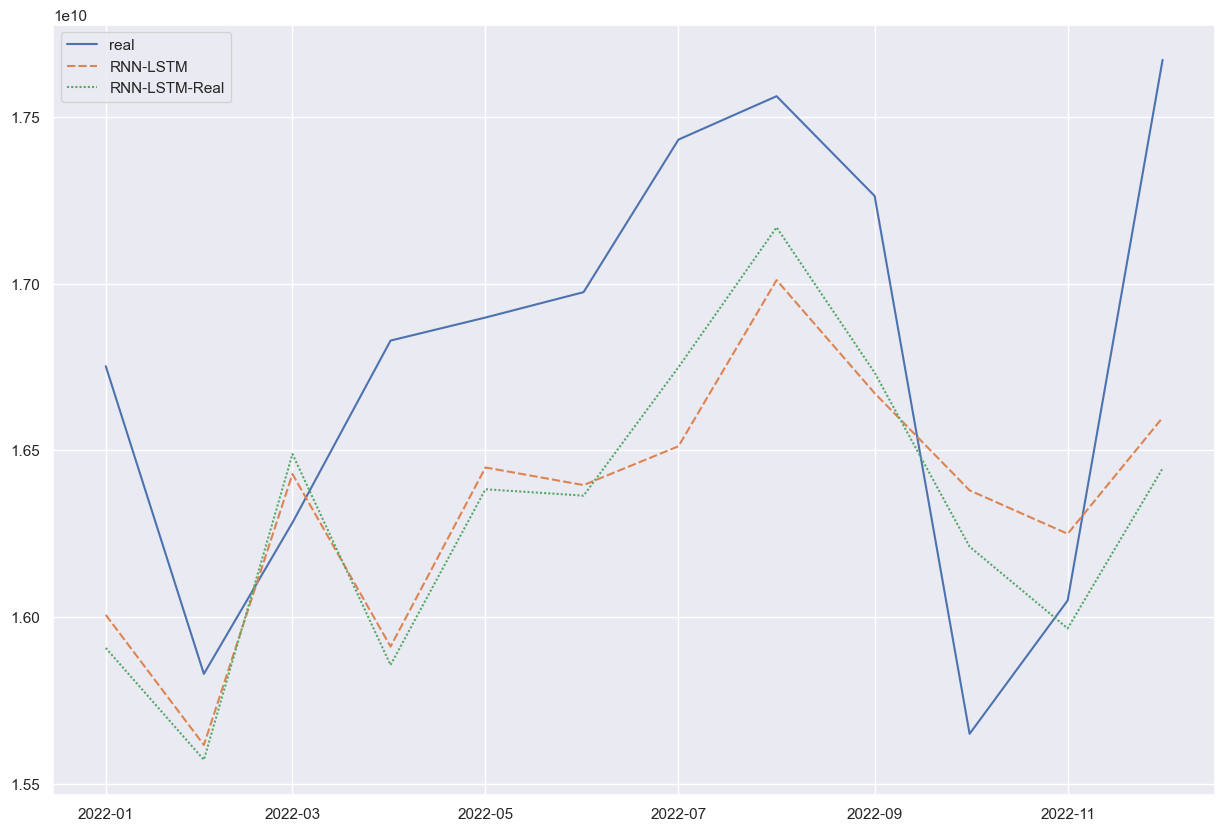

In [183]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev[['real', 'RNN-LSTM', 'RNN-LSTM-Real']])

In [184]:
df_rmse_lstm = df_rmse[['RNN-LSTM', 'RNN-LSTM-Real']]
df_mape_lstm = df_mape[['RNN-LSTM', 'RNN-LSTM-Real']]

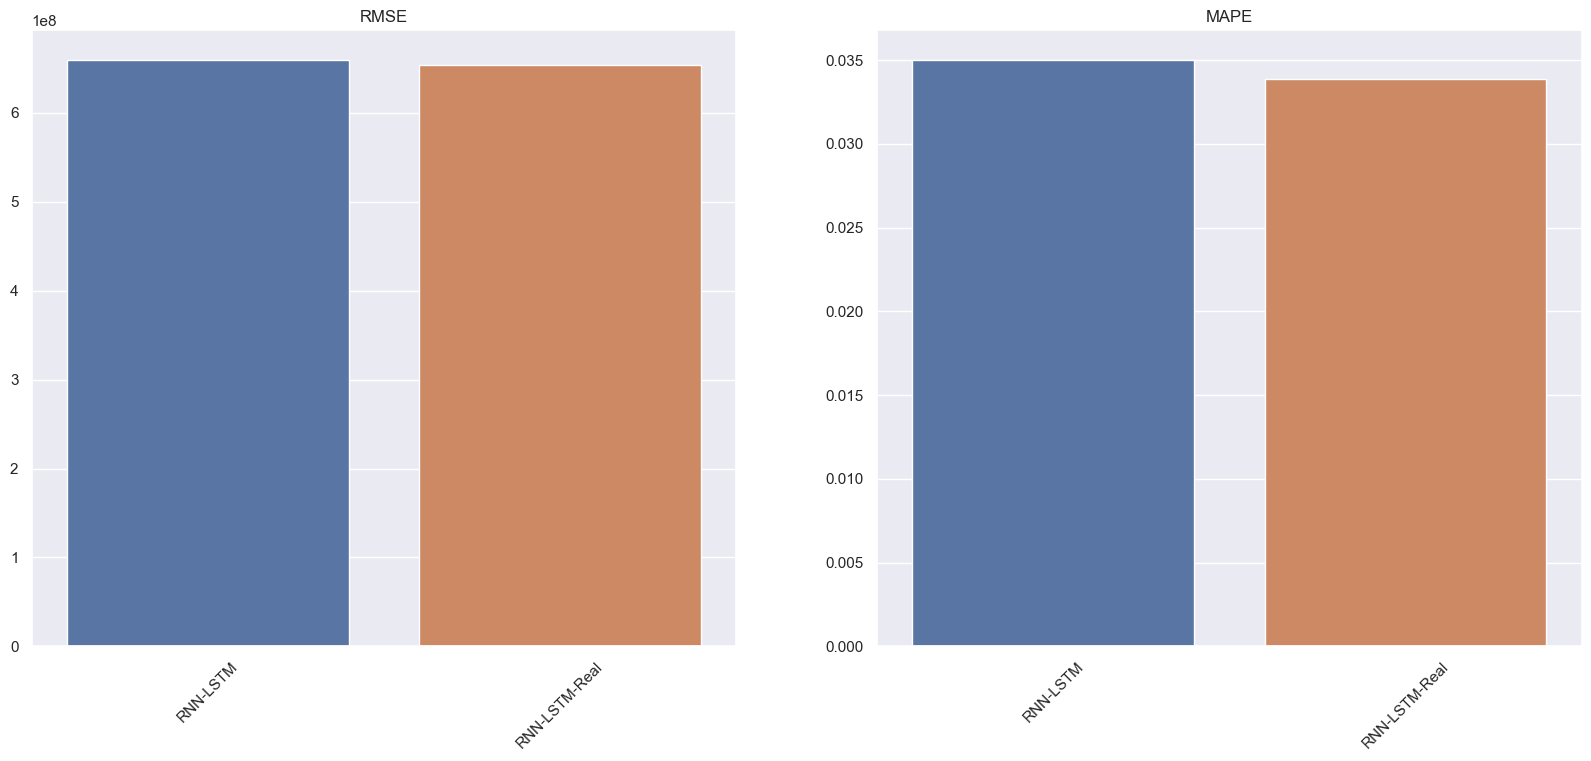

In [185]:
fig=plt.figure(figsize=(20, 8))
ax1=fig.add_subplot(121)
ax1 = sns.barplot(data=df_rmse_lstm)
ax1.set_title('RMSE')
_ = plt.xticks(rotation=45)
ax2=fig.add_subplot(122)
ax2 = sns.barplot(data=df_mape_lstm)
ax2.set_title('MAPE')
_ = plt.xticks(rotation=45)
plt.show()

### Resultados Gerais com os Dados Previstos

#### Previsões com os Dados Previstos

In [186]:
df_prev_prev = df_prev[['SARIMAX(0,1,1)(2,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'Markov-Mean-Var',
 'RNN-LSTM', 'real']]

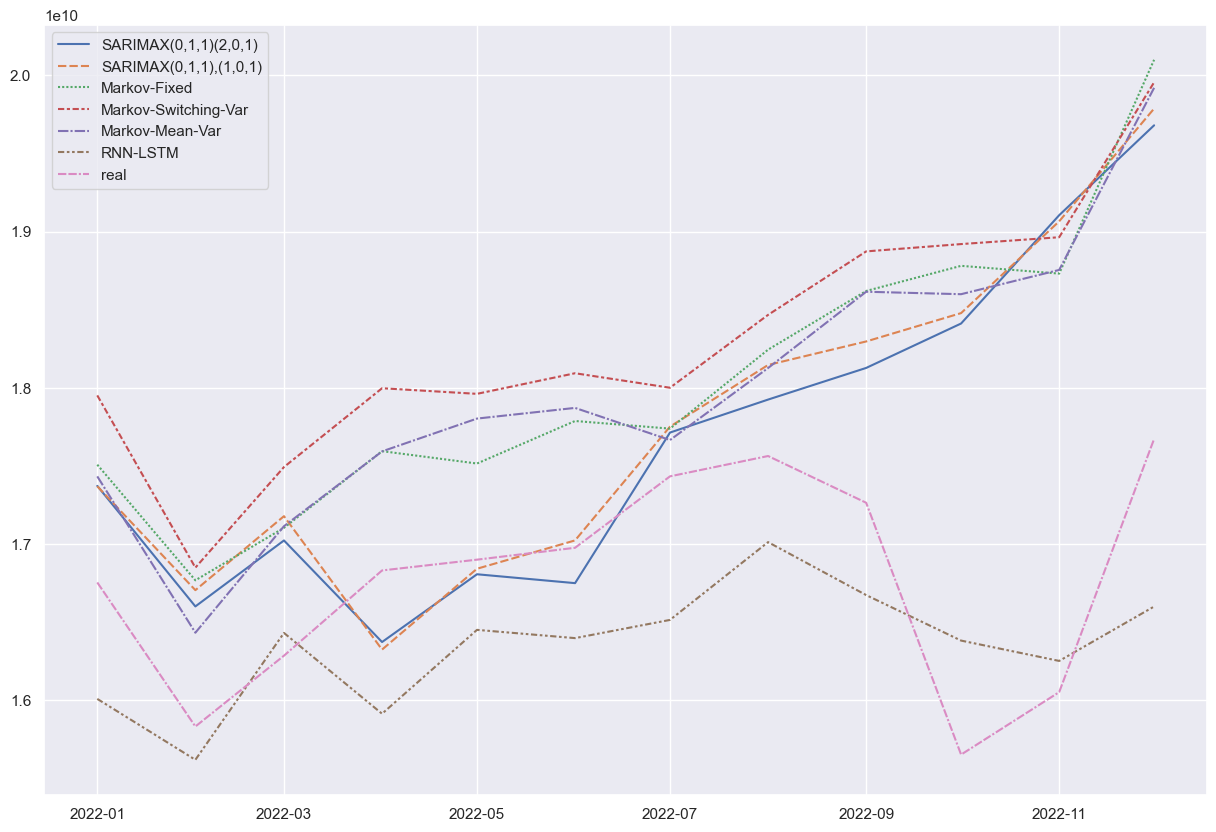

In [187]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev_prev)

#### RMSE com Dados Previstos

In [188]:
previsoes['nome']

['SARIMAX(0,1,1)(2,0,1)',
 'SARIMAX(0,1,1),(2,0,1) Real',
 'SARIMAX(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(1,0,1) Real',
 'Markov-Fixed',
 'Markov-Fixed Real',
 'Markov-Switching-Var',
 'Markov-Switching-Var Real',
 'Markov-Mean-Var',
 'Markov-Mean-Var Real',
 'RNN-LSTM',
 'RNN-LSTM-Real']

In [189]:
df_rmse

SARIMAX(0,1,1)(2,0,1)  SARIMAX(0,1,1),(2,0,1) Real  SARIMAX(0,1,1),(1,0,1)  \
0           1.406283e+09                 1.380866e+09            1.451333e+09   

   SARIMAX(0,1,1),(1,0,1) Real  Markov-Fixed  Markov-Fixed Real  \
0                 1.404729e+09  1.555024e+09       1.545594e+09   

   Markov-Switching-Var  Markov-Switching-Var Real  Markov-Mean-Var  \
0          1.727172e+09               1.397517e+09     1.499231e+09   

   Markov-Mean-Var Real      RNN-LSTM  RNN-LSTM-Real  
0          1.695706e+09  6.599282e+08   6.539483e+08

In [190]:
df_rmse_prev = df_rmse[['SARIMAX(0,1,1)(2,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'Markov-Mean-Var',
 'RNN-LSTM']]

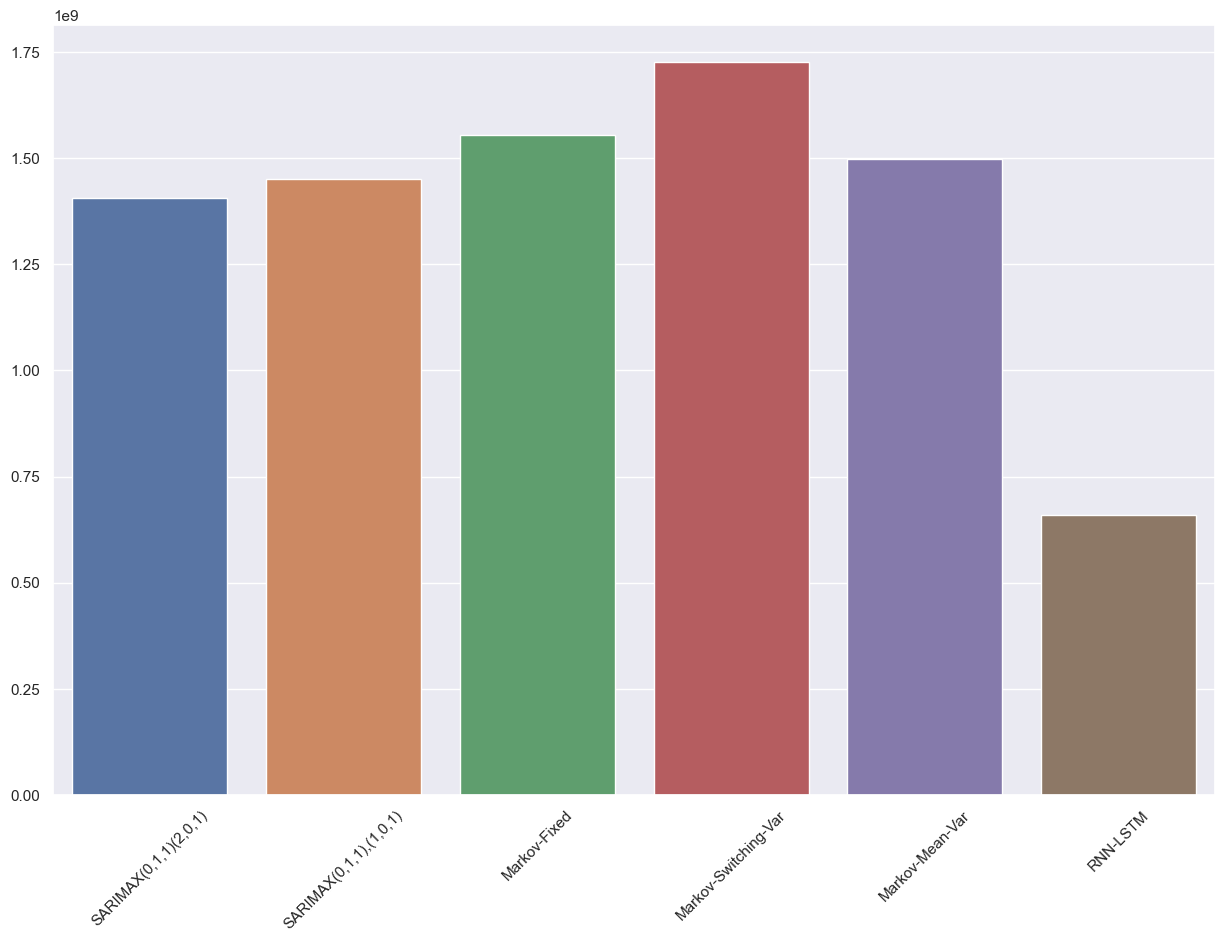

In [191]:
fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(data=df_rmse_prev)
_ = plt.xticks(rotation=45)

#### MAPE dos Dados Previstos

In [192]:
df_mape_prev = df_mape[['SARIMAX(0,1,1)(2,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'Markov-Mean-Var',
 'RNN-LSTM']]

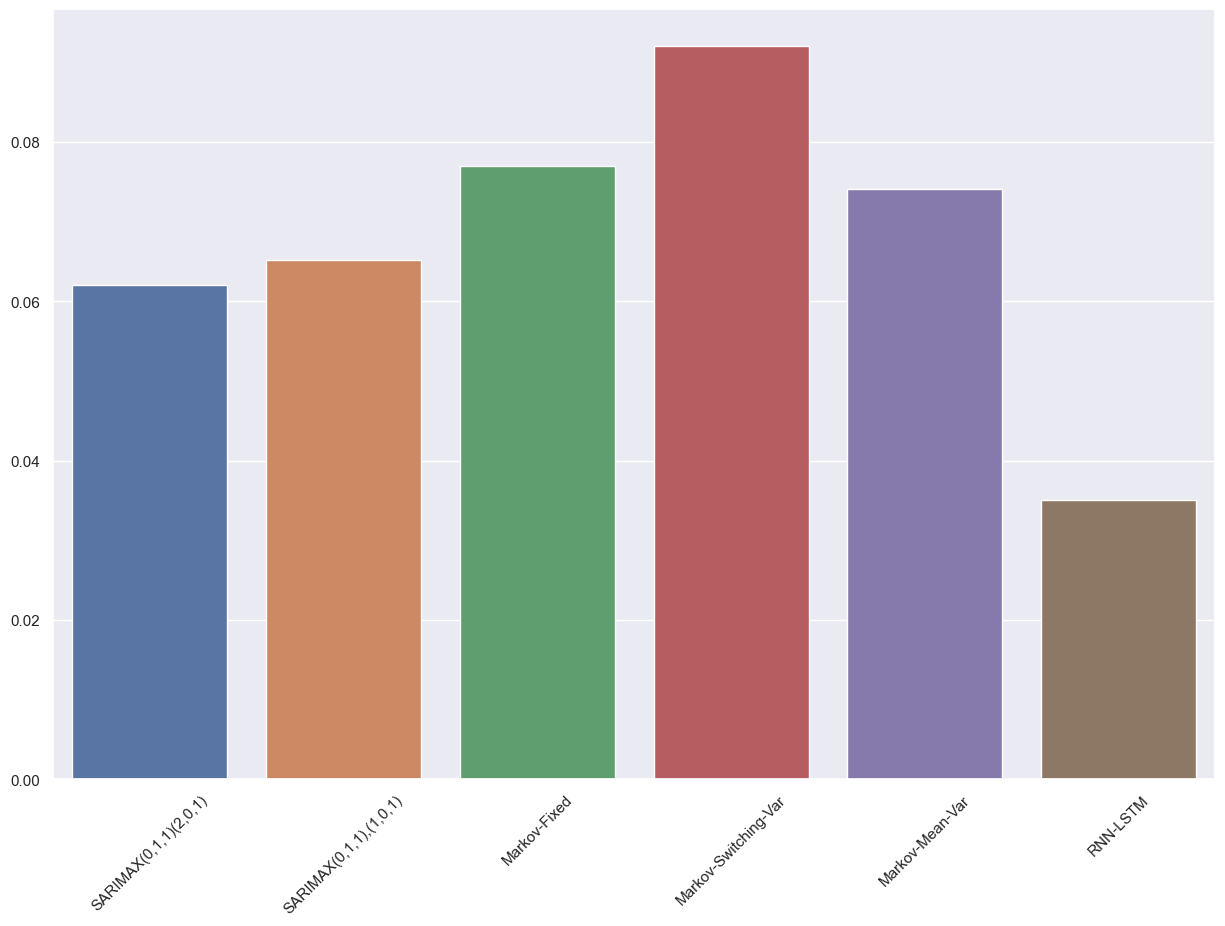

In [193]:
fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(data=df_mape_prev)
_ = plt.xticks(rotation=45)

### Resumo das métricas

In [194]:
df_rmse_prev.index = ['RMSE']
df_mape_prev.index = ['MAPE']

In [195]:
df_metricas = df_rmse_prev.copy()
df_metricas = df_metricas.append(df_mape_prev)
df_metricas

SARIMAX(0,1,1)(2,0,1)  SARIMAX(0,1,1),(1,0,1)  Markov-Fixed  \
RMSE           1.406283e+09            1.451333e+09  1.555024e+09   
MAPE           6.200220e-02            6.522899e-02  7.695709e-02   

      Markov-Switching-Var  Markov-Mean-Var      RNN-LSTM  
RMSE          1.727172e+09     1.499231e+09  6.599282e+08  
MAPE          9.208513e-02     7.407039e-02  3.503301e-02

In [196]:
df_metricas.transpose().to_excel('./metricas_multi_2022.xlsx', index_label='metrica')

In [197]:
df_prev_prev.to_excel('./previsoes_multi_2022.xlsx', index_label='mes_ano')

In [198]:
print(df_metricas.transpose().to_latex(escape=False))

\begin{tabular}{lrr}
\toprule
{} &          RMSE &      MAPE \\
\midrule
SARIMAX(0,1,1)(2,0,1)  &  1.406283e+09 &  0.062002 \\
SARIMAX(0,1,1),(1,0,1) &  1.451333e+09 &  0.065229 \\
Markov-Fixed           &  1.555024e+09 &  0.076957 \\
Markov-Switching-Var   &  1.727172e+09 &  0.092085 \\
Markov-Mean-Var        &  1.499231e+09 &  0.074070 \\
RNN-LSTM               &  6.599282e+08 &  0.035033 \\
\bottomrule
\end{tabular}



In [199]:
print(df_prev_prev['2022-01-01':'2022-04-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2022-01-01 &    2022-02-01 &    2022-03-01 &    2022-04-01 \\
\midrule
SARIMAX(0,1,1)(2,0,1)  &  1.737095e+10 &  1.659894e+10 &  1.702141e+10 &  1.637094e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.736848e+10 &  1.670314e+10 &  1.717694e+10 &  1.632253e+10 \\
Markov-Fixed           &  1.750675e+10 &  1.676622e+10 &  1.710241e+10 &  1.759338e+10 \\
Markov-Switching-Var   &  1.795053e+10 &  1.684733e+10 &  1.749154e+10 &  1.799632e+10 \\
Markov-Mean-Var        &  1.743191e+10 &  1.643070e+10 &  1.711264e+10 &  1.759183e+10 \\
RNN-LSTM               &  1.600670e+10 &  1.561659e+10 &  1.642916e+10 &  1.591166e+10 \\
real                   &  1.675250e+10 &  1.582980e+10 &  1.628352e+10 &  1.682937e+10 \\
\bottomrule
\end{tabular}



In [200]:
print(df_prev_prev['2022-05-01':'2022-08-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2022-05-01 &    2022-06-01 &    2022-07-01 &    2022-08-01 \\
\midrule
SARIMAX(0,1,1)(2,0,1)  &  1.680492e+10 &  1.674804e+10 &  1.771244e+10 &  1.792371e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.684022e+10 &  1.702180e+10 &  1.775046e+10 &  1.814532e+10 \\
Markov-Fixed           &  1.751414e+10 &  1.778654e+10 &  1.773770e+10 &  1.824344e+10 \\
Markov-Switching-Var   &  1.796044e+10 &  1.809238e+10 &  1.799953e+10 &  1.846622e+10 \\
Markov-Mean-Var        &  1.780196e+10 &  1.787043e+10 &  1.766448e+10 &  1.812584e+10 \\
RNN-LSTM               &  1.644879e+10 &  1.639598e+10 &  1.651251e+10 &  1.701072e+10 \\
real                   &  1.689841e+10 &  1.697456e+10 &  1.743210e+10 &  1.756224e+10 \\
\bottomrule
\end{tabular}



In [201]:
print(df_prev_prev['2022-09-01':'2022-12-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2022-09-01 &    2022-10-01 &    2022-11-01 &    2022-12-01 \\
\midrule
SARIMAX(0,1,1)(2,0,1)  &  1.812639e+10 &  1.841089e+10 &  1.910451e+10 &  1.968017e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.829595e+10 &  1.847752e+10 &  1.906535e+10 &  1.978741e+10 \\
Markov-Fixed           &  1.861929e+10 &  1.878027e+10 &  1.873056e+10 &  2.009981e+10 \\
Markov-Switching-Var   &  1.887274e+10 &  1.891964e+10 &  1.896344e+10 &  1.995582e+10 \\
Markov-Mean-Var        &  1.861435e+10 &  1.859864e+10 &  1.875402e+10 &  1.992024e+10 \\
RNN-LSTM               &  1.667153e+10 &  1.638016e+10 &  1.624984e+10 &  1.659827e+10 \\
real                   &  1.726287e+10 &  1.565000e+10 &  1.605000e+10 &  1.767135e+10 \\
\bottomrule
\end{tabular}

